In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import SimpleRNN , Input,Flatten, LSTM
from tensorflow.keras import backend as K
from keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

In [2]:
opened = []

csv_path = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/'
masterlist = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/ALL_STATIONS_ALL_MONTHS_PRECIP.csv'

# Load the master list of stations
total_df = pd.read_csv(masterlist)

# # Extract station numbers, areas, and latitudes
# station_num = stations_df['grdc_no']
# station_area = stations_df['area']
# station_lat = stations_df['lat']
# station_avgslope = stations_df['avg_slope']
# station_maxslope = stations_df['max_slope']
# station_aridity = stations_df['avg_aridity']
# station_precip = stations_df['P']

# # Map station numbers to areas and latitudes
# station_area_map = dict(zip(station_num, station_area))
# station_lat_map = dict(zip(station_num, station_lat))
# station_avgslope_map = dict(zip(station_num, station_avgslope))
# station_maxslope_map = dict(zip(station_num, station_maxslope))
# station_aridity_map = dict(zip(station_num, station_aridity))
# # station_precip_map = dict(zip(station_num, station_precip))

# # Generate the list of file paths
# arrayFile = [os.path.join(csv_path, f"{station_no}.csv") for station_no in station_num]
# # print(arrayFile)
# # Initialize a list to store opened DataFrames
# for file in arrayFile:
#     station_no = os.path.basename(file).split('.')[0]
#     # print(station_no)# Extract station number from the filename
#     if os.path.exists(file):  # Check if file exists
#         df = pd.read_csv(file, index_col=None, header=0)
#         station_no_int = int(station_no)  # Convert station number to integer for lookup
#         df['GRDC_No'] = station_no_int  # Add the station number as a new column
#         df['Area'] = station_area_map.get(station_no_int, None)  # Add the Area column
#         df['Latitude'] = station_lat_map.get(station_no_int, None)  # Add the latitude column
#         df['Avg Slope'] = station_avgslope_map.get(station_no_int, None)
#         df['Max Slope'] = station_maxslope_map.get(station_no_int, None)
#         df['Aridity'] = station_aridity_map.get(station_no_int, None)
#         df['Precip'] = station_precip
#         opened.append(df)

# # Combine all DataFrames into one
# total_df = pd.concat(opened, axis=0, ignore_index=True)

# Print or save the resulting DataFrame
print(total_df)

       Unnamed: 0     Date       Q       SWE    SWE_scaled  GRDC_No  SHP  \
0               0  2018-08  24.526  2.087791  1.809042e+06  1159100    1   
1               1  2018-09  31.372  1.835435  1.590379e+06  1159100    1   
2               2  2018-10  19.572  1.976332  1.712464e+06  1159100    1   
3               3  2018-11   7.349  1.633273  1.415208e+06  1159100    1   
4               4  2018-12  13.824  1.782850  1.544815e+06  1159100    1   
...           ...      ...     ...       ...           ...      ...  ...   
23053          57  2023-05   3.046  3.400061  5.610100e+04  6594090    1   
23054          58  2023-06   2.489  3.195970  5.273351e+04  6594090    1   
23055          59  2023-07   2.021  3.656259  6.032828e+04  6594090    2   
23056          60  2023-08   2.067  3.578097  5.903860e+04  6594090    1   
23057          61  2023-09   2.483  3.630205  5.989839e+04  6594090    1   

           Area  Latitude  Avg Slope  Max Slope     Aridity    Precip  \
0      866486.

In [3]:
landcover = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/ALL_STATIONS_LANDCOVER.csv'
landcover_df = pd.read_csv(landcover)

# Ensure number and GRDC_No are of the same type
total_df['GRDC_No'] = total_df['GRDC_No'].astype(int)
landcover_df['number'] = landcover_df['number'].astype(int)

# Initialize empty lists for new columns
new_columns = {col: [] for col in landcover_df.columns if col != 'number'}

# Loop through total_df and match with landcover_df
for grdc_no in total_df['GRDC_No']:
    match = landcover_df[landcover_df['number'] == grdc_no]
    
    if not match.empty:
        for col in new_columns:
            new_columns[col].append(match[col].values[0])  # Append matched value
    else:
        for col in new_columns:
            new_columns[col].append(None)  # Append NaN if no match found

# Convert lists to a DataFrame and concatenate with total_df
new_data = pd.DataFrame(new_columns)
total_df = pd.concat([total_df, new_data], axis=1)

print(total_df.head())

   Unnamed: 0     Date       Q       SWE   SWE_scaled  GRDC_No  SHP      Area  \
0           0  2018-08  24.526  2.087791  1809042.021  1159100    1  866486.0   
1           1  2018-09  31.372  1.835435  1590378.590  1159100    1  866486.0   
2           2  2018-10  19.572  1.976332  1712463.856  1159100    1  866486.0   
3           3  2018-11   7.349  1.633273  1415208.035  1159100    1  866486.0   
4           4  2018-12  13.824  1.782850  1544814.625  1159100    1  866486.0   

   Latitude  Avg Slope  ...        11        12        13        14        15  \
0 -28.75799   0.745665  ...  0.725055  0.678026  0.634266  0.625967  0.632506   
1 -28.75799   0.745665  ...  0.725055  0.678026  0.634266  0.625967  0.632506   
2 -28.75799   0.745665  ...  0.725055  0.678026  0.634266  0.625967  0.632506   
3 -28.75799   0.745665  ...  0.725055  0.678026  0.634266  0.625967  0.632506   
4 -28.75799   0.745665  ...  0.725055  0.678026  0.634266  0.625967  0.632506   

         16       17      

In [4]:
soiltype = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/ALL_STATIONS_SOILTYPE.csv'
soiltype_df = pd.read_csv(soiltype)
# print(soiltype_df.head())
# Ensure number and GRDC_No are of the same type
total_df['GRDC_No'] = total_df['GRDC_No'].astype(int)
soiltype_df['number'] = soiltype_df['number'].astype(int)

# Initialize empty lists for new columns
new_columns = {col: [] for col in soiltype_df.columns if col != 'number'}

# Loop through total_df and match with landcover_df
for grdc_no in total_df['GRDC_No']:
    match = soiltype_df[soiltype_df['number'] == grdc_no]
    
    if not match.empty:
        for col in new_columns:
            new_columns[col].append(match[col].values[0])  # Append matched value
    else:
        for col in new_columns:
            new_columns[col].append(None)  # Append NaN if no match found

# Convert lists to a DataFrame and concatenate with total_df
new_data = pd.DataFrame(new_columns)
total_df = pd.concat([total_df, new_data], axis=1)

print(total_df.head())

   Unnamed: 0     Date       Q       SWE   SWE_scaled  GRDC_No  SHP      Area  \
0           0  2018-08  24.526  2.087791  1809042.021  1159100    1  866486.0   
1           1  2018-09  31.372  1.835435  1590378.590  1159100    1  866486.0   
2           2  2018-10  19.572  1.976332  1712463.856  1159100    1  866486.0   
3           3  2018-11   7.349  1.633273  1415208.035  1159100    1  866486.0   
4           4  2018-12  13.824  1.782850  1544814.625  1159100    1  866486.0   

   Latitude  Avg Slope  ...         7         8         9        10       11  \
0 -28.75799   0.745665  ...  1.132788  1.497797  5.198238  0.453115  0.98175   
1 -28.75799   0.745665  ...  1.132788  1.497797  5.198238  0.453115  0.98175   
2 -28.75799   0.745665  ...  1.132788  1.497797  5.198238  0.453115  0.98175   
3 -28.75799   0.745665  ...  1.132788  1.497797  5.198238  0.453115  0.98175   
4 -28.75799   0.745665  ...  1.132788  1.497797  5.198238  0.453115  0.98175   

        12   13   14   15   16  

In [5]:
q = total_df['Q']
swe = total_df['SWE']
scaled = total_df['SWE_scaled']
area = total_df['Area']
station = total_df['GRDC_No']
lat = total_df['Latitude']
avg_slope = total_df['Avg Slope']
max_slope = total_df['Max Slope']
avg_aridity = total_df['Aridity']
precip = total_df['P']

In [6]:
# plt.scatter(lat,q,color='r')
# plt.title('Raw Data - All Basins')
# plt.xlabel('Latitude [deg]')
# plt.ylabel('Streamflow [m${^3}$/s]')
# # plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
# plt.show()

In [7]:
lc_types = total_df.iloc[:, 14:-16]
soil_types = total_df.iloc[:, -16:]

# lc_types = lc_types/100
# soil_types = soil_types/100

print(lc_types)
print(soil_types)

              1          2          3         4         5         6         7  \
0      6.136561  60.524866  17.803458  3.554480  1.860924  1.402201  1.166174   
1      6.136561  60.524866  17.803458  3.554480  1.860924  1.402201  1.166174   
2      6.136561  60.524866  17.803458  3.554480  1.860924  1.402201  1.166174   
3      6.136561  60.524866  17.803458  3.554480  1.860924  1.402201  1.166174   
4      6.136561  60.524866  17.803458  3.554480  1.860924  1.402201  1.166174   
...         ...        ...        ...       ...       ...       ...       ...   
23053  5.348157  14.675249  16.582797  9.654769  5.874781  4.628438  4.253950   
23054  5.348157  14.675249  16.582797  9.654769  5.874781  4.628438  4.253950   
23055  5.348157  14.675249  16.582797  9.654769  5.874781  4.628438  4.253950   
23056  5.348157  14.675249  16.582797  9.654769  5.874781  4.628438  4.253950   
23057  5.348157  14.675249  16.582797  9.654769  5.874781  4.628438  4.253950   

              8         9  

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU

# lc_in = lc_types.idxmax(axis=1)
# soil_in = soil_types.idxmax(axis=1)
# print(lc_class)

# lat_in = (lat*np.pi)/180
# Convert q and swe to NumPy arrays
scaled_in = scaled.to_numpy()  # Assume scaled is a pandas Series
area_in = area.to_numpy()      # Assume area is a pandas Series
lat_in = lat.to_numpy()
avg_slope_in = avg_slope.to_numpy()
# avg_slope_in = (avg_slope_in*np.pi)/180
max_slope_in = max_slope.to_numpy()
# max_slope_in = (max_slope_in*np.pi)/180
avg_aridity_in = avg_aridity.to_numpy()
precip_in = precip.to_numpy()
# avg_aridity_in = avg_aridity_in*0.0001
y = q.to_numpy()            # Target variable

# lc_in = lc_types.to_numpy()
# soil_in = soil_types.to_numpy()

# Convert q and swe to NumPy arrays
# scaled_in = scaled_in/max(scaled_in)  # Assume scaled is a pandas Series
# area_in = area_in/max(area_in)      # Assume area is a pandas Series
# lat_in = lat_in/180
# avg_slope_in = avg_slope_in/180
# max_slope_in = max_slope_in/180
# avg_aridity_in = avg_aridity_in/max(avg_aridity_in)
# y = y/max(y)            # Target variable
# lc_in = lc_types/max(lc_types)
# soil_in = soil_types/max(soil_types)

# Step 1: Replace zeros with a small value
scaled_in[scaled_in == 0] = 1e-9
area_in[area_in == 0] = 1e-9
lat_in[lat_in == 0] = 1e-9
avg_slope_in[avg_slope_in == 0] = 1e-9
max_slope_in[max_slope_in == 0] = 1e-9
avg_aridity_in[avg_aridity_in == 0] = 1e-9
precip_in[precip_in == 0] = 1e-9
y[y == 0] = 1e-9

# Step 2: Combine features into a 2D array
X = np.column_stack((scaled_in, area_in, lat_in, avg_slope_in, max_slope_in, precip_in, lc_types, soil_types))  # Shape will be (num_samples, 2)
# Step 3: Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
print(X_scaled[0])
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

[0.04218477 0.18426304 0.10942487 0.05021058 0.49462185 0.01178741
 0.07071869 0.60937122 0.18412169 0.05596715 0.01898438 0.02863306
 0.04942357 0.0614902  0.05019695 0.01338399 0.03921611 0.03248417
 0.05217229 0.0542117  0.04254099 0.02950674 0.03364036 0.01020581
 0.         0.         0.         0.09342194 0.47702958 0.0254248
 0.13466151 0.24241661 0.0119402  0.02133227 0.05308839 0.00453115
 0.01931485 0.02201936 0.         0.         0.         0.        ]


In [9]:
# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define the model
model = Sequential([
    Dense(512, input_dim=42, activation='leaky_relu'),
    Dense(256, activation='leaky_relu'),
    Dropout(0.2),
    Dense(128, activation='leaky_relu'),
    Dropout(0.2),
    Dense(64, activation='leaky_relu'),
    Dropout(0.2),
    Dense(32, activation='leaky_relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
from tensorflow.keras.optimizers import RMSprop, Nadam
from tensorflow.keras.losses import Huber
model.compile(optimizer=Nadam(learning_rate=1e-3), loss=Huber(delta=0.1), metrics=['mae','r2_score'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=175,  # High epochs with early stopping
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]
)

/global/home/users/arvalcarcel/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-28 16:39:50.814223: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/175
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.6629e-04 - mae: 0.0086 - r2_score: 0.1246 - val_loss: 9.3679e-05 - val_mae: 0.0029 - val_r2_score: 0.5984 - learning_rate: 0.0010
Epoch 2/175
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5834e-05 - mae: 0.0033 - r2_score: 0.7754 - val_loss: 5.4023e-05 - val_mae: 0.0023 - val_r2_score: 0.7717 - learning_rate: 0.0010
Epoch 3/175
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.5086e-05 - mae: 0.0030 - r2_score: 0.8174 - val_loss: 4.0543e-05 - val_mae: 0.0019 - val_r2_score: 0.8774 - learning_rate: 0.0010
Epoch 4/175
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.5023e-05 - mae: 0.0026 - r2_score: 0.8341 - val_loss: 7.3297e-05 - val_mae: 0.0044 - val_r2_score: 0.6759 - learning_rate: 0.0010
Epoch 5/175
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.4136e-05 - mae: 0.0034 - r2_score: 0.8031 - val_loss: 5.2115e-05 - val_mae: 0.0025 - val_r2_score: 0.8440 - learning_rate: 0.0010
Epoch 6/175
289/289 ━━━━━━━━━━━━━━━

In [11]:
# Step 7: Evaluate
test_loss = model.evaluate(X_test, y_test)
print(f"Test MAPE: {test_loss}")

# Step 8: Predict
predictions = model.predict(X_test)
y_pred = scaler_y.inverse_transform(predictions)

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2245e-05 - mae: 0.0016 - r2_score: 0.9112
Test MAPE: [2.5876148356474005e-05, 0.0014718540478497744, 0.9253475069999695]
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [12]:
y_pred = model.predict(X_test)

def nse(predictions, targets):
    return 1 - (np.sum((targets - predictions) ** 2) / np.sum((targets - np.mean(targets)) ** 2))

nse(y_pred, y_test)

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


0.9253475289211401

In [13]:
# !pip install shap
import shap

explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer.shap_values(X_test)

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━

PermutationExplainer explainer:   0%|          | 5/4612 [00:00<?, ?it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 7/4612 [00:12<1:02:55,  1.22it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 8/4612 [00:14<1:28:18,  1.15s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 9/4612 [00:16<1:42:42,  1.34s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 10/4612 [00:17<1:54:29,  1.49s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 11/4612 [00:19<2:01:11,  1.58s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 12/4612 [00:21<2:03:45,  1.61s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 13/4612 [00:23<2:07:43,  1.67s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 14/4612 [00:24<2:06:46,  1.65s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step


PermutationExplainer explainer:   0%|          | 15/4612 [00:26<2:08:34,  1.68s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 16/4612 [00:28<2:09:18,  1.69s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 17/4612 [00:29<2:10:36,  1.71s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 18/4612 [00:31<2:09:32,  1.69s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 19/4612 [00:33<2:08:20,  1.68s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 20/4612 [00:34<2:04:49,  1.63s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 21/4612 [00:36<2:04:10,  1.62s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 22/4612 [00:38<2:06:55,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   0%|          | 23/4612 [00:39<2:08:22,  1.68s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 24/4612 [00:41<2:07:35,  1.67s/it]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 25/4612 [00:43<2:12:04,  1.73s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 26/4612 [00:45<2:10:46,  1.71s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 27/4612 [00:46<2:12:51,  1.74s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 28/4612 [00:48<2:12:40,  1.74s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 29/4612 [00:50<2:13:14,  1.74s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:   1%|          | 30/4612 [00:52<2:10:54,  1.71s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 31/4612 [00:53<2:11:04,  1.72s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 32/4612 [00:55<2:10:08,  1.70s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 33/4612 [00:57<2:10:31,  1.71s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 34/4612 [00:58<2:09:32,  1.70s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 35/4612 [01:00<2:10:26,  1.71s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


PermutationExplainer explainer:   1%|          | 36/4612 [01:02<2:11:47,  1.73s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 37/4612 [01:03<2:10:12,  1.71s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:   1%|          | 38/4612 [01:05<2:10:26,  1.71s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:   1%|          | 39/4612 [01:07<2:10:19,  1.71s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 40/4612 [01:09<2:11:37,  1.73s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 41/4612 [01:10<2:10:45,  1.72s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 42/4612 [01:12<2:07:22,  1.67s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 43/4612 [01:14<2:06:35,  1.66s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 44/4612 [01:15<2:05:26,  1.65s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 45/4612 [01:17<2:06:27,  1.66s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 46/4612 [01:19<2:07:49,  1.68s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 47/4612 [01:20<2:07:34,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 48/4612 [01:22<2:09:42,  1.71s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 49/4612 [01:24<2:11:34,  1.73s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 50/4612 [01:25<2:09:20,  1.70s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 51/4612 [01:27<2:07:49,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 52/4612 [01:29<2:09:39,  1.71s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 53/4612 [01:31<2:09:27,  1.70s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 54/4612 [01:32<2:08:42,  1.69s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:   1%|          | 55/4612 [01:34<2:01:16,  1.60s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 56/4612 [01:35<1:56:48,  1.54s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|          | 57/4612 [01:37<2:03:00,  1.62s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|▏         | 58/4612 [01:39<2:05:54,  1.66s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|▏         | 59/4612 [01:40<2:06:40,  1.67s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|▏         | 60/4612 [01:42<2:06:09,  1.66s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|▏         | 61/4612 [01:44<2:08:57,  1.70s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|▏         | 62/4612 [01:45<2:10:03,  1.71s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:   1%|▏         | 63/4612 [01:47<2:04:11,  1.64s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|▏         | 64/4612 [01:49<2:04:45,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|▏         | 65/4612 [01:50<2:07:40,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|▏         | 66/4612 [01:52<2:07:47,  1.69s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|▏         | 67/4612 [01:54<2:08:56,  1.70s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|▏         | 68/4612 [01:55<2:07:25,  1.68s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   1%|▏         | 69/4612 [01:57<2:09:43,  1.71s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 70/4612 [01:59<2:09:18,  1.71s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 71/4612 [02:01<2:09:46,  1.71s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 72/4612 [02:02<2:08:46,  1.70s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 73/4612 [02:04<2:08:47,  1.70s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 74/4612 [02:06<2:07:40,  1.69s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:   2%|▏         | 75/4612 [02:07<2:08:31,  1.70s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 76/4612 [02:09<2:06:40,  1.68s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 77/4612 [02:11<2:09:25,  1.71s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:   2%|▏         | 78/4612 [02:12<2:03:43,  1.64s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 79/4612 [02:14<2:04:10,  1.64s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 80/4612 [02:16<2:05:55,  1.67s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 81/4612 [02:17<2:06:43,  1.68s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 82/4612 [02:19<2:06:42,  1.68s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 83/4612 [02:21<2:06:07,  1.67s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 84/4612 [02:22<2:05:52,  1.67s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 85/4612 [02:24<2:08:12,  1.70s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step


PermutationExplainer explainer:   2%|▏         | 86/4612 [02:26<2:08:02,  1.70s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 87/4612 [02:28<2:10:03,  1.72s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 88/4612 [02:29<2:09:32,  1.72s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 89/4612 [02:31<2:06:42,  1.68s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 90/4612 [02:33<2:05:55,  1.67s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 91/4612 [02:34<2:06:47,  1.68s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 92/4612 [02:36<2:07:30,  1.69s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 93/4612 [02:38<2:09:31,  1.72s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 94/4612 [02:39<2:07:11,  1.69s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


PermutationExplainer explainer:   2%|▏         | 95/4612 [02:41<2:06:31,  1.68s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 96/4612 [02:43<2:06:23,  1.68s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 97/4612 [02:44<2:05:22,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 98/4612 [02:46<2:05:22,  1.67s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 99/4612 [02:48<2:06:45,  1.69s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 100/4612 [02:49<2:06:00,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:   2%|▏         | 101/4612 [02:51<1:57:52,  1.57s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


PermutationExplainer explainer:   2%|▏         | 102/4612 [02:52<1:58:34,  1.58s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 103/4612 [02:54<2:00:43,  1.61s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


PermutationExplainer explainer:   2%|▏         | 104/4612 [02:56<2:02:20,  1.63s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 105/4612 [02:57<2:03:44,  1.65s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


PermutationExplainer explainer:   2%|▏         | 106/4612 [02:59<2:00:30,  1.60s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 107/4612 [03:00<2:00:51,  1.61s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 108/4612 [03:02<2:01:10,  1.61s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


PermutationExplainer explainer:   2%|▏         | 109/4612 [03:04<2:00:34,  1.61s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 110/4612 [03:05<2:03:16,  1.64s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 111/4612 [03:07<2:04:01,  1.65s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 112/4612 [03:09<2:03:42,  1.65s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 113/4612 [03:10<2:04:10,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:   2%|▏         | 114/4612 [03:12<1:59:14,  1.59s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   2%|▏         | 115/4612 [03:13<2:00:00,  1.60s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 116/4612 [03:15<2:00:24,  1.61s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 117/4612 [03:17<2:03:58,  1.65s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


PermutationExplainer explainer:   3%|▎         | 118/4612 [03:18<2:02:15,  1.63s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:   3%|▎         | 119/4612 [03:20<1:56:01,  1.55s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 120/4612 [03:21<1:59:50,  1.60s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


PermutationExplainer explainer:   3%|▎         | 121/4612 [03:23<2:01:14,  1.62s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:   3%|▎         | 122/4612 [03:25<2:01:35,  1.62s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 123/4612 [03:27<2:03:48,  1.65s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 124/4612 [03:28<2:03:06,  1.65s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 125/4612 [03:30<2:05:20,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:   3%|▎         | 126/4612 [03:32<2:05:43,  1.68s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 127/4612 [03:33<2:05:50,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 128/4612 [03:35<2:07:09,  1.70s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 129/4612 [03:37<2:09:12,  1.73s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 130/4612 [03:38<2:06:49,  1.70s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:   3%|▎         | 131/4612 [03:40<2:08:09,  1.72s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 132/4612 [03:42<2:06:34,  1.70s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 133/4612 [03:43<2:05:32,  1.68s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 134/4612 [03:45<2:04:51,  1.67s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 135/4612 [03:47<2:04:47,  1.67s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 136/4612 [03:48<2:03:30,  1.66s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


PermutationExplainer explainer:   3%|▎         | 137/4612 [03:50<2:07:05,  1.70s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:   3%|▎         | 138/4612 [03:52<2:06:17,  1.69s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 139/4612 [03:54<2:06:29,  1.70s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 140/4612 [03:55<2:02:25,  1.64s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 141/4612 [03:57<2:05:30,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:   3%|▎         | 142/4612 [03:59<2:06:48,  1.70s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 143/4612 [04:00<2:05:40,  1.69s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 144/4612 [04:02<2:04:58,  1.68s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 145/4612 [04:04<2:03:02,  1.65s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:   3%|▎         | 146/4612 [04:05<2:02:16,  1.64s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 147/4612 [04:07<2:01:29,  1.63s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 148/4612 [04:09<2:03:22,  1.66s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 149/4612 [04:10<2:00:22,  1.62s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 150/4612 [04:12<1:59:04,  1.60s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 151/4612 [04:13<2:02:34,  1.65s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:   3%|▎         | 152/4612 [04:15<1:58:02,  1.59s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:   3%|▎         | 153/4612 [04:16<1:56:21,  1.57s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 154/4612 [04:18<1:52:36,  1.52s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 155/4612 [04:19<1:57:09,  1.58s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 156/4612 [04:21<1:58:17,  1.59s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 157/4612 [04:23<2:01:43,  1.64s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 158/4612 [04:24<2:01:11,  1.63s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 159/4612 [04:26<2:02:18,  1.65s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 160/4612 [04:28<2:02:20,  1.65s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   3%|▎         | 161/4612 [04:29<2:03:15,  1.66s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▎         | 162/4612 [04:31<2:03:45,  1.67s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▎         | 163/4612 [04:33<2:02:02,  1.65s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


PermutationExplainer explainer:   4%|▎         | 164/4612 [04:34<2:02:10,  1.65s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▎         | 165/4612 [04:36<2:02:09,  1.65s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:   4%|▎         | 166/4612 [04:38<2:02:11,  1.65s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▎         | 167/4612 [04:39<2:03:35,  1.67s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▎         | 168/4612 [04:41<2:02:37,  1.66s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▎         | 169/4612 [04:43<2:04:55,  1.69s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▎         | 170/4612 [04:44<2:02:55,  1.66s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▎         | 171/4612 [04:46<2:02:55,  1.66s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▎         | 172/4612 [04:48<2:05:12,  1.69s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:   4%|▍         | 173/4612 [04:49<2:03:01,  1.66s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 174/4612 [04:51<2:00:45,  1.63s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 175/4612 [04:53<2:08:57,  1.74s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 176/4612 [04:55<2:09:31,  1.75s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 177/4612 [04:56<2:06:53,  1.72s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 178/4612 [04:58<2:06:19,  1.71s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 179/4612 [05:00<2:06:35,  1.71s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 180/4612 [05:01<2:06:06,  1.71s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 181/4612 [05:03<2:05:05,  1.69s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 182/4612 [05:05<2:04:09,  1.68s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step


PermutationExplainer explainer:   4%|▍         | 183/4612 [05:06<2:01:53,  1.65s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 184/4612 [05:08<2:04:18,  1.68s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:   4%|▍         | 185/4612 [05:10<1:57:42,  1.60s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 186/4612 [05:11<1:58:07,  1.60s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 187/4612 [05:13<1:55:09,  1.56s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 188/4612 [05:14<1:58:18,  1.60s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 189/4612 [05:16<2:00:53,  1.64s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 190/4612 [05:18<2:02:31,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 191/4612 [05:19<2:03:27,  1.68s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 192/4612 [05:21<2:05:21,  1.70s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:   4%|▍         | 193/4612 [05:23<2:01:48,  1.65s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 194/4612 [05:24<2:02:29,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 195/4612 [05:26<2:02:50,  1.67s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 196/4612 [05:28<2:02:29,  1.66s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 197/4612 [05:30<2:04:15,  1.69s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 198/4612 [05:31<2:05:04,  1.70s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 199/4612 [05:33<2:05:45,  1.71s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 200/4612 [05:35<2:06:05,  1.71s/it]

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 201/4612 [05:37<2:09:37,  1.76s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 202/4612 [05:38<2:08:45,  1.75s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 203/4612 [05:40<2:06:19,  1.72s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 204/4612 [05:42<2:07:37,  1.74s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 205/4612 [05:43<2:07:29,  1.74s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:   4%|▍         | 206/4612 [05:45<2:04:57,  1.70s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   4%|▍         | 207/4612 [05:47<2:01:43,  1.66s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:   5%|▍         | 208/4612 [05:48<2:00:34,  1.64s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 209/4612 [05:50<1:58:39,  1.62s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 210/4612 [05:52<2:00:35,  1.64s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 211/4612 [05:53<1:58:10,  1.61s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 212/4612 [05:55<1:59:01,  1.62s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 213/4612 [05:56<1:57:49,  1.61s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 214/4612 [05:58<2:00:51,  1.65s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 215/4612 [06:00<2:01:55,  1.66s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 216/4612 [06:01<2:03:28,  1.69s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 217/4612 [06:03<2:02:23,  1.67s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 218/4612 [06:05<2:02:23,  1.67s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 219/4612 [06:07<2:03:52,  1.69s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 220/4612 [06:08<2:03:58,  1.69s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:   5%|▍         | 221/4612 [06:10<1:57:21,  1.60s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


PermutationExplainer explainer:   5%|▍         | 222/4612 [06:11<1:59:17,  1.63s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 223/4612 [06:13<1:59:51,  1.64s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 224/4612 [06:15<2:02:11,  1.67s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 225/4612 [06:16<2:04:06,  1.70s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▍         | 226/4612 [06:18<2:04:28,  1.70s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:   5%|▍         | 227/4612 [06:20<1:56:58,  1.60s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:   5%|▍         | 228/4612 [06:21<1:51:20,  1.52s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:   5%|▍         | 229/4612 [06:22<1:48:32,  1.49s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:   5%|▍         | 230/4612 [06:24<1:45:26,  1.44s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:   5%|▌         | 231/4612 [06:25<1:42:10,  1.40s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step


PermutationExplainer explainer:   5%|▌         | 232/4612 [06:27<1:48:06,  1.48s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 233/4612 [06:28<1:51:25,  1.53s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 234/4612 [06:30<1:56:17,  1.59s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:   5%|▌         | 235/4612 [06:31<1:50:48,  1.52s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:   5%|▌         | 236/4612 [06:33<1:47:47,  1.48s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:   5%|▌         | 237/4612 [06:34<1:45:57,  1.45s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


PermutationExplainer explainer:   5%|▌         | 238/4612 [06:35<1:44:34,  1.43s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 239/4612 [06:37<1:52:43,  1.55s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 240/4612 [06:39<1:54:49,  1.58s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 241/4612 [06:41<1:57:15,  1.61s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 242/4612 [06:42<2:00:51,  1.66s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 243/4612 [06:44<2:03:58,  1.70s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 244/4612 [06:46<2:05:20,  1.72s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 245/4612 [06:48<2:06:37,  1.74s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 246/4612 [06:49<2:05:33,  1.73s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:   5%|▌         | 247/4612 [06:51<2:04:42,  1.71s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 248/4612 [06:53<2:01:31,  1.67s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


PermutationExplainer explainer:   5%|▌         | 249/4612 [06:54<2:01:55,  1.68s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 250/4612 [06:56<2:04:35,  1.71s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 251/4612 [06:58<2:02:56,  1.69s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 252/4612 [07:00<2:02:49,  1.69s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   5%|▌         | 253/4612 [07:01<2:00:04,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 254/4612 [07:03<2:01:47,  1.68s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 255/4612 [07:05<2:01:46,  1.68s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 256/4612 [07:06<2:01:12,  1.67s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 257/4612 [07:08<2:00:46,  1.66s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 258/4612 [07:09<1:59:53,  1.65s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 259/4612 [07:11<1:58:57,  1.64s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 260/4612 [07:13<2:00:06,  1.66s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 261/4612 [07:14<1:59:41,  1.65s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 262/4612 [07:16<2:00:10,  1.66s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 263/4612 [07:18<2:01:05,  1.67s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 264/4612 [07:19<2:02:14,  1.69s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 265/4612 [07:21<2:02:02,  1.68s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 266/4612 [07:23<2:02:52,  1.70s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 267/4612 [07:25<2:04:06,  1.71s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 268/4612 [07:26<2:03:41,  1.71s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 269/4612 [07:28<2:03:45,  1.71s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 270/4612 [07:30<2:03:48,  1.71s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 271/4612 [07:31<2:03:47,  1.71s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 272/4612 [07:33<2:02:27,  1.69s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


PermutationExplainer explainer:   6%|▌         | 273/4612 [07:35<1:59:51,  1.66s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 274/4612 [07:36<1:56:14,  1.61s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 275/4612 [07:38<1:57:00,  1.62s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 276/4612 [07:39<1:57:45,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 277/4612 [07:41<1:58:50,  1.64s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:   6%|▌         | 278/4612 [07:43<1:56:06,  1.61s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 279/4612 [07:44<1:56:47,  1.62s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 280/4612 [07:46<1:58:53,  1.65s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 281/4612 [07:48<2:05:55,  1.74s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


PermutationExplainer explainer:   6%|▌         | 282/4612 [07:50<2:04:45,  1.73s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 283/4612 [07:51<2:02:22,  1.70s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 284/4612 [07:53<2:01:22,  1.68s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:   6%|▌         | 285/4612 [07:55<2:00:21,  1.67s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 286/4612 [07:56<1:59:47,  1.66s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 287/4612 [07:58<2:01:32,  1.69s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▌         | 288/4612 [08:00<2:03:42,  1.72s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▋         | 289/4612 [08:02<2:04:02,  1.72s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▋         | 290/4612 [08:03<2:04:49,  1.73s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▋         | 291/4612 [08:05<2:03:58,  1.72s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:   6%|▋         | 292/4612 [08:07<2:03:49,  1.72s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▋         | 293/4612 [08:08<2:01:38,  1.69s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▋         | 294/4612 [08:10<2:00:30,  1.67s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▋         | 295/4612 [08:12<2:00:43,  1.68s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▋         | 296/4612 [08:13<1:59:30,  1.66s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▋         | 297/4612 [08:15<2:00:55,  1.68s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▋         | 298/4612 [08:17<2:01:51,  1.69s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   6%|▋         | 299/4612 [08:18<2:00:59,  1.68s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 300/4612 [08:20<2:02:33,  1.71s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 301/4612 [08:22<2:00:48,  1.68s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 302/4612 [08:23<2:00:44,  1.68s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 303/4612 [08:25<1:59:32,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 304/4612 [08:27<1:59:58,  1.67s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 305/4612 [08:28<1:59:19,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 306/4612 [08:30<1:58:38,  1.65s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 307/4612 [08:32<2:01:20,  1.69s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 308/4612 [08:33<2:00:23,  1.68s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 309/4612 [08:35<1:58:42,  1.66s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


PermutationExplainer explainer:   7%|▋         | 310/4612 [08:37<2:00:55,  1.69s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 311/4612 [08:38<2:00:34,  1.68s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 312/4612 [08:40<2:00:31,  1.68s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 313/4612 [08:42<2:01:51,  1.70s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 314/4612 [08:44<2:02:15,  1.71s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


PermutationExplainer explainer:   7%|▋         | 315/4612 [08:45<2:00:10,  1.68s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 316/4612 [08:47<2:01:15,  1.69s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:   7%|▋         | 317/4612 [08:49<1:59:15,  1.67s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 318/4612 [08:50<1:59:26,  1.67s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 319/4612 [08:52<2:01:06,  1.69s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 320/4612 [08:54<2:00:08,  1.68s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 321/4612 [08:55<1:59:47,  1.67s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 322/4612 [08:57<2:00:00,  1.68s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:   7%|▋         | 323/4612 [08:59<1:57:17,  1.64s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 324/4612 [09:00<1:58:42,  1.66s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 325/4612 [09:02<1:58:11,  1.65s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 326/4612 [09:04<2:04:51,  1.75s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 327/4612 [09:06<2:02:54,  1.72s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 328/4612 [09:07<2:00:46,  1.69s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 329/4612 [09:09<2:00:05,  1.68s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 330/4612 [09:10<2:00:03,  1.68s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 331/4612 [09:12<1:59:37,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


PermutationExplainer explainer:   7%|▋         | 332/4612 [09:14<1:58:49,  1.67s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 333/4612 [09:15<1:58:05,  1.66s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:   7%|▋         | 334/4612 [09:17<1:50:47,  1.55s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 335/4612 [09:18<1:53:37,  1.59s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 336/4612 [09:20<1:54:16,  1.60s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 337/4612 [09:22<1:57:39,  1.65s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 338/4612 [09:23<1:58:29,  1.66s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 339/4612 [09:25<1:58:33,  1.66s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


PermutationExplainer explainer:   7%|▋         | 340/4612 [09:27<1:57:26,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 341/4612 [09:29<1:59:43,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


PermutationExplainer explainer:   7%|▋         | 342/4612 [09:30<2:01:35,  1.71s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 343/4612 [09:32<2:01:12,  1.70s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 344/4612 [09:34<2:00:03,  1.69s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   7%|▋         | 345/4612 [09:35<2:00:37,  1.70s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 346/4612 [09:37<2:00:07,  1.69s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 347/4612 [09:39<2:01:01,  1.70s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:   8%|▊         | 348/4612 [09:40<1:59:49,  1.69s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 349/4612 [09:42<1:56:40,  1.64s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 350/4612 [09:44<1:59:12,  1.68s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 351/4612 [09:45<1:58:08,  1.66s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 352/4612 [09:47<2:04:21,  1.75s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:   8%|▊         | 353/4612 [09:49<2:03:08,  1.73s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


PermutationExplainer explainer:   8%|▊         | 354/4612 [09:51<2:03:21,  1.74s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:   8%|▊         | 355/4612 [09:52<1:56:03,  1.64s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:   8%|▊         | 356/4612 [09:54<1:52:38,  1.59s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:   8%|▊         | 357/4612 [09:55<1:47:36,  1.52s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:   8%|▊         | 358/4612 [09:56<1:44:14,  1.47s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:   8%|▊         | 359/4612 [09:58<1:41:35,  1.43s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:   8%|▊         | 360/4612 [09:59<1:40:18,  1.42s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:   8%|▊         | 361/4612 [10:00<1:39:59,  1.41s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:   8%|▊         | 362/4612 [10:02<1:39:12,  1.40s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 363/4612 [10:03<1:43:18,  1.46s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:   8%|▊         | 364/4612 [10:05<1:42:02,  1.44s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 365/4612 [10:07<1:48:16,  1.53s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 366/4612 [10:08<1:51:10,  1.57s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 367/4612 [10:10<1:53:47,  1.61s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 368/4612 [10:12<1:57:12,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 369/4612 [10:13<1:57:02,  1.65s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 370/4612 [10:15<1:57:49,  1.67s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


PermutationExplainer explainer:   8%|▊         | 371/4612 [10:17<1:59:34,  1.69s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:   8%|▊         | 372/4612 [10:18<1:51:45,  1.58s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 373/4612 [10:20<1:53:59,  1.61s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 374/4612 [10:22<1:57:24,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 375/4612 [10:23<1:58:05,  1.67s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 376/4612 [10:25<1:59:03,  1.69s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


PermutationExplainer explainer:   8%|▊         | 377/4612 [10:27<1:58:58,  1.69s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step


PermutationExplainer explainer:   8%|▊         | 378/4612 [10:28<1:58:39,  1.68s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 379/4612 [10:30<2:00:09,  1.70s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 380/4612 [10:32<2:00:12,  1.70s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 381/4612 [10:34<2:00:03,  1.70s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 382/4612 [10:35<2:01:07,  1.72s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 383/4612 [10:37<2:02:56,  1.74s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 384/4612 [10:39<2:01:13,  1.72s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 385/4612 [10:40<2:00:12,  1.71s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 386/4612 [10:42<1:59:42,  1.70s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 387/4612 [10:44<1:57:50,  1.67s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 388/4612 [10:45<1:59:47,  1.70s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 389/4612 [10:47<2:00:03,  1.71s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 390/4612 [10:49<1:58:55,  1.69s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


PermutationExplainer explainer:   8%|▊         | 391/4612 [10:51<2:01:04,  1.72s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   8%|▊         | 392/4612 [10:52<2:01:30,  1.73s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▊         | 393/4612 [10:54<1:59:03,  1.69s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▊         | 394/4612 [10:56<1:59:28,  1.70s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▊         | 395/4612 [10:57<2:01:22,  1.73s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▊         | 396/4612 [10:59<1:59:34,  1.70s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▊         | 397/4612 [11:01<2:01:28,  1.73s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▊         | 398/4612 [11:03<2:04:30,  1.77s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▊         | 399/4612 [11:05<2:04:17,  1.77s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▊         | 400/4612 [11:06<2:02:13,  1.74s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:   9%|▊         | 401/4612 [11:08<2:00:02,  1.71s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▊         | 402/4612 [11:10<2:00:07,  1.71s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▊         | 403/4612 [11:11<1:57:59,  1.68s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 404/4612 [11:13<1:59:40,  1.71s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 405/4612 [11:15<2:03:04,  1.76s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 406/4612 [11:17<2:03:36,  1.76s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:   9%|▉         | 407/4612 [11:18<2:02:22,  1.75s/it]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 408/4612 [11:20<2:06:26,  1.80s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:   9%|▉         | 409/4612 [11:22<2:02:23,  1.75s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 410/4612 [11:24<2:00:29,  1.72s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 411/4612 [11:25<2:01:03,  1.73s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step


PermutationExplainer explainer:   9%|▉         | 412/4612 [11:27<2:01:14,  1.73s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 413/4612 [11:29<2:00:04,  1.72s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 414/4612 [11:30<2:00:35,  1.72s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 415/4612 [11:32<2:01:10,  1.73s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 416/4612 [11:34<2:01:32,  1.74s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 417/4612 [11:36<2:01:30,  1.74s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 418/4612 [11:37<1:59:33,  1.71s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 419/4612 [11:39<1:57:07,  1.68s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 420/4612 [11:41<1:59:00,  1.70s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 421/4612 [11:42<1:57:28,  1.68s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 422/4612 [11:44<1:58:21,  1.69s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 423/4612 [11:46<2:00:09,  1.72s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 424/4612 [11:47<1:58:29,  1.70s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 425/4612 [11:49<1:57:15,  1.68s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:   9%|▉         | 426/4612 [11:51<2:00:51,  1.73s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:   9%|▉         | 427/4612 [11:52<1:54:47,  1.65s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:   9%|▉         | 428/4612 [11:54<1:48:56,  1.56s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 429/4612 [11:55<1:51:38,  1.60s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:   9%|▉         | 430/4612 [11:57<1:52:06,  1.61s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 431/4612 [11:59<1:53:16,  1.63s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 432/4612 [12:01<1:56:59,  1.68s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 433/4612 [12:02<1:56:30,  1.67s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:   9%|▉         | 434/4612 [12:04<1:58:19,  1.70s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


PermutationExplainer explainer:   9%|▉         | 435/4612 [12:06<1:59:02,  1.71s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


PermutationExplainer explainer:   9%|▉         | 436/4612 [12:07<1:57:14,  1.68s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


PermutationExplainer explainer:   9%|▉         | 437/4612 [12:09<1:56:30,  1.67s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


PermutationExplainer explainer:   9%|▉         | 438/4612 [12:11<1:54:03,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 439/4612 [12:12<1:53:05,  1.63s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 440/4612 [12:14<1:53:36,  1.63s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  10%|▉         | 441/4612 [12:15<1:53:48,  1.64s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  10%|▉         | 442/4612 [12:17<1:55:02,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 443/4612 [12:19<1:55:07,  1.66s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


PermutationExplainer explainer:  10%|▉         | 444/4612 [12:20<1:49:58,  1.58s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 445/4612 [12:22<1:52:27,  1.62s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 446/4612 [12:24<1:53:11,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 447/4612 [12:25<1:55:28,  1.66s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


PermutationExplainer explainer:  10%|▉         | 448/4612 [12:27<1:54:18,  1.65s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 449/4612 [12:29<1:53:32,  1.64s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 450/4612 [12:30<1:52:11,  1.62s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 451/4612 [12:32<1:58:55,  1.71s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 452/4612 [12:34<2:04:16,  1.79s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 453/4612 [12:36<2:02:01,  1.76s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


PermutationExplainer explainer:  10%|▉         | 454/4612 [12:37<1:57:35,  1.70s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 455/4612 [12:39<1:57:09,  1.69s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


PermutationExplainer explainer:  10%|▉         | 456/4612 [12:40<1:51:32,  1.61s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 457/4612 [12:42<1:49:48,  1.59s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  10%|▉         | 458/4612 [12:43<1:50:05,  1.59s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 459/4612 [12:45<1:53:51,  1.64s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  10%|▉         | 460/4612 [12:47<1:51:05,  1.61s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|▉         | 461/4612 [12:48<1:51:44,  1.62s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 462/4612 [12:50<1:51:54,  1.62s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 463/4612 [12:52<1:53:09,  1.64s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 464/4612 [12:53<1:55:20,  1.67s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 465/4612 [12:55<1:55:17,  1.67s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 466/4612 [12:57<1:57:51,  1.71s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


PermutationExplainer explainer:  10%|█         | 467/4612 [12:59<1:55:57,  1.68s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 468/4612 [13:00<1:57:23,  1.70s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 469/4612 [13:02<1:56:20,  1.68s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 470/4612 [13:04<1:57:11,  1.70s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 471/4612 [13:05<1:57:28,  1.70s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 472/4612 [13:07<1:58:32,  1.72s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


PermutationExplainer explainer:  10%|█         | 473/4612 [13:09<1:58:44,  1.72s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 474/4612 [13:11<1:57:46,  1.71s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 475/4612 [13:12<1:56:18,  1.69s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 476/4612 [13:14<1:57:35,  1.71s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 477/4612 [13:16<1:56:16,  1.69s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 478/4612 [13:17<1:56:40,  1.69s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 479/4612 [13:19<1:56:28,  1.69s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 480/4612 [13:21<1:56:27,  1.69s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 481/4612 [13:23<2:02:22,  1.78s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 482/4612 [13:24<1:59:14,  1.73s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 483/4612 [13:26<1:59:32,  1.74s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  10%|█         | 484/4612 [13:28<1:57:35,  1.71s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  11%|█         | 485/4612 [13:29<1:55:33,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 486/4612 [13:31<1:55:10,  1.67s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 487/4612 [13:33<1:53:13,  1.65s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 488/4612 [13:34<1:55:23,  1.68s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 489/4612 [13:36<1:55:13,  1.68s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 490/4612 [13:38<1:54:31,  1.67s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 491/4612 [13:39<1:56:11,  1.69s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 492/4612 [13:41<1:55:00,  1.67s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 493/4612 [13:43<1:53:32,  1.65s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 494/4612 [13:44<1:54:51,  1.67s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 495/4612 [13:46<1:55:56,  1.69s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 496/4612 [13:48<1:57:14,  1.71s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 497/4612 [13:50<2:00:32,  1.76s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 498/4612 [13:51<1:58:50,  1.73s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 499/4612 [13:53<1:57:19,  1.71s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 500/4612 [13:55<1:56:53,  1.71s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 501/4612 [13:56<1:55:40,  1.69s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 502/4612 [13:58<1:54:26,  1.67s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 503/4612 [14:00<1:52:36,  1.64s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 504/4612 [14:01<1:54:57,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 505/4612 [14:03<1:54:02,  1.67s/it]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 506/4612 [14:05<1:57:16,  1.71s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 507/4612 [14:06<1:56:45,  1.71s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 508/4612 [14:08<1:56:26,  1.70s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 509/4612 [14:10<1:54:41,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 510/4612 [14:11<1:54:32,  1.68s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step


PermutationExplainer explainer:  11%|█         | 511/4612 [14:13<1:52:50,  1.65s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 512/4612 [14:15<1:54:51,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 513/4612 [14:16<1:54:16,  1.67s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 514/4612 [14:18<1:56:48,  1.71s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 515/4612 [14:20<1:58:06,  1.73s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 516/4612 [14:22<1:55:36,  1.69s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 517/4612 [14:23<1:55:41,  1.70s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█         | 518/4612 [14:25<1:55:42,  1.70s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█▏        | 519/4612 [14:27<1:55:46,  1.70s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█▏        | 520/4612 [14:28<1:57:00,  1.72s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  11%|█▏        | 521/4612 [14:30<1:53:48,  1.67s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█▏        | 522/4612 [14:32<1:53:50,  1.67s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█▏        | 523/4612 [14:33<1:54:57,  1.69s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█▏        | 524/4612 [14:35<1:54:40,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█▏        | 525/4612 [14:37<1:53:31,  1.67s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█▏        | 526/4612 [14:38<1:55:09,  1.69s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█▏        | 527/4612 [14:40<1:54:36,  1.68s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█▏        | 528/4612 [14:42<1:54:23,  1.68s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  11%|█▏        | 529/4612 [14:43<1:51:35,  1.64s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  11%|█▏        | 530/4612 [14:45<1:52:53,  1.66s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 531/4612 [14:47<1:51:02,  1.63s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


PermutationExplainer explainer:  12%|█▏        | 532/4612 [14:48<1:46:08,  1.56s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 533/4612 [14:50<1:48:08,  1.59s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 534/4612 [14:51<1:48:41,  1.60s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


PermutationExplainer explainer:  12%|█▏        | 535/4612 [14:53<1:50:00,  1.62s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 536/4612 [14:55<1:50:17,  1.62s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


PermutationExplainer explainer:  12%|█▏        | 537/4612 [14:56<1:52:21,  1.65s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 538/4612 [14:58<1:54:11,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 539/4612 [15:00<1:52:01,  1.65s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 540/4612 [15:01<1:55:00,  1.69s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 541/4612 [15:03<1:56:02,  1.71s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 542/4612 [15:05<1:56:52,  1.72s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 543/4612 [15:07<1:56:10,  1.71s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 544/4612 [15:08<1:55:41,  1.71s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 545/4612 [15:10<1:54:40,  1.69s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 546/4612 [15:12<1:55:34,  1.71s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 547/4612 [15:13<1:56:41,  1.72s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 548/4612 [15:15<1:58:26,  1.75s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 549/4612 [15:17<1:57:31,  1.74s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 550/4612 [15:19<1:57:34,  1.74s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 551/4612 [15:20<1:56:28,  1.72s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 552/4612 [15:22<1:55:53,  1.71s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 553/4612 [15:24<1:54:09,  1.69s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 554/4612 [15:25<1:52:39,  1.67s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 555/4612 [15:27<1:53:05,  1.67s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 556/4612 [15:29<1:51:56,  1.66s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 557/4612 [15:30<1:51:39,  1.65s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 558/4612 [15:32<1:52:32,  1.67s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step


PermutationExplainer explainer:  12%|█▏        | 559/4612 [15:34<1:51:09,  1.65s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 560/4612 [15:35<1:51:44,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 561/4612 [15:37<1:54:25,  1.69s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 562/4612 [15:39<1:54:42,  1.70s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 563/4612 [15:40<1:52:48,  1.67s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 564/4612 [15:42<1:53:02,  1.68s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 565/4612 [15:44<1:53:27,  1.68s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 566/4612 [15:45<1:53:40,  1.69s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 567/4612 [15:47<1:53:52,  1.69s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


PermutationExplainer explainer:  12%|█▏        | 568/4612 [15:49<1:53:53,  1.69s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step


PermutationExplainer explainer:  12%|█▏        | 569/4612 [15:50<1:52:36,  1.67s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 570/4612 [15:52<1:58:20,  1.76s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 571/4612 [15:54<1:58:06,  1.75s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 572/4612 [15:56<1:53:56,  1.69s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 573/4612 [15:57<1:52:57,  1.68s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 574/4612 [15:59<1:51:35,  1.66s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 575/4612 [16:01<1:50:56,  1.65s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  12%|█▏        | 576/4612 [16:02<1:51:10,  1.65s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


PermutationExplainer explainer:  13%|█▎        | 577/4612 [16:04<1:53:00,  1.68s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 578/4612 [16:06<1:53:15,  1.68s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


PermutationExplainer explainer:  13%|█▎        | 579/4612 [16:08<1:58:28,  1.76s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


PermutationExplainer explainer:  13%|█▎        | 580/4612 [16:09<1:54:58,  1.71s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  13%|█▎        | 581/4612 [16:11<1:48:04,  1.61s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 582/4612 [16:13<1:55:37,  1.72s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


PermutationExplainer explainer:  13%|█▎        | 583/4612 [16:14<1:53:04,  1.68s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 584/4612 [16:16<1:53:10,  1.69s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 585/4612 [16:18<1:52:19,  1.67s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  13%|█▎        | 586/4612 [16:19<1:49:05,  1.63s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  13%|█▎        | 587/4612 [16:20<1:42:29,  1.53s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  13%|█▎        | 588/4612 [16:22<1:43:22,  1.54s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 589/4612 [16:23<1:41:05,  1.51s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


PermutationExplainer explainer:  13%|█▎        | 590/4612 [16:25<1:42:31,  1.53s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 591/4612 [16:27<1:45:58,  1.58s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 592/4612 [16:28<1:48:53,  1.63s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 593/4612 [16:30<1:48:43,  1.62s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 594/4612 [16:32<1:50:19,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:  13%|█▎        | 595/4612 [16:33<1:48:36,  1.62s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  13%|█▎        | 596/4612 [16:35<1:44:18,  1.56s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  13%|█▎        | 597/4612 [16:36<1:39:57,  1.49s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 598/4612 [16:38<1:43:03,  1.54s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  13%|█▎        | 599/4612 [16:39<1:42:34,  1.53s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  13%|█▎        | 600/4612 [16:41<1:38:51,  1.48s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  13%|█▎        | 601/4612 [16:42<1:36:25,  1.44s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  13%|█▎        | 602/4612 [16:43<1:39:04,  1.48s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  13%|█▎        | 603/4612 [16:45<1:37:41,  1.46s/it]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 604/4612 [16:47<1:43:53,  1.56s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 605/4612 [16:48<1:45:06,  1.57s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 606/4612 [16:50<1:48:38,  1.63s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  13%|█▎        | 607/4612 [16:52<1:47:11,  1.61s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  13%|█▎        | 608/4612 [16:53<1:42:48,  1.54s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  13%|█▎        | 609/4612 [16:54<1:41:03,  1.51s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  13%|█▎        | 610/4612 [16:56<1:39:37,  1.49s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  13%|█▎        | 611/4612 [16:57<1:36:32,  1.45s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  13%|█▎        | 612/4612 [16:59<1:38:44,  1.48s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 613/4612 [17:00<1:39:37,  1.49s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 614/4612 [17:02<1:39:19,  1.49s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 615/4612 [17:04<1:49:26,  1.64s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 616/4612 [17:06<1:51:52,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 617/4612 [17:07<1:52:16,  1.69s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 618/4612 [17:09<1:53:00,  1.70s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 619/4612 [17:11<1:51:03,  1.67s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 620/4612 [17:12<1:52:48,  1.70s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 621/4612 [17:14<1:54:57,  1.73s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  13%|█▎        | 622/4612 [17:16<1:53:23,  1.71s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▎        | 623/4612 [17:17<1:52:48,  1.70s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▎        | 624/4612 [17:19<1:54:49,  1.73s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▎        | 625/4612 [17:21<1:55:38,  1.74s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▎        | 626/4612 [17:23<1:55:22,  1.74s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▎        | 627/4612 [17:24<1:52:22,  1.69s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▎        | 628/4612 [17:26<1:51:36,  1.68s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▎        | 629/4612 [17:28<1:53:29,  1.71s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▎        | 630/4612 [17:29<1:51:12,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▎        | 631/4612 [17:31<1:51:10,  1.68s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▎        | 632/4612 [17:33<1:51:50,  1.69s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


PermutationExplainer explainer:  14%|█▎        | 633/4612 [17:34<1:51:54,  1.69s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


PermutationExplainer explainer:  14%|█▎        | 634/4612 [17:36<1:51:59,  1.69s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 635/4612 [17:38<1:54:00,  1.72s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 636/4612 [17:40<1:55:40,  1.75s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 637/4612 [17:41<1:55:29,  1.74s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 638/4612 [17:43<1:53:43,  1.72s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 639/4612 [17:45<1:53:50,  1.72s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 640/4612 [17:46<1:52:25,  1.70s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 641/4612 [17:48<1:51:28,  1.68s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 642/4612 [17:50<1:52:27,  1.70s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 643/4612 [17:51<1:50:16,  1.67s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 644/4612 [17:53<1:52:38,  1.70s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 645/4612 [17:55<1:51:38,  1.69s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 646/4612 [17:57<1:53:52,  1.72s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 647/4612 [17:59<1:57:53,  1.78s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 648/4612 [18:00<1:55:07,  1.74s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 649/4612 [18:02<1:54:22,  1.73s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 650/4612 [18:04<1:53:49,  1.72s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 651/4612 [18:05<1:53:41,  1.72s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 652/4612 [18:07<1:53:58,  1.73s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 653/4612 [18:09<1:54:31,  1.74s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 654/4612 [18:11<1:54:25,  1.73s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 655/4612 [18:12<1:54:49,  1.74s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 656/4612 [18:14<1:52:27,  1.71s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 657/4612 [18:16<1:51:34,  1.69s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step


PermutationExplainer explainer:  14%|█▍        | 658/4612 [18:17<1:52:10,  1.70s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  14%|█▍        | 659/4612 [18:19<1:54:05,  1.73s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 660/4612 [18:21<1:53:37,  1.73s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 661/4612 [18:23<1:51:52,  1.70s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


PermutationExplainer explainer:  14%|█▍        | 662/4612 [18:24<1:48:30,  1.65s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 663/4612 [18:26<1:50:49,  1.68s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 664/4612 [18:28<1:50:16,  1.68s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 665/4612 [18:29<1:52:04,  1.70s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 666/4612 [18:31<1:53:42,  1.73s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 667/4612 [18:33<1:52:44,  1.71s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  14%|█▍        | 668/4612 [18:34<1:50:52,  1.69s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 669/4612 [18:36<1:51:25,  1.70s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 670/4612 [18:38<1:50:35,  1.68s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step


PermutationExplainer explainer:  15%|█▍        | 671/4612 [18:39<1:50:35,  1.68s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 672/4612 [18:41<1:51:12,  1.69s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 673/4612 [18:43<1:51:37,  1.70s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  15%|█▍        | 674/4612 [18:44<1:46:30,  1.62s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  15%|█▍        | 675/4612 [18:46<1:47:19,  1.64s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 676/4612 [18:48<1:48:44,  1.66s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


PermutationExplainer explainer:  15%|█▍        | 677/4612 [18:49<1:50:22,  1.68s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 678/4612 [18:51<1:51:41,  1.70s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 679/4612 [18:53<1:51:55,  1.71s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 680/4612 [18:55<1:51:12,  1.70s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 681/4612 [18:56<1:55:09,  1.76s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 682/4612 [18:58<1:52:03,  1.71s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 683/4612 [19:00<1:49:50,  1.68s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 684/4612 [19:01<1:49:27,  1.67s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


PermutationExplainer explainer:  15%|█▍        | 685/4612 [19:03<1:54:34,  1.75s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  15%|█▍        | 686/4612 [19:05<1:47:53,  1.65s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 687/4612 [19:06<1:49:23,  1.67s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 688/4612 [19:08<1:52:31,  1.72s/it]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 689/4612 [19:10<1:48:29,  1.66s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▍        | 690/4612 [19:11<1:49:33,  1.68s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  15%|█▍        | 691/4612 [19:13<1:45:05,  1.61s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  15%|█▌        | 692/4612 [19:14<1:40:52,  1.54s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  15%|█▌        | 693/4612 [19:16<1:36:56,  1.48s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  15%|█▌        | 694/4612 [19:17<1:35:05,  1.46s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  15%|█▌        | 695/4612 [19:18<1:34:33,  1.45s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  15%|█▌        | 696/4612 [19:20<1:36:41,  1.48s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  15%|█▌        | 697/4612 [19:21<1:35:14,  1.46s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  15%|█▌        | 698/4612 [19:23<1:34:57,  1.46s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  15%|█▌        | 699/4612 [19:24<1:32:59,  1.43s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  15%|█▌        | 700/4612 [19:26<1:33:57,  1.44s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  15%|█▌        | 701/4612 [19:27<1:31:55,  1.41s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  15%|█▌        | 702/4612 [19:28<1:32:33,  1.42s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  15%|█▌        | 703/4612 [19:30<1:32:55,  1.43s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  15%|█▌        | 704/4612 [19:31<1:32:00,  1.41s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  15%|█▌        | 705/4612 [19:33<1:32:28,  1.42s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step


PermutationExplainer explainer:  15%|█▌        | 706/4612 [19:34<1:32:22,  1.42s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:  15%|█▌        | 707/4612 [19:36<1:33:29,  1.44s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  15%|█▌        | 708/4612 [19:37<1:34:31,  1.45s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  15%|█▌        | 709/4612 [19:39<1:33:49,  1.44s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  15%|█▌        | 710/4612 [19:40<1:34:00,  1.45s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  15%|█▌        | 711/4612 [19:41<1:33:14,  1.43s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  15%|█▌        | 712/4612 [19:43<1:33:05,  1.43s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


PermutationExplainer explainer:  15%|█▌        | 713/4612 [19:44<1:33:08,  1.43s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  15%|█▌        | 714/4612 [19:46<1:33:50,  1.44s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  16%|█▌        | 715/4612 [19:47<1:32:06,  1.42s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  16%|█▌        | 716/4612 [19:49<1:32:18,  1.42s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  16%|█▌        | 717/4612 [19:50<1:33:28,  1.44s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  16%|█▌        | 718/4612 [19:51<1:32:39,  1.43s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  16%|█▌        | 719/4612 [19:53<1:31:18,  1.41s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  16%|█▌        | 720/4612 [19:54<1:30:53,  1.40s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  16%|█▌        | 721/4612 [19:55<1:28:50,  1.37s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  16%|█▌        | 722/4612 [19:57<1:30:09,  1.39s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  16%|█▌        | 723/4612 [19:58<1:29:26,  1.38s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  16%|█▌        | 724/4612 [20:00<1:30:12,  1.39s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  16%|█▌        | 725/4612 [20:01<1:29:31,  1.38s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  16%|█▌        | 726/4612 [20:02<1:28:46,  1.37s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  16%|█▌        | 727/4612 [20:04<1:30:03,  1.39s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  16%|█▌        | 728/4612 [20:05<1:29:34,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  16%|█▌        | 729/4612 [20:07<1:29:23,  1.38s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


PermutationExplainer explainer:  16%|█▌        | 730/4612 [20:08<1:28:36,  1.37s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  16%|█▌        | 731/4612 [20:09<1:28:19,  1.37s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  16%|█▌        | 732/4612 [20:11<1:28:19,  1.37s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  16%|█▌        | 733/4612 [20:12<1:29:30,  1.38s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  16%|█▌        | 734/4612 [20:13<1:29:04,  1.38s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  16%|█▌        | 735/4612 [20:15<1:27:50,  1.36s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  16%|█▌        | 736/4612 [20:16<1:27:40,  1.36s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  16%|█▌        | 737/4612 [20:17<1:28:46,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  16%|█▌        | 738/4612 [20:19<1:30:07,  1.40s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  16%|█▌        | 739/4612 [20:20<1:29:28,  1.39s/it]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  16%|█▌        | 740/4612 [20:22<1:32:49,  1.44s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  16%|█▌        | 741/4612 [20:23<1:33:21,  1.45s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


PermutationExplainer explainer:  16%|█▌        | 742/4612 [20:25<1:38:43,  1.53s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▌        | 743/4612 [20:27<1:40:53,  1.56s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▌        | 744/4612 [20:28<1:43:40,  1.61s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▌        | 745/4612 [20:30<1:46:26,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  16%|█▌        | 746/4612 [20:32<1:48:44,  1.69s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▌        | 747/4612 [20:34<1:46:48,  1.66s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▌        | 748/4612 [20:35<1:48:35,  1.69s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


PermutationExplainer explainer:  16%|█▌        | 749/4612 [20:37<1:49:15,  1.70s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▋        | 750/4612 [20:39<1:50:21,  1.71s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▋        | 751/4612 [20:40<1:49:15,  1.70s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▋        | 752/4612 [20:42<1:50:43,  1.72s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▋        | 753/4612 [20:44<1:51:28,  1.73s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▋        | 754/4612 [20:46<1:49:44,  1.71s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  16%|█▋        | 755/4612 [20:47<1:44:42,  1.63s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▋        | 756/4612 [20:49<1:44:51,  1.63s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▋        | 757/4612 [20:50<1:43:59,  1.62s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▋        | 758/4612 [20:52<1:44:05,  1.62s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▋        | 759/4612 [20:54<1:45:34,  1.64s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▋        | 760/4612 [20:55<1:45:06,  1.64s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 761/4612 [20:57<1:43:52,  1.62s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 762/4612 [20:59<1:46:46,  1.66s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  17%|█▋        | 763/4612 [21:00<1:43:56,  1.62s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 764/4612 [21:02<1:44:52,  1.64s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 765/4612 [21:03<1:46:40,  1.66s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


PermutationExplainer explainer:  17%|█▋        | 766/4612 [21:05<1:46:30,  1.66s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 767/4612 [21:07<1:49:02,  1.70s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 768/4612 [21:09<1:47:53,  1.68s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  17%|█▋        | 769/4612 [21:10<1:43:06,  1.61s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  17%|█▋        | 770/4612 [21:11<1:40:40,  1.57s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 771/4612 [21:13<1:35:26,  1.49s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 772/4612 [21:14<1:39:15,  1.55s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 773/4612 [21:16<1:40:42,  1.57s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  17%|█▋        | 774/4612 [21:18<1:39:57,  1.56s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 775/4612 [21:19<1:37:57,  1.53s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step


PermutationExplainer explainer:  17%|█▋        | 776/4612 [21:20<1:34:50,  1.48s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 777/4612 [21:22<1:33:10,  1.46s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 778/4612 [21:24<1:36:56,  1.52s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 779/4612 [21:25<1:35:39,  1.50s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 780/4612 [21:27<1:40:35,  1.57s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 781/4612 [21:28<1:41:44,  1.59s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step


PermutationExplainer explainer:  17%|█▋        | 782/4612 [21:30<1:38:22,  1.54s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 783/4612 [21:31<1:33:58,  1.47s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 784/4612 [21:33<1:38:10,  1.54s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  17%|█▋        | 785/4612 [21:35<1:41:24,  1.59s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 786/4612 [21:36<1:44:44,  1.64s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 787/4612 [21:38<1:45:41,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:  17%|█▋        | 788/4612 [21:39<1:39:11,  1.56s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step


PermutationExplainer explainer:  17%|█▋        | 789/4612 [21:41<1:36:00,  1.51s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 790/4612 [21:43<1:44:24,  1.64s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 791/4612 [21:45<1:49:26,  1.72s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 792/4612 [21:46<1:49:18,  1.72s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 793/4612 [21:48<1:47:42,  1.69s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 794/4612 [21:50<1:46:48,  1.68s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 795/4612 [21:51<1:47:12,  1.69s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 796/4612 [21:53<1:47:21,  1.69s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 797/4612 [21:55<1:48:50,  1.71s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 798/4612 [21:56<1:47:36,  1.69s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 799/4612 [21:58<1:48:27,  1.71s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 800/4612 [22:00<1:47:10,  1.69s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 801/4612 [22:01<1:46:44,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  17%|█▋        | 802/4612 [22:03<1:42:52,  1.62s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


PermutationExplainer explainer:  17%|█▋        | 803/4612 [22:04<1:40:42,  1.59s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 804/4612 [22:06<1:42:52,  1.62s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


PermutationExplainer explainer:  17%|█▋        | 805/4612 [22:08<1:42:36,  1.62s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


PermutationExplainer explainer:  17%|█▋        | 806/4612 [22:09<1:43:55,  1.64s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 807/4612 [22:11<1:39:28,  1.57s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 808/4612 [22:12<1:41:02,  1.59s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 809/4612 [22:14<1:42:09,  1.61s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 810/4612 [22:16<1:42:13,  1.61s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 811/4612 [22:17<1:41:49,  1.61s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 812/4612 [22:19<1:44:14,  1.65s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  18%|█▊        | 813/4612 [22:21<1:44:58,  1.66s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  18%|█▊        | 814/4612 [22:22<1:44:49,  1.66s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


PermutationExplainer explainer:  18%|█▊        | 815/4612 [22:24<1:38:13,  1.55s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 816/4612 [22:25<1:40:14,  1.58s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 817/4612 [22:27<1:42:54,  1.63s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  18%|█▊        | 818/4612 [22:29<1:39:22,  1.57s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 819/4612 [22:30<1:36:12,  1.52s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  18%|█▊        | 820/4612 [22:31<1:36:28,  1.53s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 821/4612 [22:33<1:35:02,  1.50s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 822/4612 [22:35<1:39:41,  1.58s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 823/4612 [22:36<1:43:29,  1.64s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 824/4612 [22:38<1:44:45,  1.66s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  18%|█▊        | 825/4612 [22:40<1:42:02,  1.62s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  18%|█▊        | 826/4612 [22:41<1:42:22,  1.62s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 827/4612 [22:43<1:41:21,  1.61s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 828/4612 [22:45<1:44:18,  1.65s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 829/4612 [22:46<1:43:54,  1.65s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 830/4612 [22:48<1:46:04,  1.68s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 831/4612 [22:50<1:45:38,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


PermutationExplainer explainer:  18%|█▊        | 832/4612 [22:51<1:41:42,  1.61s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  18%|█▊        | 833/4612 [22:52<1:35:55,  1.52s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  18%|█▊        | 834/4612 [22:54<1:34:30,  1.50s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 835/4612 [22:55<1:32:08,  1.46s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  18%|█▊        | 836/4612 [22:57<1:36:28,  1.53s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 837/4612 [22:59<1:38:43,  1.57s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 838/4612 [23:00<1:39:44,  1.59s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 839/4612 [23:02<1:44:17,  1.66s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 840/4612 [23:04<1:46:06,  1.69s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step


PermutationExplainer explainer:  18%|█▊        | 841/4612 [23:06<1:45:58,  1.69s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 842/4612 [23:07<1:45:28,  1.68s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


PermutationExplainer explainer:  18%|█▊        | 843/4612 [23:09<1:45:07,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step


PermutationExplainer explainer:  18%|█▊        | 844/4612 [23:10<1:43:59,  1.66s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 845/4612 [23:12<1:43:08,  1.64s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 846/4612 [23:14<1:44:09,  1.66s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  18%|█▊        | 847/4612 [23:15<1:44:09,  1.66s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 848/4612 [23:17<1:42:46,  1.64s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  18%|█▊        | 849/4612 [23:19<1:42:29,  1.63s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  18%|█▊        | 850/4612 [23:21<1:47:24,  1.71s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  18%|█▊        | 851/4612 [23:22<1:47:48,  1.72s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


PermutationExplainer explainer:  18%|█▊        | 852/4612 [23:24<1:45:37,  1.69s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  18%|█▊        | 853/4612 [23:25<1:38:39,  1.57s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▊        | 854/4612 [23:27<1:39:34,  1.59s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▊        | 855/4612 [23:29<1:42:16,  1.63s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


PermutationExplainer explainer:  19%|█▊        | 856/4612 [23:30<1:42:35,  1.64s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


PermutationExplainer explainer:  19%|█▊        | 857/4612 [23:32<1:37:08,  1.55s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  19%|█▊        | 858/4612 [23:33<1:32:49,  1.48s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▊        | 859/4612 [23:35<1:36:00,  1.53s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  19%|█▊        | 860/4612 [23:36<1:36:35,  1.54s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▊        | 861/4612 [23:38<1:35:59,  1.54s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▊        | 862/4612 [23:39<1:36:26,  1.54s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▊        | 863/4612 [23:41<1:38:02,  1.57s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  19%|█▊        | 864/4612 [23:42<1:39:45,  1.60s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 865/4612 [23:44<1:34:39,  1.52s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 866/4612 [23:46<1:39:34,  1.59s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 867/4612 [23:47<1:39:29,  1.59s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 868/4612 [23:49<1:41:25,  1.63s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 869/4612 [23:51<1:43:32,  1.66s/it]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 870/4612 [23:53<1:47:48,  1.73s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  19%|█▉        | 871/4612 [23:54<1:45:35,  1.69s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 872/4612 [23:56<1:45:31,  1.69s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 873/4612 [23:58<1:46:20,  1.71s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


PermutationExplainer explainer:  19%|█▉        | 874/4612 [23:59<1:45:00,  1.69s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 875/4612 [24:01<1:47:44,  1.73s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 876/4612 [24:03<1:47:06,  1.72s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 877/4612 [24:04<1:45:23,  1.69s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  19%|█▉        | 878/4612 [24:06<1:45:27,  1.69s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 879/4612 [24:08<1:44:40,  1.68s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  19%|█▉        | 880/4612 [24:09<1:40:28,  1.62s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step


PermutationExplainer explainer:  19%|█▉        | 881/4612 [24:11<1:37:14,  1.56s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 882/4612 [24:12<1:38:43,  1.59s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 883/4612 [24:14<1:45:25,  1.70s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 884/4612 [24:16<1:45:04,  1.69s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 885/4612 [24:18<1:46:49,  1.72s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 886/4612 [24:19<1:48:07,  1.74s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 887/4612 [24:21<1:46:10,  1.71s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 888/4612 [24:23<1:51:27,  1.80s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 889/4612 [24:25<1:49:26,  1.76s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 890/4612 [24:26<1:46:46,  1.72s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 891/4612 [24:28<1:44:12,  1.68s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 892/4612 [24:30<1:42:54,  1.66s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 893/4612 [24:31<1:43:16,  1.67s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 894/4612 [24:33<1:42:29,  1.65s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 895/4612 [24:34<1:41:21,  1.64s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


PermutationExplainer explainer:  19%|█▉        | 896/4612 [24:36<1:40:44,  1.63s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  19%|█▉        | 897/4612 [24:38<1:40:46,  1.63s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 898/4612 [24:39<1:42:04,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  19%|█▉        | 899/4612 [24:41<1:42:15,  1.65s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  20%|█▉        | 900/4612 [24:43<1:39:26,  1.61s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


PermutationExplainer explainer:  20%|█▉        | 901/4612 [24:44<1:35:48,  1.55s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  20%|█▉        | 902/4612 [24:45<1:32:07,  1.49s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|█▉        | 903/4612 [24:47<1:34:39,  1.53s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|█▉        | 904/4612 [24:49<1:37:19,  1.57s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|█▉        | 905/4612 [24:50<1:38:54,  1.60s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  20%|█▉        | 906/4612 [24:52<1:39:15,  1.61s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|█▉        | 907/4612 [24:53<1:34:14,  1.53s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:  20%|█▉        | 908/4612 [24:55<1:36:56,  1.57s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


PermutationExplainer explainer:  20%|█▉        | 909/4612 [24:57<1:38:18,  1.59s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|█▉        | 910/4612 [24:58<1:39:03,  1.61s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  20%|█▉        | 911/4612 [25:00<1:38:33,  1.60s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|█▉        | 912/4612 [25:01<1:38:49,  1.60s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|█▉        | 913/4612 [25:03<1:40:48,  1.64s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  20%|█▉        | 914/4612 [25:05<1:40:11,  1.63s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|█▉        | 915/4612 [25:06<1:36:12,  1.56s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|█▉        | 916/4612 [25:08<1:38:49,  1.60s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|█▉        | 917/4612 [25:09<1:39:11,  1.61s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


PermutationExplainer explainer:  20%|█▉        | 918/4612 [25:11<1:39:53,  1.62s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  20%|█▉        | 919/4612 [25:13<1:40:07,  1.63s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|█▉        | 920/4612 [25:14<1:41:25,  1.65s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|█▉        | 921/4612 [25:16<1:45:32,  1.72s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  20%|█▉        | 922/4612 [25:18<1:43:46,  1.69s/it]

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


PermutationExplainer explainer:  20%|██        | 923/4612 [25:20<1:45:41,  1.72s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  20%|██        | 924/4612 [25:22<1:46:17,  1.73s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  20%|██        | 925/4612 [25:23<1:38:39,  1.61s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 926/4612 [25:24<1:39:47,  1.62s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


PermutationExplainer explainer:  20%|██        | 927/4612 [25:26<1:40:28,  1.64s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 928/4612 [25:28<1:42:27,  1.67s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


PermutationExplainer explainer:  20%|██        | 929/4612 [25:30<1:44:45,  1.71s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 930/4612 [25:31<1:44:42,  1.71s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 931/4612 [25:33<1:45:44,  1.72s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 932/4612 [25:35<1:44:31,  1.70s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  20%|██        | 933/4612 [25:36<1:38:27,  1.61s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


PermutationExplainer explainer:  20%|██        | 934/4612 [25:38<1:44:47,  1.71s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 935/4612 [25:40<1:45:23,  1.72s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 936/4612 [25:42<1:45:51,  1.73s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  20%|██        | 937/4612 [25:43<1:45:53,  1.73s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  20%|██        | 938/4612 [25:45<1:40:14,  1.64s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 939/4612 [25:46<1:34:28,  1.54s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 940/4612 [25:48<1:35:48,  1.57s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 941/4612 [25:50<1:39:32,  1.63s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 942/4612 [25:51<1:45:13,  1.72s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


PermutationExplainer explainer:  20%|██        | 943/4612 [25:53<1:45:39,  1.73s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 944/4612 [25:55<1:47:25,  1.76s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 945/4612 [25:57<1:46:34,  1.74s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 946/4612 [25:58<1:44:27,  1.71s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 947/4612 [26:00<1:44:28,  1.71s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 948/4612 [26:02<1:44:06,  1.70s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 949/4612 [26:04<1:45:28,  1.73s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 950/4612 [26:05<1:43:34,  1.70s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 951/4612 [26:07<1:41:41,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 952/4612 [26:08<1:41:02,  1.66s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step


PermutationExplainer explainer:  21%|██        | 953/4612 [26:10<1:36:52,  1.59s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  21%|██        | 954/4612 [26:11<1:31:33,  1.50s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 955/4612 [26:13<1:30:48,  1.49s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  21%|██        | 956/4612 [26:14<1:27:28,  1.44s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  21%|██        | 957/4612 [26:15<1:29:26,  1.47s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 958/4612 [26:17<1:31:13,  1.50s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 959/4612 [26:19<1:33:57,  1.54s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 960/4612 [26:20<1:37:32,  1.60s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 961/4612 [26:22<1:40:40,  1.65s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 962/4612 [26:24<1:39:54,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


PermutationExplainer explainer:  21%|██        | 963/4612 [26:25<1:39:53,  1.64s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 964/4612 [26:27<1:39:18,  1.63s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 965/4612 [26:29<1:38:43,  1.62s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 966/4612 [26:30<1:38:26,  1.62s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step


PermutationExplainer explainer:  21%|██        | 967/4612 [26:32<1:38:21,  1.62s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 968/4612 [26:33<1:37:58,  1.61s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 969/4612 [26:35<1:34:51,  1.56s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 970/4612 [26:37<1:38:43,  1.63s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 971/4612 [26:38<1:38:18,  1.62s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step


PermutationExplainer explainer:  21%|██        | 972/4612 [26:40<1:39:22,  1.64s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 973/4612 [26:42<1:41:32,  1.67s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 974/4612 [26:43<1:39:41,  1.64s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 975/4612 [26:45<1:40:10,  1.65s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 976/4612 [26:47<1:42:05,  1.68s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 977/4612 [26:48<1:41:41,  1.68s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 978/4612 [26:50<1:41:20,  1.67s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  21%|██        | 979/4612 [26:52<1:38:19,  1.62s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  21%|██        | 980/4612 [26:53<1:35:33,  1.58s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  21%|██▏       | 981/4612 [26:54<1:32:24,  1.53s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  21%|██▏       | 982/4612 [26:56<1:31:06,  1.51s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


PermutationExplainer explainer:  21%|██▏       | 983/4612 [26:57<1:29:49,  1.49s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  21%|██▏       | 984/4612 [26:59<1:27:23,  1.45s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  21%|██▏       | 985/4612 [27:00<1:26:53,  1.44s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  21%|██▏       | 986/4612 [27:01<1:25:46,  1.42s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  21%|██▏       | 987/4612 [27:03<1:25:31,  1.42s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  21%|██▏       | 988/4612 [27:05<1:34:13,  1.56s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  21%|██▏       | 989/4612 [27:06<1:32:53,  1.54s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  21%|██▏       | 990/4612 [27:08<1:31:58,  1.52s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  21%|██▏       | 991/4612 [27:09<1:31:02,  1.51s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  22%|██▏       | 992/4612 [27:11<1:29:14,  1.48s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  22%|██▏       | 993/4612 [27:12<1:27:11,  1.45s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  22%|██▏       | 994/4612 [27:13<1:26:15,  1.43s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  22%|██▏       | 995/4612 [27:15<1:25:46,  1.42s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  22%|██▏       | 996/4612 [27:16<1:26:25,  1.43s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  22%|██▏       | 997/4612 [27:18<1:25:29,  1.42s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  22%|██▏       | 998/4612 [27:19<1:24:36,  1.40s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  22%|██▏       | 999/4612 [27:20<1:23:59,  1.39s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  22%|██▏       | 1000/4612 [27:22<1:25:31,  1.42s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  22%|██▏       | 1001/4612 [27:23<1:26:16,  1.43s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  22%|██▏       | 1002/4612 [27:25<1:27:58,  1.46s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step


PermutationExplainer explainer:  22%|██▏       | 1003/4612 [27:26<1:27:34,  1.46s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  22%|██▏       | 1004/4612 [27:28<1:26:45,  1.44s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


PermutationExplainer explainer:  22%|██▏       | 1005/4612 [27:29<1:25:09,  1.42s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  22%|██▏       | 1006/4612 [27:31<1:25:27,  1.42s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  22%|██▏       | 1007/4612 [27:32<1:25:50,  1.43s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  22%|██▏       | 1008/4612 [27:33<1:25:08,  1.42s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  22%|██▏       | 1009/4612 [27:35<1:25:04,  1.42s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  22%|██▏       | 1010/4612 [27:36<1:24:28,  1.41s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  22%|██▏       | 1011/4612 [27:38<1:26:12,  1.44s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


PermutationExplainer explainer:  22%|██▏       | 1012/4612 [27:39<1:25:24,  1.42s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  22%|██▏       | 1013/4612 [27:40<1:24:13,  1.40s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  22%|██▏       | 1014/4612 [27:42<1:25:34,  1.43s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  22%|██▏       | 1015/4612 [27:43<1:26:15,  1.44s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  22%|██▏       | 1016/4612 [27:45<1:26:20,  1.44s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  22%|██▏       | 1017/4612 [27:46<1:26:33,  1.44s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  22%|██▏       | 1018/4612 [27:48<1:25:34,  1.43s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  22%|██▏       | 1019/4612 [27:49<1:24:16,  1.41s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


PermutationExplainer explainer:  22%|██▏       | 1020/4612 [27:51<1:26:43,  1.45s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  22%|██▏       | 1021/4612 [27:52<1:25:40,  1.43s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  22%|██▏       | 1022/4612 [27:53<1:26:23,  1.44s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  22%|██▏       | 1023/4612 [27:55<1:25:21,  1.43s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  22%|██▏       | 1024/4612 [27:56<1:24:41,  1.42s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  22%|██▏       | 1025/4612 [27:58<1:23:45,  1.40s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  22%|██▏       | 1026/4612 [27:59<1:27:34,  1.47s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  22%|██▏       | 1027/4612 [28:01<1:26:41,  1.45s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  22%|██▏       | 1028/4612 [28:02<1:26:46,  1.45s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  22%|██▏       | 1029/4612 [28:03<1:25:35,  1.43s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:  22%|██▏       | 1030/4612 [28:05<1:24:56,  1.42s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  22%|██▏       | 1031/4612 [28:07<1:30:09,  1.51s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  22%|██▏       | 1032/4612 [28:08<1:35:26,  1.60s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  22%|██▏       | 1033/4612 [28:10<1:35:36,  1.60s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


PermutationExplainer explainer:  22%|██▏       | 1034/4612 [28:12<1:38:05,  1.64s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  22%|██▏       | 1035/4612 [28:13<1:40:21,  1.68s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  22%|██▏       | 1036/4612 [28:15<1:40:41,  1.69s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step


PermutationExplainer explainer:  22%|██▏       | 1037/4612 [28:17<1:39:57,  1.68s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1038/4612 [28:19<1:39:33,  1.67s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1039/4612 [28:20<1:38:45,  1.66s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1040/4612 [28:22<1:39:45,  1.68s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1041/4612 [28:24<1:42:13,  1.72s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1042/4612 [28:25<1:42:37,  1.72s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  23%|██▎       | 1043/4612 [28:27<1:41:49,  1.71s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1044/4612 [28:29<1:41:39,  1.71s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1045/4612 [28:30<1:40:49,  1.70s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  23%|██▎       | 1046/4612 [28:32<1:44:06,  1.75s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


PermutationExplainer explainer:  23%|██▎       | 1047/4612 [28:34<1:42:26,  1.72s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1048/4612 [28:36<1:41:07,  1.70s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1049/4612 [28:37<1:39:20,  1.67s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1050/4612 [28:39<1:39:03,  1.67s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1051/4612 [28:41<1:40:57,  1.70s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1052/4612 [28:42<1:42:43,  1.73s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1053/4612 [28:44<1:42:55,  1.74s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


PermutationExplainer explainer:  23%|██▎       | 1054/4612 [28:46<1:42:05,  1.72s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1055/4612 [28:48<1:41:28,  1.71s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  23%|██▎       | 1056/4612 [28:49<1:38:47,  1.67s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1057/4612 [28:51<1:39:25,  1.68s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  23%|██▎       | 1058/4612 [28:52<1:37:44,  1.65s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1059/4612 [28:54<1:37:57,  1.65s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  23%|██▎       | 1060/4612 [28:56<1:37:16,  1.64s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1061/4612 [28:57<1:35:09,  1.61s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1062/4612 [28:59<1:37:13,  1.64s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1063/4612 [29:01<1:40:36,  1.70s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1064/4612 [29:03<1:41:20,  1.71s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


PermutationExplainer explainer:  23%|██▎       | 1065/4612 [29:04<1:41:51,  1.72s/it]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1066/4612 [29:06<1:44:11,  1.76s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1067/4612 [29:08<1:42:44,  1.74s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


PermutationExplainer explainer:  23%|██▎       | 1068/4612 [29:10<1:42:38,  1.74s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


PermutationExplainer explainer:  23%|██▎       | 1069/4612 [29:11<1:36:04,  1.63s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  23%|██▎       | 1070/4612 [29:12<1:33:49,  1.59s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1071/4612 [29:14<1:29:21,  1.51s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1072/4612 [29:15<1:32:22,  1.57s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1073/4612 [29:17<1:31:47,  1.56s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  23%|██▎       | 1074/4612 [29:19<1:34:55,  1.61s/it]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1075/4612 [29:20<1:34:41,  1.61s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1076/4612 [29:22<1:37:18,  1.65s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


PermutationExplainer explainer:  23%|██▎       | 1077/4612 [29:24<1:36:30,  1.64s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  23%|██▎       | 1078/4612 [29:25<1:38:18,  1.67s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  23%|██▎       | 1079/4612 [29:27<1:32:42,  1.57s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1080/4612 [29:28<1:33:48,  1.59s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1081/4612 [29:30<1:33:16,  1.58s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1082/4612 [29:32<1:36:01,  1.63s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  23%|██▎       | 1083/4612 [29:34<1:37:52,  1.66s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▎       | 1084/4612 [29:35<1:37:30,  1.66s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▎       | 1085/4612 [29:37<1:33:50,  1.60s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▎       | 1086/4612 [29:38<1:36:30,  1.64s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▎       | 1087/4612 [29:40<1:32:31,  1.57s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▎       | 1088/4612 [29:42<1:36:08,  1.64s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▎       | 1089/4612 [29:43<1:37:07,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▎       | 1090/4612 [29:45<1:38:54,  1.68s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▎       | 1091/4612 [29:47<1:38:25,  1.68s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▎       | 1092/4612 [29:48<1:37:52,  1.67s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▎       | 1093/4612 [29:50<1:39:43,  1.70s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▎       | 1094/4612 [29:52<1:39:26,  1.70s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▎       | 1095/4612 [29:53<1:38:19,  1.68s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1096/4612 [29:55<1:37:35,  1.67s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1097/4612 [29:57<1:36:07,  1.64s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  24%|██▍       | 1098/4612 [29:58<1:34:01,  1.61s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  24%|██▍       | 1099/4612 [29:59<1:28:04,  1.50s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  24%|██▍       | 1100/4612 [30:01<1:32:39,  1.58s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1101/4612 [30:03<1:36:40,  1.65s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1102/4612 [30:05<1:36:57,  1.66s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1103/4612 [30:06<1:36:54,  1.66s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1104/4612 [30:08<1:37:00,  1.66s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1105/4612 [30:10<1:36:33,  1.65s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1106/4612 [30:11<1:33:00,  1.59s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


PermutationExplainer explainer:  24%|██▍       | 1107/4612 [30:13<1:33:38,  1.60s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  24%|██▍       | 1108/4612 [30:14<1:30:34,  1.55s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1109/4612 [30:16<1:30:58,  1.56s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


PermutationExplainer explainer:  24%|██▍       | 1110/4612 [30:17<1:32:12,  1.58s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1111/4612 [30:19<1:35:40,  1.64s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1112/4612 [30:21<1:37:02,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1113/4612 [30:23<1:37:07,  1.67s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1114/4612 [30:24<1:37:08,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  24%|██▍       | 1115/4612 [30:26<1:37:41,  1.68s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1116/4612 [30:28<1:37:35,  1.67s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1117/4612 [30:29<1:37:21,  1.67s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  24%|██▍       | 1118/4612 [30:31<1:32:50,  1.59s/it]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1119/4612 [30:32<1:31:19,  1.57s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1120/4612 [30:34<1:33:09,  1.60s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


PermutationExplainer explainer:  24%|██▍       | 1121/4612 [30:35<1:33:52,  1.61s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1122/4612 [30:37<1:34:58,  1.63s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1123/4612 [30:39<1:36:15,  1.66s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1124/4612 [30:41<1:38:03,  1.69s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  24%|██▍       | 1125/4612 [30:42<1:38:51,  1.70s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


PermutationExplainer explainer:  24%|██▍       | 1126/4612 [30:44<1:37:11,  1.67s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1127/4612 [30:46<1:37:29,  1.68s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  24%|██▍       | 1128/4612 [30:47<1:37:54,  1.69s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  24%|██▍       | 1129/4612 [30:49<1:39:33,  1.72s/it]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  25%|██▍       | 1130/4612 [30:51<1:39:17,  1.71s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  25%|██▍       | 1131/4612 [30:52<1:34:48,  1.63s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step


PermutationExplainer explainer:  25%|██▍       | 1132/4612 [30:54<1:37:23,  1.68s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  25%|██▍       | 1133/4612 [30:55<1:31:28,  1.58s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  25%|██▍       | 1134/4612 [30:57<1:28:20,  1.52s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▍       | 1135/4612 [30:58<1:30:50,  1.57s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  25%|██▍       | 1136/4612 [31:00<1:30:43,  1.57s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


PermutationExplainer explainer:  25%|██▍       | 1137/4612 [31:01<1:25:58,  1.48s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  25%|██▍       | 1138/4612 [31:03<1:25:37,  1.48s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▍       | 1139/4612 [31:04<1:23:31,  1.44s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  25%|██▍       | 1140/4612 [31:06<1:22:30,  1.43s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  25%|██▍       | 1141/4612 [31:07<1:20:13,  1.39s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  25%|██▍       | 1142/4612 [31:08<1:21:59,  1.42s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step


PermutationExplainer explainer:  25%|██▍       | 1143/4612 [31:10<1:27:17,  1.51s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▍       | 1144/4612 [31:12<1:29:27,  1.55s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▍       | 1145/4612 [31:13<1:30:50,  1.57s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▍       | 1146/4612 [31:15<1:31:51,  1.59s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▍       | 1147/4612 [31:17<1:31:29,  1.58s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▍       | 1148/4612 [31:18<1:34:19,  1.63s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▍       | 1149/4612 [31:20<1:36:25,  1.67s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▍       | 1150/4612 [31:22<1:36:36,  1.67s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


PermutationExplainer explainer:  25%|██▍       | 1151/4612 [31:23<1:31:17,  1.58s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▍       | 1152/4612 [31:25<1:32:50,  1.61s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1153/4612 [31:26<1:34:48,  1.64s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1154/4612 [31:28<1:34:51,  1.65s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


PermutationExplainer explainer:  25%|██▌       | 1155/4612 [31:30<1:35:47,  1.66s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  25%|██▌       | 1156/4612 [31:31<1:32:17,  1.60s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1157/4612 [31:33<1:28:25,  1.54s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1158/4612 [31:34<1:29:41,  1.56s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step


PermutationExplainer explainer:  25%|██▌       | 1159/4612 [31:36<1:24:47,  1.47s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1160/4612 [31:37<1:28:52,  1.54s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1161/4612 [31:39<1:29:49,  1.56s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1162/4612 [31:41<1:32:53,  1.62s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  25%|██▌       | 1163/4612 [31:42<1:29:27,  1.56s/it]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1164/4612 [31:44<1:30:03,  1.57s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1165/4612 [31:45<1:30:12,  1.57s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1166/4612 [31:47<1:30:31,  1.58s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1167/4612 [31:48<1:32:38,  1.61s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1168/4612 [31:50<1:32:16,  1.61s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


PermutationExplainer explainer:  25%|██▌       | 1169/4612 [31:52<1:32:16,  1.61s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1170/4612 [31:53<1:34:51,  1.65s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1171/4612 [31:55<1:34:47,  1.65s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1172/4612 [31:57<1:35:14,  1.66s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1173/4612 [31:59<1:36:38,  1.69s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1174/4612 [32:00<1:38:46,  1.72s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


PermutationExplainer explainer:  25%|██▌       | 1175/4612 [32:02<1:37:38,  1.70s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 1176/4612 [32:04<1:40:05,  1.75s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


PermutationExplainer explainer:  26%|██▌       | 1177/4612 [32:05<1:38:04,  1.71s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  26%|██▌       | 1178/4612 [32:07<1:38:41,  1.72s/it]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1179/4612 [32:09<1:39:38,  1.74s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1180/4612 [32:11<1:39:08,  1.73s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


PermutationExplainer explainer:  26%|██▌       | 1181/4612 [32:12<1:39:02,  1.73s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


PermutationExplainer explainer:  26%|██▌       | 1182/4612 [32:14<1:37:17,  1.70s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1183/4612 [32:16<1:36:13,  1.68s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1184/4612 [32:17<1:35:17,  1.67s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  26%|██▌       | 1185/4612 [32:19<1:36:31,  1.69s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1186/4612 [32:21<1:35:12,  1.67s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1187/4612 [32:22<1:36:19,  1.69s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  26%|██▌       | 1188/4612 [32:24<1:30:42,  1.59s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


PermutationExplainer explainer:  26%|██▌       | 1189/4612 [32:25<1:32:11,  1.62s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1190/4612 [32:27<1:32:55,  1.63s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1191/4612 [32:29<1:35:00,  1.67s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1192/4612 [32:31<1:34:18,  1.65s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1193/4612 [32:32<1:34:16,  1.65s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


PermutationExplainer explainer:  26%|██▌       | 1194/4612 [32:34<1:35:30,  1.68s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  26%|██▌       | 1195/4612 [32:35<1:32:26,  1.62s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1196/4612 [32:37<1:34:05,  1.65s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1197/4612 [32:39<1:32:53,  1.63s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  26%|██▌       | 1198/4612 [32:40<1:33:03,  1.64s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1199/4612 [32:42<1:33:24,  1.64s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1200/4612 [32:44<1:33:50,  1.65s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1201/4612 [32:45<1:33:33,  1.65s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1202/4612 [32:47<1:33:21,  1.64s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1203/4612 [32:49<1:33:45,  1.65s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  26%|██▌       | 1204/4612 [32:50<1:30:44,  1.60s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1205/4612 [32:51<1:26:43,  1.53s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


PermutationExplainer explainer:  26%|██▌       | 1206/4612 [32:53<1:29:48,  1.58s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  26%|██▌       | 1207/4612 [32:55<1:31:10,  1.61s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 1208/4612 [32:57<1:33:32,  1.65s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  26%|██▌       | 1209/4612 [32:58<1:33:27,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step


PermutationExplainer explainer:  26%|██▌       | 1210/4612 [33:00<1:35:23,  1.68s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▋       | 1211/4612 [33:02<1:33:48,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  26%|██▋       | 1212/4612 [33:03<1:33:04,  1.64s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


PermutationExplainer explainer:  26%|██▋       | 1213/4612 [33:04<1:26:37,  1.53s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▋       | 1214/4612 [33:06<1:29:38,  1.58s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  26%|██▋       | 1215/4612 [33:08<1:31:50,  1.62s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▋       | 1216/4612 [33:09<1:30:50,  1.60s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▋       | 1217/4612 [33:11<1:32:08,  1.63s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▋       | 1218/4612 [33:13<1:32:15,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▋       | 1219/4612 [33:14<1:33:34,  1.65s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  26%|██▋       | 1220/4612 [33:16<1:34:12,  1.67s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


PermutationExplainer explainer:  26%|██▋       | 1221/4612 [33:18<1:33:16,  1.65s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  26%|██▋       | 1222/4612 [33:19<1:29:59,  1.59s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  27%|██▋       | 1223/4612 [33:21<1:24:36,  1.50s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


PermutationExplainer explainer:  27%|██▋       | 1224/4612 [33:22<1:26:44,  1.54s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1225/4612 [33:24<1:29:37,  1.59s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1226/4612 [33:25<1:30:36,  1.61s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1227/4612 [33:27<1:31:26,  1.62s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


PermutationExplainer explainer:  27%|██▋       | 1228/4612 [33:29<1:32:30,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1229/4612 [33:30<1:31:57,  1.63s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  27%|██▋       | 1230/4612 [33:32<1:31:52,  1.63s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  27%|██▋       | 1231/4612 [33:34<1:32:02,  1.63s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1232/4612 [33:35<1:31:06,  1.62s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1233/4612 [33:37<1:30:45,  1.61s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1234/4612 [33:39<1:31:29,  1.63s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1235/4612 [33:40<1:31:42,  1.63s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step


PermutationExplainer explainer:  27%|██▋       | 1236/4612 [33:42<1:31:48,  1.63s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1237/4612 [33:43<1:31:29,  1.63s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:  27%|██▋       | 1238/4612 [33:45<1:31:23,  1.63s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


PermutationExplainer explainer:  27%|██▋       | 1239/4612 [33:47<1:32:10,  1.64s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1240/4612 [33:48<1:31:51,  1.63s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


PermutationExplainer explainer:  27%|██▋       | 1241/4612 [33:50<1:31:49,  1.63s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1242/4612 [33:52<1:31:30,  1.63s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1243/4612 [33:53<1:30:56,  1.62s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  27%|██▋       | 1244/4612 [33:55<1:29:58,  1.60s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step


PermutationExplainer explainer:  27%|██▋       | 1245/4612 [33:56<1:30:49,  1.62s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


PermutationExplainer explainer:  27%|██▋       | 1246/4612 [33:58<1:31:09,  1.62s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1247/4612 [34:00<1:33:17,  1.66s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


PermutationExplainer explainer:  27%|██▋       | 1248/4612 [34:02<1:34:25,  1.68s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  27%|██▋       | 1249/4612 [34:03<1:32:58,  1.66s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1250/4612 [34:05<1:33:35,  1.67s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1251/4612 [34:06<1:32:29,  1.65s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


PermutationExplainer explainer:  27%|██▋       | 1252/4612 [34:08<1:31:11,  1.63s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1253/4612 [34:10<1:30:36,  1.62s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1254/4612 [34:11<1:32:07,  1.65s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1255/4612 [34:13<1:30:59,  1.63s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1256/4612 [34:15<1:32:37,  1.66s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


PermutationExplainer explainer:  27%|██▋       | 1257/4612 [34:16<1:31:14,  1.63s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  27%|██▋       | 1258/4612 [34:18<1:30:28,  1.62s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step


PermutationExplainer explainer:  27%|██▋       | 1259/4612 [34:19<1:28:30,  1.58s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1260/4612 [34:21<1:30:12,  1.61s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


PermutationExplainer explainer:  27%|██▋       | 1261/4612 [34:23<1:28:40,  1.59s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  27%|██▋       | 1262/4612 [34:24<1:24:46,  1.52s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


PermutationExplainer explainer:  27%|██▋       | 1263/4612 [34:26<1:26:52,  1.56s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1264/4612 [34:27<1:27:54,  1.58s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


PermutationExplainer explainer:  27%|██▋       | 1265/4612 [34:29<1:30:04,  1.61s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1266/4612 [34:30<1:30:19,  1.62s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1267/4612 [34:32<1:30:17,  1.62s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 1268/4612 [34:34<1:31:18,  1.64s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1269/4612 [34:35<1:30:55,  1.63s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1270/4612 [34:37<1:33:18,  1.68s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


PermutationExplainer explainer:  28%|██▊       | 1271/4612 [34:39<1:33:41,  1.68s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1272/4612 [34:41<1:37:32,  1.75s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1273/4612 [34:42<1:33:53,  1.69s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1274/4612 [34:44<1:33:57,  1.69s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1275/4612 [34:46<1:32:17,  1.66s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1276/4612 [34:47<1:33:32,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  28%|██▊       | 1277/4612 [34:49<1:32:22,  1.66s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  28%|██▊       | 1278/4612 [34:51<1:33:58,  1.69s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


PermutationExplainer explainer:  28%|██▊       | 1279/4612 [34:52<1:32:46,  1.67s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  28%|██▊       | 1280/4612 [34:54<1:32:01,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1281/4612 [34:56<1:32:02,  1.66s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1282/4612 [34:57<1:32:49,  1.67s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1283/4612 [34:59<1:33:53,  1.69s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  28%|██▊       | 1284/4612 [35:00<1:28:40,  1.60s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  28%|██▊       | 1285/4612 [35:02<1:23:21,  1.50s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  28%|██▊       | 1286/4612 [35:03<1:26:17,  1.56s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1287/4612 [35:05<1:22:13,  1.48s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


PermutationExplainer explainer:  28%|██▊       | 1288/4612 [35:06<1:25:49,  1.55s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1289/4612 [35:08<1:26:26,  1.56s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  28%|██▊       | 1290/4612 [35:09<1:25:01,  1.54s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  28%|██▊       | 1291/4612 [35:11<1:21:18,  1.47s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1292/4612 [35:13<1:27:45,  1.59s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  28%|██▊       | 1293/4612 [35:14<1:29:01,  1.61s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  28%|██▊       | 1294/4612 [35:16<1:30:04,  1.63s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1295/4612 [35:17<1:26:40,  1.57s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  28%|██▊       | 1296/4612 [35:19<1:24:53,  1.54s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1297/4612 [35:20<1:22:54,  1.50s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:  28%|██▊       | 1298/4612 [35:22<1:23:51,  1.52s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1299/4612 [35:23<1:25:01,  1.54s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1300/4612 [35:25<1:26:58,  1.58s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1301/4612 [35:27<1:27:44,  1.59s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1302/4612 [35:28<1:29:36,  1.62s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1303/4612 [35:30<1:30:57,  1.65s/it]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


PermutationExplainer explainer:  28%|██▊       | 1304/4612 [35:32<1:29:53,  1.63s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1305/4612 [35:33<1:30:08,  1.64s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  28%|██▊       | 1306/4612 [35:35<1:25:05,  1.54s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  28%|██▊       | 1307/4612 [35:36<1:20:34,  1.46s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  28%|██▊       | 1308/4612 [35:37<1:21:04,  1.47s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1309/4612 [35:39<1:22:15,  1.49s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1310/4612 [35:41<1:25:56,  1.56s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  28%|██▊       | 1311/4612 [35:42<1:28:02,  1.60s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1312/4612 [35:44<1:30:19,  1.64s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1313/4612 [35:46<1:26:40,  1.58s/it]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 1314/4612 [35:47<1:26:58,  1.58s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▊       | 1315/4612 [35:49<1:29:31,  1.63s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  29%|██▊       | 1316/4612 [35:50<1:27:32,  1.59s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▊       | 1317/4612 [35:52<1:29:23,  1.63s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


PermutationExplainer explainer:  29%|██▊       | 1318/4612 [35:54<1:26:52,  1.58s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  29%|██▊       | 1319/4612 [35:55<1:22:29,  1.50s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▊       | 1320/4612 [35:57<1:26:07,  1.57s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  29%|██▊       | 1321/4612 [35:58<1:26:25,  1.58s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▊       | 1322/4612 [36:00<1:28:06,  1.61s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▊       | 1323/4612 [36:02<1:27:48,  1.60s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  29%|██▊       | 1324/4612 [36:03<1:24:58,  1.55s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▊       | 1325/4612 [36:04<1:21:46,  1.49s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1326/4612 [36:06<1:26:58,  1.59s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1327/4612 [36:08<1:30:08,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1328/4612 [36:10<1:31:31,  1.67s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


PermutationExplainer explainer:  29%|██▉       | 1329/4612 [36:11<1:32:53,  1.70s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


PermutationExplainer explainer:  29%|██▉       | 1330/4612 [36:13<1:30:04,  1.65s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1331/4612 [36:15<1:30:24,  1.65s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  29%|██▉       | 1332/4612 [36:16<1:26:19,  1.58s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  29%|██▉       | 1333/4612 [36:18<1:27:21,  1.60s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1334/4612 [36:19<1:27:39,  1.60s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  29%|██▉       | 1335/4612 [36:21<1:25:47,  1.57s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1336/4612 [36:22<1:25:26,  1.56s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1337/4612 [36:24<1:27:03,  1.59s/it]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1338/4612 [36:26<1:26:38,  1.59s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1339/4612 [36:27<1:28:44,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  29%|██▉       | 1340/4612 [36:29<1:29:18,  1.64s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:  29%|██▉       | 1341/4612 [36:30<1:24:43,  1.55s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


PermutationExplainer explainer:  29%|██▉       | 1342/4612 [36:32<1:27:34,  1.61s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1343/4612 [36:33<1:24:23,  1.55s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1344/4612 [36:35<1:27:26,  1.61s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1345/4612 [36:37<1:29:18,  1.64s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  29%|██▉       | 1346/4612 [36:38<1:27:59,  1.62s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  29%|██▉       | 1347/4612 [36:40<1:22:50,  1.52s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  29%|██▉       | 1348/4612 [36:41<1:21:10,  1.49s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  29%|██▉       | 1349/4612 [36:43<1:23:38,  1.54s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1350/4612 [36:45<1:26:17,  1.59s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1351/4612 [36:46<1:26:49,  1.60s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1352/4612 [36:48<1:28:45,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1353/4612 [36:50<1:30:16,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  29%|██▉       | 1354/4612 [36:51<1:29:47,  1.65s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  29%|██▉       | 1355/4612 [36:53<1:25:29,  1.57s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  29%|██▉       | 1356/4612 [36:54<1:22:16,  1.52s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  29%|██▉       | 1357/4612 [36:55<1:19:11,  1.46s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1358/4612 [36:57<1:22:22,  1.52s/it]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1359/4612 [36:59<1:23:10,  1.53s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  29%|██▉       | 1360/4612 [37:00<1:24:41,  1.56s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|██▉       | 1361/4612 [37:02<1:25:15,  1.57s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|██▉       | 1362/4612 [37:03<1:26:26,  1.60s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|██▉       | 1363/4612 [37:05<1:29:21,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


PermutationExplainer explainer:  30%|██▉       | 1364/4612 [37:07<1:31:02,  1.68s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|██▉       | 1365/4612 [37:09<1:30:18,  1.67s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|██▉       | 1366/4612 [37:10<1:30:26,  1.67s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|██▉       | 1367/4612 [37:12<1:32:15,  1.71s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|██▉       | 1368/4612 [37:14<1:35:30,  1.77s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|██▉       | 1369/4612 [37:16<1:33:16,  1.73s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  30%|██▉       | 1370/4612 [37:17<1:27:23,  1.62s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|██▉       | 1371/4612 [37:19<1:26:12,  1.60s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|██▉       | 1372/4612 [37:20<1:27:25,  1.62s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:  30%|██▉       | 1373/4612 [37:22<1:22:54,  1.54s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step


PermutationExplainer explainer:  30%|██▉       | 1374/4612 [37:23<1:24:24,  1.56s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:  30%|██▉       | 1375/4612 [37:25<1:25:14,  1.58s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step


PermutationExplainer explainer:  30%|██▉       | 1376/4612 [37:26<1:22:33,  1.53s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|██▉       | 1377/4612 [37:28<1:24:34,  1.57s/it]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


PermutationExplainer explainer:  30%|██▉       | 1378/4612 [37:29<1:22:07,  1.52s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


PermutationExplainer explainer:  30%|██▉       | 1379/4612 [37:31<1:27:12,  1.62s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


PermutationExplainer explainer:  30%|██▉       | 1380/4612 [37:33<1:24:55,  1.58s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|██▉       | 1381/4612 [37:34<1:26:21,  1.60s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|██▉       | 1382/4612 [37:36<1:27:33,  1.63s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


PermutationExplainer explainer:  30%|██▉       | 1383/4612 [37:38<1:26:53,  1.61s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|███       | 1384/4612 [37:39<1:27:02,  1.62s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|███       | 1385/4612 [37:41<1:27:14,  1.62s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|███       | 1386/4612 [37:42<1:26:37,  1.61s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|███       | 1387/4612 [37:44<1:24:19,  1.57s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


PermutationExplainer explainer:  30%|███       | 1388/4612 [37:45<1:24:36,  1.57s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|███       | 1389/4612 [37:47<1:21:32,  1.52s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


PermutationExplainer explainer:  30%|███       | 1390/4612 [37:48<1:21:51,  1.52s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


PermutationExplainer explainer:  30%|███       | 1391/4612 [37:50<1:22:12,  1.53s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  30%|███       | 1392/4612 [37:51<1:21:55,  1.53s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|███       | 1393/4612 [37:53<1:23:52,  1.56s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|███       | 1394/4612 [37:55<1:29:55,  1.68s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|███       | 1395/4612 [37:57<1:29:31,  1.67s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|███       | 1396/4612 [37:58<1:29:03,  1.66s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  30%|███       | 1397/4612 [38:00<1:30:46,  1.69s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


PermutationExplainer explainer:  30%|███       | 1398/4612 [38:02<1:28:38,  1.65s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|███       | 1399/4612 [38:03<1:28:21,  1.65s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  30%|███       | 1400/4612 [38:05<1:25:22,  1.59s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  30%|███       | 1401/4612 [38:06<1:21:06,  1.52s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  30%|███       | 1402/4612 [38:07<1:18:31,  1.47s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  30%|███       | 1403/4612 [38:09<1:16:46,  1.44s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  30%|███       | 1404/4612 [38:10<1:15:10,  1.41s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  30%|███       | 1405/4612 [38:11<1:13:51,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  30%|███       | 1406/4612 [38:13<1:12:53,  1.36s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1407/4612 [38:14<1:13:18,  1.37s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  31%|███       | 1408/4612 [38:15<1:12:16,  1.35s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  31%|███       | 1409/4612 [38:17<1:13:30,  1.38s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  31%|███       | 1410/4612 [38:18<1:12:50,  1.36s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  31%|███       | 1411/4612 [38:20<1:13:20,  1.37s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  31%|███       | 1412/4612 [38:21<1:12:18,  1.36s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  31%|███       | 1413/4612 [38:22<1:15:32,  1.42s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  31%|███       | 1414/4612 [38:24<1:15:07,  1.41s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  31%|███       | 1415/4612 [38:25<1:14:46,  1.40s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1416/4612 [38:27<1:18:35,  1.48s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1417/4612 [38:29<1:21:11,  1.52s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  31%|███       | 1418/4612 [38:30<1:20:22,  1.51s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  31%|███       | 1419/4612 [38:31<1:17:53,  1.46s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  31%|███       | 1420/4612 [38:33<1:16:31,  1.44s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  31%|███       | 1421/4612 [38:34<1:15:52,  1.43s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  31%|███       | 1422/4612 [38:36<1:14:46,  1.41s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  31%|███       | 1423/4612 [38:37<1:13:12,  1.38s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  31%|███       | 1424/4612 [38:38<1:11:57,  1.35s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  31%|███       | 1425/4612 [38:39<1:11:43,  1.35s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  31%|███       | 1426/4612 [38:41<1:11:40,  1.35s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  31%|███       | 1427/4612 [38:42<1:12:29,  1.37s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1428/4612 [38:44<1:18:07,  1.47s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1429/4612 [38:46<1:20:30,  1.52s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1430/4612 [38:47<1:23:41,  1.58s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1431/4612 [38:49<1:25:26,  1.61s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1432/4612 [38:51<1:28:01,  1.66s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1433/4612 [38:52<1:28:06,  1.66s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


PermutationExplainer explainer:  31%|███       | 1434/4612 [38:54<1:28:27,  1.67s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1435/4612 [38:56<1:28:27,  1.67s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1436/4612 [38:57<1:27:58,  1.66s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1437/4612 [38:59<1:28:57,  1.68s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1438/4612 [39:01<1:28:20,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1439/4612 [39:03<1:29:52,  1.70s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1440/4612 [39:04<1:29:56,  1.70s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 1441/4612 [39:06<1:30:08,  1.71s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███▏      | 1442/4612 [39:08<1:29:08,  1.69s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███▏      | 1443/4612 [39:09<1:28:48,  1.68s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███▏      | 1444/4612 [39:11<1:27:52,  1.66s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  31%|███▏      | 1445/4612 [39:13<1:26:32,  1.64s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  31%|███▏      | 1446/4612 [39:14<1:23:41,  1.59s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███▏      | 1447/4612 [39:16<1:27:29,  1.66s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███▏      | 1448/4612 [39:17<1:27:23,  1.66s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  31%|███▏      | 1449/4612 [39:19<1:22:35,  1.57s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███▏      | 1450/4612 [39:20<1:24:27,  1.60s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███▏      | 1451/4612 [39:22<1:26:25,  1.64s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███▏      | 1452/4612 [39:24<1:26:26,  1.64s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1453/4612 [39:26<1:26:24,  1.64s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1454/4612 [39:27<1:24:24,  1.60s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1455/4612 [39:29<1:26:55,  1.65s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1456/4612 [39:30<1:27:36,  1.67s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  32%|███▏      | 1457/4612 [39:32<1:26:12,  1.64s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1458/4612 [39:34<1:26:40,  1.65s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1459/4612 [39:35<1:27:26,  1.66s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1460/4612 [39:37<1:27:24,  1.66s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1461/4612 [39:39<1:28:49,  1.69s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1462/4612 [39:41<1:29:08,  1.70s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1463/4612 [39:42<1:29:38,  1.71s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1464/4612 [39:44<1:29:53,  1.71s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1465/4612 [39:45<1:25:40,  1.63s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1466/4612 [39:47<1:26:16,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


PermutationExplainer explainer:  32%|███▏      | 1467/4612 [39:49<1:24:02,  1.60s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1468/4612 [39:50<1:25:29,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  32%|███▏      | 1469/4612 [39:52<1:23:54,  1.60s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1470/4612 [39:54<1:25:17,  1.63s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1471/4612 [39:55<1:25:37,  1.64s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1472/4612 [39:57<1:26:44,  1.66s/it]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1473/4612 [39:59<1:30:28,  1.73s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step


PermutationExplainer explainer:  32%|███▏      | 1474/4612 [40:01<1:30:39,  1.73s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  32%|███▏      | 1475/4612 [40:02<1:24:33,  1.62s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  32%|███▏      | 1476/4612 [40:03<1:22:12,  1.57s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:  32%|███▏      | 1477/4612 [40:05<1:19:09,  1.52s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1478/4612 [40:06<1:20:33,  1.54s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  32%|███▏      | 1479/4612 [40:08<1:19:09,  1.52s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1480/4612 [40:09<1:20:21,  1.54s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1481/4612 [40:11<1:23:29,  1.60s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  32%|███▏      | 1482/4612 [40:13<1:23:07,  1.59s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  32%|███▏      | 1483/4612 [40:14<1:20:08,  1.54s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  32%|███▏      | 1484/4612 [40:16<1:20:29,  1.54s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step


PermutationExplainer explainer:  32%|███▏      | 1485/4612 [40:17<1:17:02,  1.48s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


PermutationExplainer explainer:  32%|███▏      | 1486/4612 [40:19<1:17:48,  1.49s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1487/4612 [40:20<1:19:29,  1.53s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1488/4612 [40:22<1:22:40,  1.59s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


PermutationExplainer explainer:  32%|███▏      | 1489/4612 [40:24<1:24:33,  1.62s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1490/4612 [40:25<1:26:46,  1.67s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1491/4612 [40:27<1:25:45,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1492/4612 [40:29<1:26:41,  1.67s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


PermutationExplainer explainer:  32%|███▏      | 1493/4612 [40:30<1:27:46,  1.69s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1494/4612 [40:32<1:26:11,  1.66s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1495/4612 [40:34<1:26:29,  1.66s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1496/4612 [40:35<1:25:07,  1.64s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1497/4612 [40:37<1:24:44,  1.63s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 1498/4612 [40:39<1:26:29,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1499/4612 [40:40<1:27:39,  1.69s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1500/4612 [40:42<1:26:48,  1.67s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step


PermutationExplainer explainer:  33%|███▎      | 1501/4612 [40:44<1:27:14,  1.68s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


PermutationExplainer explainer:  33%|███▎      | 1502/4612 [40:45<1:25:41,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1503/4612 [40:47<1:25:49,  1.66s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1504/4612 [40:49<1:25:05,  1.64s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1505/4612 [40:51<1:29:31,  1.73s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1506/4612 [40:52<1:28:46,  1.72s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


PermutationExplainer explainer:  33%|███▎      | 1507/4612 [40:54<1:27:15,  1.69s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1508/4612 [40:56<1:28:55,  1.72s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  33%|███▎      | 1509/4612 [40:57<1:26:58,  1.68s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


PermutationExplainer explainer:  33%|███▎      | 1510/4612 [40:59<1:27:45,  1.70s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1511/4612 [41:01<1:26:13,  1.67s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1512/4612 [41:02<1:27:16,  1.69s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1513/4612 [41:04<1:25:54,  1.66s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  33%|███▎      | 1514/4612 [41:06<1:26:39,  1.68s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1515/4612 [41:07<1:26:19,  1.67s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1516/4612 [41:09<1:25:10,  1.65s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1517/4612 [41:10<1:23:25,  1.62s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  33%|███▎      | 1518/4612 [41:12<1:22:19,  1.60s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  33%|███▎      | 1519/4612 [41:14<1:22:15,  1.60s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  33%|███▎      | 1520/4612 [41:15<1:21:35,  1.58s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  33%|███▎      | 1521/4612 [41:16<1:18:17,  1.52s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  33%|███▎      | 1522/4612 [41:18<1:18:00,  1.51s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  33%|███▎      | 1523/4612 [41:19<1:16:38,  1.49s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  33%|███▎      | 1524/4612 [41:21<1:15:10,  1.46s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1525/4612 [41:23<1:19:28,  1.54s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1526/4612 [41:24<1:21:32,  1.59s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1527/4612 [41:26<1:24:07,  1.64s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1528/4612 [41:28<1:23:04,  1.62s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1529/4612 [41:29<1:24:32,  1.65s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1530/4612 [41:31<1:25:24,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1531/4612 [41:33<1:25:33,  1.67s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1532/4612 [41:34<1:25:19,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1533/4612 [41:36<1:24:27,  1.65s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1534/4612 [41:38<1:25:27,  1.67s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1535/4612 [41:39<1:26:06,  1.68s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1536/4612 [41:41<1:27:04,  1.70s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


PermutationExplainer explainer:  33%|███▎      | 1537/4612 [41:43<1:26:45,  1.69s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1538/4612 [41:44<1:26:52,  1.70s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  33%|███▎      | 1539/4612 [41:46<1:26:36,  1.69s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1540/4612 [41:48<1:24:12,  1.64s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1541/4612 [41:49<1:24:45,  1.66s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


PermutationExplainer explainer:  33%|███▎      | 1542/4612 [41:51<1:24:19,  1.65s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1543/4612 [41:53<1:25:25,  1.67s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


PermutationExplainer explainer:  33%|███▎      | 1544/4612 [41:54<1:24:19,  1.65s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 1545/4612 [41:56<1:24:21,  1.65s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▎      | 1546/4612 [41:58<1:24:00,  1.64s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▎      | 1547/4612 [41:59<1:23:26,  1.63s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▎      | 1548/4612 [42:01<1:24:28,  1.65s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


PermutationExplainer explainer:  34%|███▎      | 1549/4612 [42:02<1:23:41,  1.64s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  34%|███▎      | 1550/4612 [42:04<1:23:32,  1.64s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


PermutationExplainer explainer:  34%|███▎      | 1551/4612 [42:06<1:20:39,  1.58s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▎      | 1552/4612 [42:07<1:20:58,  1.59s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  34%|███▎      | 1553/4612 [42:09<1:21:28,  1.60s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▎      | 1554/4612 [42:10<1:21:46,  1.60s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  34%|███▎      | 1555/4612 [42:12<1:23:20,  1.64s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


PermutationExplainer explainer:  34%|███▎      | 1556/4612 [42:14<1:22:46,  1.63s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  34%|███▍      | 1557/4612 [42:15<1:23:07,  1.63s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1558/4612 [42:17<1:24:05,  1.65s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1559/4612 [42:19<1:23:43,  1.65s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1560/4612 [42:20<1:23:43,  1.65s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  34%|███▍      | 1561/4612 [42:22<1:23:47,  1.65s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1562/4612 [42:24<1:24:36,  1.66s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


PermutationExplainer explainer:  34%|███▍      | 1563/4612 [42:25<1:25:10,  1.68s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step


PermutationExplainer explainer:  34%|███▍      | 1564/4612 [42:27<1:23:29,  1.64s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  34%|███▍      | 1565/4612 [42:29<1:22:58,  1.63s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1566/4612 [42:30<1:22:38,  1.63s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  34%|███▍      | 1567/4612 [42:32<1:23:19,  1.64s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


PermutationExplainer explainer:  34%|███▍      | 1568/4612 [42:33<1:23:17,  1.64s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1569/4612 [42:35<1:23:39,  1.65s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1570/4612 [42:37<1:22:38,  1.63s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1571/4612 [42:38<1:23:37,  1.65s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1572/4612 [42:40<1:22:53,  1.64s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1573/4612 [42:42<1:21:08,  1.60s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


PermutationExplainer explainer:  34%|███▍      | 1574/4612 [42:43<1:22:24,  1.63s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer:  34%|███▍      | 1575/4612 [42:45<1:20:42,  1.59s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1576/4612 [42:46<1:22:26,  1.63s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


PermutationExplainer explainer:  34%|███▍      | 1577/4612 [42:48<1:23:14,  1.65s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


PermutationExplainer explainer:  34%|███▍      | 1578/4612 [42:50<1:23:44,  1.66s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1579/4612 [42:52<1:24:38,  1.67s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1580/4612 [42:53<1:24:38,  1.67s/it]

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


PermutationExplainer explainer:  34%|███▍      | 1581/4612 [42:55<1:27:09,  1.73s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1582/4612 [42:57<1:24:18,  1.67s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1583/4612 [42:58<1:24:36,  1.68s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1584/4612 [43:00<1:24:39,  1.68s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1585/4612 [43:02<1:24:07,  1.67s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1586/4612 [43:03<1:24:19,  1.67s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1587/4612 [43:05<1:22:46,  1.64s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1588/4612 [43:07<1:23:17,  1.65s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


PermutationExplainer explainer:  34%|███▍      | 1589/4612 [43:08<1:22:24,  1.64s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 1590/4612 [43:10<1:20:45,  1.60s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


PermutationExplainer explainer:  34%|███▍      | 1591/4612 [43:11<1:21:22,  1.62s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1592/4612 [43:13<1:22:12,  1.63s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1593/4612 [43:15<1:21:35,  1.62s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1594/4612 [43:16<1:22:28,  1.64s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  35%|███▍      | 1595/4612 [43:18<1:21:18,  1.62s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1596/4612 [43:19<1:21:08,  1.61s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1597/4612 [43:21<1:21:08,  1.61s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


PermutationExplainer explainer:  35%|███▍      | 1598/4612 [43:23<1:21:30,  1.62s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1599/4612 [43:24<1:22:21,  1.64s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1600/4612 [43:26<1:23:44,  1.67s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


PermutationExplainer explainer:  35%|███▍      | 1601/4612 [43:28<1:23:25,  1.66s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1602/4612 [43:29<1:22:17,  1.64s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1603/4612 [43:31<1:21:46,  1.63s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1604/4612 [43:33<1:21:22,  1.62s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  35%|███▍      | 1605/4612 [43:34<1:22:51,  1.65s/it]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1606/4612 [43:36<1:20:41,  1.61s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1607/4612 [43:37<1:20:40,  1.61s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1608/4612 [43:39<1:21:12,  1.62s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


PermutationExplainer explainer:  35%|███▍      | 1609/4612 [43:41<1:21:06,  1.62s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1610/4612 [43:42<1:21:46,  1.63s/it]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1611/4612 [43:44<1:24:32,  1.69s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1612/4612 [43:46<1:23:44,  1.67s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  35%|███▍      | 1613/4612 [43:47<1:22:51,  1.66s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▍      | 1614/4612 [43:49<1:23:09,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1615/4612 [43:51<1:22:54,  1.66s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1616/4612 [43:52<1:23:15,  1.67s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1617/4612 [43:54<1:21:55,  1.64s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1618/4612 [43:56<1:22:35,  1.66s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1619/4612 [43:57<1:22:48,  1.66s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1620/4612 [43:59<1:23:13,  1.67s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1621/4612 [44:01<1:22:34,  1.66s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:  35%|███▌      | 1622/4612 [44:02<1:23:17,  1.67s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1623/4612 [44:04<1:22:12,  1.65s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1624/4612 [44:06<1:21:41,  1.64s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


PermutationExplainer explainer:  35%|███▌      | 1625/4612 [44:07<1:20:43,  1.62s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1626/4612 [44:09<1:22:42,  1.66s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1627/4612 [44:11<1:22:29,  1.66s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1628/4612 [44:12<1:23:52,  1.69s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1629/4612 [44:14<1:23:53,  1.69s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


PermutationExplainer explainer:  35%|███▌      | 1630/4612 [44:16<1:21:52,  1.65s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1631/4612 [44:17<1:20:26,  1.62s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  35%|███▌      | 1632/4612 [44:19<1:19:34,  1.60s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1633/4612 [44:20<1:20:19,  1.62s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


PermutationExplainer explainer:  35%|███▌      | 1634/4612 [44:22<1:21:55,  1.65s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1635/4612 [44:24<1:21:35,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  35%|███▌      | 1636/4612 [44:25<1:18:29,  1.58s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  35%|███▌      | 1637/4612 [44:27<1:20:24,  1.62s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


PermutationExplainer explainer:  36%|███▌      | 1638/4612 [44:29<1:22:19,  1.66s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1639/4612 [44:30<1:21:33,  1.65s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1640/4612 [44:32<1:21:47,  1.65s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1641/4612 [44:34<1:21:59,  1.66s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1642/4612 [44:35<1:19:54,  1.61s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1643/4612 [44:37<1:20:08,  1.62s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1644/4612 [44:38<1:20:14,  1.62s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step


PermutationExplainer explainer:  36%|███▌      | 1645/4612 [44:40<1:21:40,  1.65s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1646/4612 [44:42<1:21:37,  1.65s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1647/4612 [44:43<1:21:50,  1.66s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1648/4612 [44:45<1:21:10,  1.64s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


PermutationExplainer explainer:  36%|███▌      | 1649/4612 [44:47<1:22:47,  1.68s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1650/4612 [44:48<1:22:22,  1.67s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1651/4612 [44:50<1:21:20,  1.65s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1652/4612 [44:52<1:21:11,  1.65s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1653/4612 [44:53<1:22:27,  1.67s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1654/4612 [44:55<1:21:18,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1655/4612 [44:57<1:23:01,  1.68s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1656/4612 [44:58<1:21:21,  1.65s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1657/4612 [45:00<1:20:40,  1.64s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  36%|███▌      | 1658/4612 [45:01<1:19:01,  1.61s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


PermutationExplainer explainer:  36%|███▌      | 1659/4612 [45:03<1:16:03,  1.55s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


PermutationExplainer explainer:  36%|███▌      | 1660/4612 [45:04<1:12:51,  1.48s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  36%|███▌      | 1661/4612 [45:06<1:15:23,  1.53s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1662/4612 [45:07<1:16:31,  1.56s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  36%|███▌      | 1663/4612 [45:09<1:18:23,  1.60s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  36%|███▌      | 1664/4612 [45:11<1:19:10,  1.61s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1665/4612 [45:12<1:19:25,  1.62s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1666/4612 [45:14<1:19:51,  1.63s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1667/4612 [45:16<1:19:17,  1.62s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1668/4612 [45:17<1:18:32,  1.60s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1669/4612 [45:19<1:18:52,  1.61s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1670/4612 [45:21<1:19:25,  1.62s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▌      | 1671/4612 [45:22<1:19:27,  1.62s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▋      | 1672/4612 [45:24<1:20:38,  1.65s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▋      | 1673/4612 [45:26<1:20:57,  1.65s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▋      | 1674/4612 [45:27<1:22:08,  1.68s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▋      | 1675/4612 [45:29<1:21:28,  1.66s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▋      | 1676/4612 [45:31<1:21:08,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:  36%|███▋      | 1677/4612 [45:32<1:21:11,  1.66s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  36%|███▋      | 1678/4612 [45:34<1:21:55,  1.68s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  36%|███▋      | 1679/4612 [45:35<1:16:42,  1.57s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▋      | 1680/4612 [45:37<1:18:35,  1.61s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▋      | 1681/4612 [45:39<1:20:05,  1.64s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▋      | 1682/4612 [45:40<1:20:36,  1.65s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  36%|███▋      | 1683/4612 [45:42<1:20:03,  1.64s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  37%|███▋      | 1684/4612 [45:43<1:18:59,  1.62s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  37%|███▋      | 1685/4612 [45:45<1:15:20,  1.54s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1686/4612 [45:46<1:15:28,  1.55s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


PermutationExplainer explainer:  37%|███▋      | 1687/4612 [45:48<1:13:10,  1.50s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  37%|███▋      | 1688/4612 [45:49<1:14:31,  1.53s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


PermutationExplainer explainer:  37%|███▋      | 1689/4612 [45:51<1:17:17,  1.59s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:  37%|███▋      | 1690/4612 [45:53<1:18:57,  1.62s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  37%|███▋      | 1691/4612 [45:54<1:14:02,  1.52s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1692/4612 [45:56<1:15:58,  1.56s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1693/4612 [45:57<1:17:39,  1.60s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  37%|███▋      | 1694/4612 [45:59<1:16:35,  1.57s/it]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  37%|███▋      | 1695/4612 [46:00<1:14:21,  1.53s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1696/4612 [46:02<1:16:59,  1.58s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1697/4612 [46:04<1:18:46,  1.62s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1698/4612 [46:06<1:21:13,  1.67s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


PermutationExplainer explainer:  37%|███▋      | 1699/4612 [46:07<1:17:12,  1.59s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1700/4612 [46:08<1:15:43,  1.56s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1701/4612 [46:10<1:12:25,  1.49s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1702/4612 [46:12<1:15:05,  1.55s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1703/4612 [46:13<1:20:37,  1.66s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1704/4612 [46:15<1:21:38,  1.68s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  37%|███▋      | 1705/4612 [46:16<1:15:54,  1.57s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


PermutationExplainer explainer:  37%|███▋      | 1706/4612 [46:18<1:18:20,  1.62s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


PermutationExplainer explainer:  37%|███▋      | 1707/4612 [46:20<1:19:38,  1.65s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1708/4612 [46:22<1:20:34,  1.66s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  37%|███▋      | 1709/4612 [46:23<1:19:45,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1710/4612 [46:25<1:20:54,  1.67s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1711/4612 [46:27<1:21:10,  1.68s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1712/4612 [46:28<1:19:53,  1.65s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1713/4612 [46:30<1:19:29,  1.65s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


PermutationExplainer explainer:  37%|███▋      | 1714/4612 [46:32<1:19:44,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1715/4612 [46:33<1:20:55,  1.68s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1716/4612 [46:35<1:20:21,  1.66s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


PermutationExplainer explainer:  37%|███▋      | 1717/4612 [46:37<1:19:21,  1.64s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  37%|███▋      | 1718/4612 [46:38<1:21:12,  1.68s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1719/4612 [46:40<1:21:01,  1.68s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1720/4612 [46:42<1:20:58,  1.68s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1721/4612 [46:43<1:20:48,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1722/4612 [46:45<1:21:04,  1.68s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  37%|███▋      | 1723/4612 [46:47<1:21:00,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  37%|███▋      | 1724/4612 [46:48<1:20:11,  1.67s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  37%|███▋      | 1725/4612 [46:50<1:17:58,  1.62s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  37%|███▋      | 1726/4612 [46:51<1:17:56,  1.62s/it]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  37%|███▋      | 1727/4612 [46:53<1:13:18,  1.52s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  37%|███▋      | 1728/4612 [46:54<1:11:43,  1.49s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  37%|███▋      | 1729/4612 [46:56<1:09:50,  1.45s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  38%|███▊      | 1730/4612 [46:57<1:09:33,  1.45s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1731/4612 [46:59<1:11:59,  1.50s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1732/4612 [47:00<1:14:18,  1.55s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1733/4612 [47:02<1:13:33,  1.53s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  38%|███▊      | 1734/4612 [47:03<1:14:05,  1.54s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1735/4612 [47:05<1:15:24,  1.57s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1736/4612 [47:06<1:14:17,  1.55s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1737/4612 [47:08<1:16:29,  1.60s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


PermutationExplainer explainer:  38%|███▊      | 1738/4612 [47:10<1:18:12,  1.63s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1739/4612 [47:12<1:18:37,  1.64s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1740/4612 [47:13<1:17:25,  1.62s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


PermutationExplainer explainer:  38%|███▊      | 1741/4612 [47:15<1:18:12,  1.63s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1742/4612 [47:16<1:16:43,  1.60s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  38%|███▊      | 1743/4612 [47:18<1:14:27,  1.56s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1744/4612 [47:19<1:15:56,  1.59s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1745/4612 [47:21<1:18:21,  1.64s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1746/4612 [47:23<1:18:35,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1747/4612 [47:25<1:19:41,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1748/4612 [47:26<1:20:22,  1.68s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1749/4612 [47:28<1:19:57,  1.68s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step


PermutationExplainer explainer:  38%|███▊      | 1750/4612 [47:29<1:17:40,  1.63s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1751/4612 [47:31<1:18:17,  1.64s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1752/4612 [47:33<1:18:54,  1.66s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1753/4612 [47:34<1:18:40,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


PermutationExplainer explainer:  38%|███▊      | 1754/4612 [47:36<1:20:15,  1.68s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  38%|███▊      | 1755/4612 [47:38<1:18:32,  1.65s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1756/4612 [47:39<1:16:20,  1.60s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1757/4612 [47:41<1:17:47,  1.63s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1758/4612 [47:43<1:17:25,  1.63s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1759/4612 [47:44<1:17:25,  1.63s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1760/4612 [47:46<1:18:42,  1.66s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1761/4612 [47:48<1:18:32,  1.65s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1762/4612 [47:49<1:20:03,  1.69s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1763/4612 [47:51<1:21:26,  1.72s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1764/4612 [47:53<1:21:09,  1.71s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


PermutationExplainer explainer:  38%|███▊      | 1765/4612 [47:54<1:20:05,  1.69s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


PermutationExplainer explainer:  38%|███▊      | 1766/4612 [47:56<1:16:12,  1.61s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


PermutationExplainer explainer:  38%|███▊      | 1767/4612 [47:57<1:12:37,  1.53s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


PermutationExplainer explainer:  38%|███▊      | 1768/4612 [47:59<1:13:37,  1.55s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1769/4612 [48:01<1:15:16,  1.59s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1770/4612 [48:02<1:16:22,  1.61s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step


PermutationExplainer explainer:  38%|███▊      | 1771/4612 [48:04<1:14:20,  1.57s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1772/4612 [48:05<1:14:03,  1.56s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1773/4612 [48:07<1:14:47,  1.58s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1774/4612 [48:08<1:15:22,  1.59s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 1775/4612 [48:10<1:17:40,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▊      | 1776/4612 [48:12<1:17:34,  1.64s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▊      | 1777/4612 [48:13<1:17:13,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▊      | 1778/4612 [48:15<1:18:04,  1.65s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


PermutationExplainer explainer:  39%|███▊      | 1779/4612 [48:17<1:18:04,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▊      | 1780/4612 [48:19<1:19:09,  1.68s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▊      | 1781/4612 [48:20<1:18:16,  1.66s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▊      | 1782/4612 [48:22<1:16:21,  1.62s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▊      | 1783/4612 [48:23<1:16:10,  1.62s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▊      | 1784/4612 [48:25<1:15:15,  1.60s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▊      | 1785/4612 [48:26<1:15:32,  1.60s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  39%|███▊      | 1786/4612 [48:28<1:15:38,  1.61s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▊      | 1787/4612 [48:30<1:15:19,  1.60s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1788/4612 [48:31<1:15:15,  1.60s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1789/4612 [48:33<1:15:40,  1.61s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1790/4612 [48:34<1:14:41,  1.59s/it]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1791/4612 [48:36<1:18:53,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1792/4612 [48:38<1:18:32,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1793/4612 [48:40<1:18:59,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1794/4612 [48:41<1:19:58,  1.70s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


PermutationExplainer explainer:  39%|███▉      | 1795/4612 [48:43<1:17:07,  1.64s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1796/4612 [48:45<1:18:18,  1.67s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1797/4612 [48:46<1:17:25,  1.65s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1798/4612 [48:48<1:17:34,  1.65s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1799/4612 [48:50<1:17:21,  1.65s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1800/4612 [48:52<1:24:41,  1.81s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1801/4612 [48:53<1:21:30,  1.74s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  39%|███▉      | 1802/4612 [48:55<1:17:58,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1803/4612 [48:57<1:18:25,  1.68s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1804/4612 [48:58<1:17:43,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1805/4612 [49:00<1:17:36,  1.66s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1806/4612 [49:01<1:17:14,  1.65s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1807/4612 [49:03<1:15:35,  1.62s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1808/4612 [49:05<1:18:34,  1.68s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


PermutationExplainer explainer:  39%|███▉      | 1809/4612 [49:06<1:17:24,  1.66s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1810/4612 [49:08<1:19:22,  1.70s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


PermutationExplainer explainer:  39%|███▉      | 1811/4612 [49:10<1:19:59,  1.71s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:  39%|███▉      | 1812/4612 [49:12<1:18:43,  1.69s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1813/4612 [49:13<1:18:44,  1.69s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


PermutationExplainer explainer:  39%|███▉      | 1814/4612 [49:15<1:18:06,  1.68s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1815/4612 [49:17<1:19:06,  1.70s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1816/4612 [49:18<1:18:13,  1.68s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  39%|███▉      | 1817/4612 [49:20<1:15:44,  1.63s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1818/4612 [49:22<1:16:56,  1.65s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


PermutationExplainer explainer:  39%|███▉      | 1819/4612 [49:23<1:16:09,  1.64s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 1820/4612 [49:25<1:17:41,  1.67s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


PermutationExplainer explainer:  39%|███▉      | 1821/4612 [49:26<1:17:10,  1.66s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|███▉      | 1822/4612 [49:28<1:17:09,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  40%|███▉      | 1823/4612 [49:30<1:14:35,  1.60s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  40%|███▉      | 1824/4612 [49:31<1:10:48,  1.52s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  40%|███▉      | 1825/4612 [49:32<1:09:20,  1.49s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  40%|███▉      | 1826/4612 [49:34<1:07:23,  1.45s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|███▉      | 1827/4612 [49:35<1:10:40,  1.52s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|███▉      | 1828/4612 [49:37<1:12:00,  1.55s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|███▉      | 1829/4612 [49:39<1:13:26,  1.58s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  40%|███▉      | 1830/4612 [49:40<1:10:52,  1.53s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  40%|███▉      | 1831/4612 [49:41<1:08:32,  1.48s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  40%|███▉      | 1832/4612 [49:43<1:05:58,  1.42s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|███▉      | 1833/4612 [49:44<1:09:32,  1.50s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|███▉      | 1834/4612 [49:46<1:12:12,  1.56s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|███▉      | 1835/4612 [49:48<1:15:10,  1.62s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|███▉      | 1836/4612 [49:50<1:15:54,  1.64s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  40%|███▉      | 1837/4612 [49:51<1:12:30,  1.57s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  40%|███▉      | 1838/4612 [49:52<1:10:12,  1.52s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  40%|███▉      | 1839/4612 [49:54<1:08:38,  1.49s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  40%|███▉      | 1840/4612 [49:55<1:05:51,  1.43s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step


PermutationExplainer explainer:  40%|███▉      | 1841/4612 [49:56<1:05:03,  1.41s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  40%|███▉      | 1842/4612 [49:58<1:03:36,  1.38s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  40%|███▉      | 1843/4612 [49:59<1:02:16,  1.35s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  40%|███▉      | 1844/4612 [50:00<1:01:49,  1.34s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


PermutationExplainer explainer:  40%|████      | 1845/4612 [50:02<1:04:57,  1.41s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  40%|████      | 1846/4612 [50:03<1:04:55,  1.41s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  40%|████      | 1847/4612 [50:05<1:04:27,  1.40s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1848/4612 [50:06<1:04:05,  1.39s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  40%|████      | 1849/4612 [50:08<1:05:53,  1.43s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  40%|████      | 1850/4612 [50:09<1:05:11,  1.42s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  40%|████      | 1851/4612 [50:10<1:03:58,  1.39s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


PermutationExplainer explainer:  40%|████      | 1852/4612 [50:12<1:07:36,  1.47s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1853/4612 [50:14<1:09:25,  1.51s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1854/4612 [50:15<1:12:18,  1.57s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1855/4612 [50:17<1:13:19,  1.60s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1856/4612 [50:19<1:14:21,  1.62s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  40%|████      | 1857/4612 [50:20<1:13:24,  1.60s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1858/4612 [50:22<1:13:29,  1.60s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1859/4612 [50:23<1:13:40,  1.61s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1860/4612 [50:25<1:14:08,  1.62s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1861/4612 [50:27<1:14:44,  1.63s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1862/4612 [50:28<1:16:15,  1.66s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  40%|████      | 1863/4612 [50:30<1:15:32,  1.65s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1864/4612 [50:32<1:15:08,  1.64s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1865/4612 [50:33<1:14:32,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1866/4612 [50:35<1:15:41,  1.65s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 1867/4612 [50:37<1:16:53,  1.68s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  41%|████      | 1868/4612 [50:38<1:16:47,  1.68s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  41%|████      | 1869/4612 [50:40<1:15:33,  1.65s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:  41%|████      | 1870/4612 [50:42<1:17:04,  1.69s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  41%|████      | 1871/4612 [50:44<1:17:40,  1.70s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


PermutationExplainer explainer:  41%|████      | 1872/4612 [50:45<1:17:47,  1.70s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  41%|████      | 1873/4612 [50:47<1:12:33,  1.59s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  41%|████      | 1874/4612 [50:48<1:09:16,  1.52s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  41%|████      | 1875/4612 [50:49<1:07:53,  1.49s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  41%|████      | 1876/4612 [50:51<1:05:06,  1.43s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  41%|████      | 1877/4612 [50:52<1:04:09,  1.41s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  41%|████      | 1878/4612 [50:53<1:03:58,  1.40s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  41%|████      | 1879/4612 [50:55<1:02:40,  1.38s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  41%|████      | 1880/4612 [50:56<1:02:19,  1.37s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  41%|████      | 1881/4612 [50:57<1:01:48,  1.36s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  41%|████      | 1882/4612 [50:59<1:01:39,  1.35s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  41%|████      | 1883/4612 [51:00<1:01:14,  1.35s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  41%|████      | 1884/4612 [51:01<1:00:54,  1.34s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  41%|████      | 1885/4612 [51:03<1:03:37,  1.40s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  41%|████      | 1886/4612 [51:04<1:04:14,  1.41s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  41%|████      | 1887/4612 [51:06<1:06:34,  1.47s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


PermutationExplainer explainer:  41%|████      | 1888/4612 [51:08<1:09:08,  1.52s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  41%|████      | 1889/4612 [51:09<1:09:02,  1.52s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  41%|████      | 1890/4612 [51:10<1:06:15,  1.46s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  41%|████      | 1891/4612 [51:12<1:04:05,  1.41s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  41%|████      | 1892/4612 [51:13<1:02:37,  1.38s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  41%|████      | 1893/4612 [51:14<1:01:19,  1.35s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  41%|████      | 1894/4612 [51:16<1:02:14,  1.37s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  41%|████      | 1895/4612 [51:17<1:07:26,  1.49s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step


PermutationExplainer explainer:  41%|████      | 1896/4612 [51:19<1:07:46,  1.50s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


PermutationExplainer explainer:  41%|████      | 1897/4612 [51:20<1:05:18,  1.44s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


PermutationExplainer explainer:  41%|████      | 1898/4612 [51:22<1:03:26,  1.40s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


PermutationExplainer explainer:  41%|████      | 1899/4612 [51:23<1:01:42,  1.36s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


PermutationExplainer explainer:  41%|████      | 1900/4612 [51:24<1:00:40,  1.34s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:  41%|████      | 1901/4612 [51:26<1:01:32,  1.36s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  41%|████      | 1902/4612 [51:27<1:02:04,  1.37s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  41%|████▏     | 1903/4612 [51:28<1:01:59,  1.37s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  41%|████▏     | 1904/4612 [51:30<1:01:49,  1.37s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  41%|████▏     | 1905/4612 [51:31<1:06:23,  1.47s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  41%|████▏     | 1906/4612 [51:33<1:10:04,  1.55s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  41%|████▏     | 1907/4612 [51:35<1:12:21,  1.60s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  41%|████▏     | 1908/4612 [51:36<1:11:11,  1.58s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  41%|████▏     | 1909/4612 [51:38<1:11:38,  1.59s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  41%|████▏     | 1910/4612 [51:40<1:12:23,  1.61s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  41%|████▏     | 1911/4612 [51:41<1:13:21,  1.63s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  41%|████▏     | 1912/4612 [51:43<1:08:36,  1.52s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  41%|████▏     | 1913/4612 [51:44<1:06:47,  1.48s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  42%|████▏     | 1914/4612 [51:45<1:04:23,  1.43s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:  42%|████▏     | 1915/4612 [51:47<1:03:30,  1.41s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1916/4612 [51:48<1:08:04,  1.52s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1917/4612 [51:50<1:10:12,  1.56s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1918/4612 [51:52<1:12:59,  1.63s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1919/4612 [51:54<1:14:07,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1920/4612 [51:55<1:15:49,  1.69s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1921/4612 [51:57<1:15:53,  1.69s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1922/4612 [51:59<1:16:46,  1.71s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1923/4612 [52:01<1:16:02,  1.70s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1924/4612 [52:02<1:15:21,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1925/4612 [52:04<1:16:15,  1.70s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1926/4612 [52:06<1:14:32,  1.67s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1927/4612 [52:07<1:14:12,  1.66s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1928/4612 [52:09<1:13:49,  1.65s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1929/4612 [52:11<1:14:40,  1.67s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  42%|████▏     | 1930/4612 [52:12<1:14:00,  1.66s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1931/4612 [52:14<1:13:58,  1.66s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1932/4612 [52:15<1:13:11,  1.64s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1933/4612 [52:17<1:13:24,  1.64s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step


PermutationExplainer explainer:  42%|████▏     | 1934/4612 [52:19<1:13:14,  1.64s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1935/4612 [52:20<1:12:11,  1.62s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1936/4612 [52:22<1:11:47,  1.61s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1937/4612 [52:23<1:11:50,  1.61s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


PermutationExplainer explainer:  42%|████▏     | 1938/4612 [52:25<1:13:17,  1.64s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  42%|████▏     | 1939/4612 [52:27<1:13:13,  1.64s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1940/4612 [52:28<1:12:17,  1.62s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  42%|████▏     | 1941/4612 [52:30<1:11:03,  1.60s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1942/4612 [52:32<1:13:27,  1.65s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


PermutationExplainer explainer:  42%|████▏     | 1943/4612 [52:33<1:12:31,  1.63s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1944/4612 [52:35<1:12:24,  1.63s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1945/4612 [52:37<1:13:37,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1946/4612 [52:38<1:13:41,  1.66s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1947/4612 [52:40<1:12:32,  1.63s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1948/4612 [52:42<1:12:52,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1949/4612 [52:43<1:12:36,  1.64s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1950/4612 [52:45<1:11:50,  1.62s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1951/4612 [52:46<1:12:28,  1.63s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


PermutationExplainer explainer:  42%|████▏     | 1952/4612 [52:48<1:11:14,  1.61s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1953/4612 [52:50<1:12:16,  1.63s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1954/4612 [52:51<1:12:41,  1.64s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1955/4612 [52:53<1:12:18,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  42%|████▏     | 1956/4612 [52:55<1:12:41,  1.64s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1957/4612 [52:56<1:14:12,  1.68s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


PermutationExplainer explainer:  42%|████▏     | 1958/4612 [52:58<1:15:06,  1.70s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


PermutationExplainer explainer:  42%|████▏     | 1959/4612 [53:00<1:13:46,  1.67s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 1960/4612 [53:01<1:13:14,  1.66s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1961/4612 [53:03<1:14:17,  1.68s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1962/4612 [53:05<1:13:24,  1.66s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1963/4612 [53:06<1:12:21,  1.64s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1964/4612 [53:08<1:10:22,  1.59s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1965/4612 [53:09<1:10:47,  1.60s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1966/4612 [53:11<1:10:30,  1.60s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1967/4612 [53:13<1:11:18,  1.62s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:  43%|████▎     | 1968/4612 [53:14<1:12:15,  1.64s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step


PermutationExplainer explainer:  43%|████▎     | 1969/4612 [53:16<1:11:25,  1.62s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1970/4612 [53:18<1:12:36,  1.65s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1971/4612 [53:19<1:12:05,  1.64s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1972/4612 [53:21<1:11:47,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1973/4612 [53:23<1:12:36,  1.65s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1974/4612 [53:24<1:10:14,  1.60s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  43%|████▎     | 1975/4612 [53:26<1:12:01,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1976/4612 [53:27<1:07:50,  1.54s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:  43%|████▎     | 1977/4612 [53:29<1:06:44,  1.52s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1978/4612 [53:30<1:08:27,  1.56s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1979/4612 [53:32<1:11:08,  1.62s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


PermutationExplainer explainer:  43%|████▎     | 1980/4612 [53:34<1:11:52,  1.64s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1981/4612 [53:35<1:13:14,  1.67s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  43%|████▎     | 1982/4612 [53:37<1:12:06,  1.64s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1983/4612 [53:39<1:11:14,  1.63s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1984/4612 [53:40<1:12:43,  1.66s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1985/4612 [53:42<1:12:51,  1.66s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1986/4612 [53:44<1:12:45,  1.66s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1987/4612 [53:45<1:12:54,  1.67s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1988/4612 [53:47<1:12:54,  1.67s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1989/4612 [53:49<1:13:03,  1.67s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1990/4612 [53:50<1:13:47,  1.69s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1991/4612 [53:52<1:13:25,  1.68s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1992/4612 [53:54<1:12:43,  1.67s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  43%|████▎     | 1993/4612 [53:55<1:13:19,  1.68s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1994/4612 [53:57<1:13:41,  1.69s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1995/4612 [53:59<1:12:34,  1.66s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1996/4612 [54:00<1:11:17,  1.63s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 1997/4612 [54:02<1:10:55,  1.63s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


PermutationExplainer explainer:  43%|████▎     | 1998/4612 [54:03<1:09:13,  1.59s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


PermutationExplainer explainer:  43%|████▎     | 1999/4612 [54:05<1:07:51,  1.56s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 2000/4612 [54:06<1:07:43,  1.56s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 2001/4612 [54:08<1:09:19,  1.59s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 2002/4612 [54:10<1:10:54,  1.63s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  43%|████▎     | 2003/4612 [54:11<1:07:45,  1.56s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  43%|████▎     | 2004/4612 [54:13<1:06:00,  1.52s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  43%|████▎     | 2005/4612 [54:14<1:04:42,  1.49s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  43%|████▎     | 2006/4612 [54:15<1:03:12,  1.46s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  44%|████▎     | 2007/4612 [54:17<1:03:37,  1.47s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  44%|████▎     | 2008/4612 [54:18<1:02:30,  1.44s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  44%|████▎     | 2009/4612 [54:20<1:01:46,  1.42s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  44%|████▎     | 2010/4612 [54:21<1:01:35,  1.42s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  44%|████▎     | 2011/4612 [54:22<1:00:30,  1.40s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  44%|████▎     | 2012/4612 [54:24<1:00:44,  1.40s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  44%|████▎     | 2013/4612 [54:25<1:00:06,  1.39s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  44%|████▎     | 2014/4612 [54:27<1:00:29,  1.40s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  44%|████▎     | 2015/4612 [54:28<1:00:24,  1.40s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  44%|████▎     | 2016/4612 [54:29<1:00:23,  1.40s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  44%|████▎     | 2017/4612 [54:31<1:00:05,  1.39s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  44%|████▍     | 2018/4612 [54:32<59:43,  1.38s/it]  

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  44%|████▍     | 2019/4612 [54:33<59:39,  1.38s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  44%|████▍     | 2020/4612 [54:35<58:47,  1.36s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  44%|████▍     | 2021/4612 [54:36<58:15,  1.35s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  44%|████▍     | 2022/4612 [54:37<58:05,  1.35s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  44%|████▍     | 2023/4612 [54:39<1:01:07,  1.42s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  44%|████▍     | 2024/4612 [54:40<59:50,  1.39s/it]  

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  44%|████▍     | 2025/4612 [54:42<59:36,  1.38s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  44%|████▍     | 2026/4612 [54:43<59:51,  1.39s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  44%|████▍     | 2027/4612 [54:45<59:26,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  44%|████▍     | 2028/4612 [54:46<59:12,  1.37s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  44%|████▍     | 2029/4612 [54:47<59:07,  1.37s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


PermutationExplainer explainer:  44%|████▍     | 2030/4612 [54:49<1:00:01,  1.39s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:  44%|████▍     | 2031/4612 [54:50<1:01:20,  1.43s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  44%|████▍     | 2032/4612 [54:52<1:00:57,  1.42s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  44%|████▍     | 2033/4612 [54:53<1:00:41,  1.41s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  44%|████▍     | 2034/4612 [54:54<59:33,  1.39s/it]  

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  44%|████▍     | 2035/4612 [54:56<58:50,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  44%|████▍     | 2036/4612 [54:57<59:09,  1.38s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  44%|████▍     | 2037/4612 [54:58<58:59,  1.37s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  44%|████▍     | 2038/4612 [55:00<58:46,  1.37s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  44%|████▍     | 2039/4612 [55:01<58:40,  1.37s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  44%|████▍     | 2040/4612 [55:03<59:32,  1.39s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  44%|████▍     | 2041/4612 [55:04<59:17,  1.38s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  44%|████▍     | 2042/4612 [55:05<59:56,  1.40s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  44%|████▍     | 2043/4612 [55:07<1:00:20,  1.41s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  44%|████▍     | 2044/4612 [55:08<59:44,  1.40s/it]  

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  44%|████▍     | 2045/4612 [55:10<59:57,  1.40s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  44%|████▍     | 2046/4612 [55:11<1:00:20,  1.41s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  44%|████▍     | 2047/4612 [55:12<59:16,  1.39s/it]  

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  44%|████▍     | 2048/4612 [55:14<58:42,  1.37s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  44%|████▍     | 2049/4612 [55:15<58:52,  1.38s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  44%|████▍     | 2050/4612 [55:16<59:12,  1.39s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  44%|████▍     | 2051/4612 [55:18<58:58,  1.38s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  44%|████▍     | 2052/4612 [55:19<58:11,  1.36s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  45%|████▍     | 2053/4612 [55:21<58:03,  1.36s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  45%|████▍     | 2054/4612 [55:22<58:11,  1.36s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  45%|████▍     | 2055/4612 [55:23<57:48,  1.36s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


PermutationExplainer explainer:  45%|████▍     | 2056/4612 [55:25<58:04,  1.36s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  45%|████▍     | 2057/4612 [55:26<58:21,  1.37s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  45%|████▍     | 2058/4612 [55:27<59:12,  1.39s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  45%|████▍     | 2059/4612 [55:29<58:24,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  45%|████▍     | 2060/4612 [55:30<57:53,  1.36s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  45%|████▍     | 2061/4612 [55:31<57:49,  1.36s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  45%|████▍     | 2062/4612 [55:33<58:54,  1.39s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  45%|████▍     | 2063/4612 [55:34<58:44,  1.38s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  45%|████▍     | 2064/4612 [55:36<58:35,  1.38s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  45%|████▍     | 2065/4612 [55:37<57:40,  1.36s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  45%|████▍     | 2066/4612 [55:38<57:29,  1.35s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  45%|████▍     | 2067/4612 [55:40<58:16,  1.37s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  45%|████▍     | 2068/4612 [55:41<58:38,  1.38s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  45%|████▍     | 2069/4612 [55:42<58:17,  1.38s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  45%|████▍     | 2070/4612 [55:44<1:00:50,  1.44s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  45%|████▍     | 2071/4612 [55:46<1:00:55,  1.44s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  45%|████▍     | 2072/4612 [55:47<59:29,  1.41s/it]  

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  45%|████▍     | 2073/4612 [55:48<59:17,  1.40s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  45%|████▍     | 2074/4612 [55:50<59:21,  1.40s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  45%|████▍     | 2075/4612 [55:51<58:32,  1.38s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  45%|████▌     | 2076/4612 [55:52<58:08,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  45%|████▌     | 2077/4612 [55:54<1:00:46,  1.44s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  45%|████▌     | 2078/4612 [55:56<1:02:56,  1.49s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  45%|████▌     | 2079/4612 [55:57<1:04:40,  1.53s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  45%|████▌     | 2080/4612 [55:59<1:05:25,  1.55s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  45%|████▌     | 2081/4612 [56:00<1:06:38,  1.58s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  45%|████▌     | 2082/4612 [56:02<1:08:30,  1.62s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


PermutationExplainer explainer:  45%|████▌     | 2083/4612 [56:04<1:08:40,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  45%|████▌     | 2084/4612 [56:06<1:10:03,  1.66s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:  45%|████▌     | 2085/4612 [56:07<1:10:41,  1.68s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  45%|████▌     | 2086/4612 [56:09<1:10:02,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  45%|████▌     | 2087/4612 [56:11<1:10:13,  1.67s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  45%|████▌     | 2088/4612 [56:12<1:08:39,  1.63s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  45%|████▌     | 2089/4612 [56:14<1:08:23,  1.63s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  45%|████▌     | 2090/4612 [56:15<1:07:19,  1.60s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  45%|████▌     | 2091/4612 [56:17<1:09:02,  1.64s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  45%|████▌     | 2092/4612 [56:19<1:08:27,  1.63s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  45%|████▌     | 2093/4612 [56:20<1:06:24,  1.58s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  45%|████▌     | 2094/4612 [56:21<1:03:41,  1.52s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  45%|████▌     | 2095/4612 [56:23<1:02:42,  1.49s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  45%|████▌     | 2096/4612 [56:24<1:01:27,  1.47s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  45%|████▌     | 2097/4612 [56:26<1:00:09,  1.44s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  45%|████▌     | 2098/4612 [56:27<59:07,  1.41s/it]  

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  46%|████▌     | 2099/4612 [56:28<59:17,  1.42s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  46%|████▌     | 2100/4612 [56:30<58:21,  1.39s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  46%|████▌     | 2101/4612 [56:31<58:54,  1.41s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  46%|████▌     | 2102/4612 [56:33<58:18,  1.39s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  46%|████▌     | 2103/4612 [56:34<58:12,  1.39s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  46%|████▌     | 2104/4612 [56:35<57:30,  1.38s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  46%|████▌     | 2105/4612 [56:37<57:45,  1.38s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  46%|████▌     | 2106/4612 [56:38<57:33,  1.38s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  46%|████▌     | 2107/4612 [56:39<58:20,  1.40s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  46%|████▌     | 2108/4612 [56:41<57:48,  1.39s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  46%|████▌     | 2109/4612 [56:42<57:25,  1.38s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  46%|████▌     | 2110/4612 [56:44<58:00,  1.39s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  46%|████▌     | 2111/4612 [56:45<57:41,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  46%|████▌     | 2112/4612 [56:46<57:23,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  46%|████▌     | 2113/4612 [56:48<57:15,  1.37s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  46%|████▌     | 2114/4612 [56:49<57:13,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


PermutationExplainer explainer:  46%|████▌     | 2115/4612 [56:50<57:19,  1.38s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


PermutationExplainer explainer:  46%|████▌     | 2116/4612 [56:52<57:23,  1.38s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  46%|████▌     | 2117/4612 [56:53<58:35,  1.41s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  46%|████▌     | 2118/4612 [56:55<58:36,  1.41s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  46%|████▌     | 2119/4612 [56:56<57:28,  1.38s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  46%|████▌     | 2120/4612 [56:57<57:14,  1.38s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  46%|████▌     | 2121/4612 [56:59<57:17,  1.38s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  46%|████▌     | 2122/4612 [57:00<56:40,  1.37s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  46%|████▌     | 2123/4612 [57:02<56:22,  1.36s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  46%|████▌     | 2124/4612 [57:03<56:08,  1.35s/it]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  46%|████▌     | 2125/4612 [57:04<57:54,  1.40s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  46%|████▌     | 2126/4612 [57:06<56:59,  1.38s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  46%|████▌     | 2127/4612 [57:07<57:35,  1.39s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  46%|████▌     | 2128/4612 [57:08<57:10,  1.38s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  46%|████▌     | 2129/4612 [57:10<56:43,  1.37s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  46%|████▌     | 2130/4612 [57:11<55:57,  1.35s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  46%|████▌     | 2131/4612 [57:13<56:30,  1.37s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  46%|████▌     | 2132/4612 [57:14<56:46,  1.37s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  46%|████▌     | 2133/4612 [57:15<57:33,  1.39s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  46%|████▋     | 2134/4612 [57:17<56:41,  1.37s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  46%|████▋     | 2135/4612 [57:18<56:23,  1.37s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  46%|████▋     | 2136/4612 [57:19<55:59,  1.36s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  46%|████▋     | 2137/4612 [57:21<58:46,  1.42s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  46%|████▋     | 2138/4612 [57:22<58:53,  1.43s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  46%|████▋     | 2139/4612 [57:24<59:04,  1.43s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  46%|████▋     | 2140/4612 [57:25<58:36,  1.42s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  46%|████▋     | 2141/4612 [57:27<58:03,  1.41s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  46%|████▋     | 2142/4612 [57:28<57:02,  1.39s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  46%|████▋     | 2143/4612 [57:29<56:45,  1.38s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  46%|████▋     | 2144/4612 [57:31<56:42,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  47%|████▋     | 2145/4612 [57:32<57:07,  1.39s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  47%|████▋     | 2146/4612 [57:33<57:24,  1.40s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  47%|████▋     | 2147/4612 [57:35<59:48,  1.46s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  47%|████▋     | 2148/4612 [57:36<58:45,  1.43s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  47%|████▋     | 2149/4612 [57:38<58:21,  1.42s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  47%|████▋     | 2150/4612 [57:39<57:19,  1.40s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  47%|████▋     | 2151/4612 [57:41<56:24,  1.38s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  47%|████▋     | 2152/4612 [57:42<56:39,  1.38s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  47%|████▋     | 2153/4612 [57:43<57:13,  1.40s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  47%|████▋     | 2154/4612 [57:45<57:39,  1.41s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  47%|████▋     | 2155/4612 [57:46<57:52,  1.41s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  47%|████▋     | 2156/4612 [57:48<57:06,  1.40s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  47%|████▋     | 2157/4612 [57:49<56:11,  1.37s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  47%|████▋     | 2158/4612 [57:50<56:25,  1.38s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  47%|████▋     | 2159/4612 [57:52<56:52,  1.39s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  47%|████▋     | 2160/4612 [57:53<56:56,  1.39s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  47%|████▋     | 2161/4612 [57:54<56:40,  1.39s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


PermutationExplainer explainer:  47%|████▋     | 2162/4612 [57:56<57:03,  1.40s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  47%|████▋     | 2163/4612 [57:57<56:43,  1.39s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  47%|████▋     | 2164/4612 [57:59<56:00,  1.37s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  47%|████▋     | 2165/4612 [58:00<55:38,  1.36s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  47%|████▋     | 2166/4612 [58:01<55:36,  1.36s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2167/4612 [58:03<59:03,  1.45s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2168/4612 [58:05<1:01:06,  1.50s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  47%|████▋     | 2169/4612 [58:06<1:03:49,  1.57s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2170/4612 [58:08<1:04:31,  1.59s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2171/4612 [58:10<1:05:14,  1.60s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2172/4612 [58:11<1:06:10,  1.63s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2173/4612 [58:13<1:05:37,  1.61s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2174/4612 [58:15<1:07:27,  1.66s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2175/4612 [58:16<1:06:36,  1.64s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2176/4612 [58:18<1:07:10,  1.65s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2177/4612 [58:19<1:04:24,  1.59s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2178/4612 [58:21<1:04:13,  1.58s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


PermutationExplainer explainer:  47%|████▋     | 2179/4612 [58:22<1:03:42,  1.57s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


PermutationExplainer explainer:  47%|████▋     | 2180/4612 [58:24<1:05:39,  1.62s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2181/4612 [58:26<1:06:26,  1.64s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


PermutationExplainer explainer:  47%|████▋     | 2182/4612 [58:28<1:07:42,  1.67s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2183/4612 [58:29<1:06:45,  1.65s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


PermutationExplainer explainer:  47%|████▋     | 2184/4612 [58:31<1:07:29,  1.67s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2185/4612 [58:32<1:06:22,  1.64s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2186/4612 [58:34<1:06:33,  1.65s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2187/4612 [58:36<1:07:44,  1.68s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2188/4612 [58:37<1:06:22,  1.64s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2189/4612 [58:39<1:06:37,  1.65s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  47%|████▋     | 2190/4612 [58:41<1:05:51,  1.63s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2191/4612 [58:42<1:05:31,  1.62s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2192/4612 [58:44<1:07:06,  1.66s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2193/4612 [58:46<1:08:25,  1.70s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  48%|████▊     | 2194/4612 [58:47<1:07:42,  1.68s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2195/4612 [58:49<1:08:02,  1.69s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2196/4612 [58:51<1:07:29,  1.68s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2197/4612 [58:52<1:05:30,  1.63s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2198/4612 [58:54<1:05:55,  1.64s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2199/4612 [58:56<1:05:42,  1.63s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  48%|████▊     | 2200/4612 [58:57<1:04:29,  1.60s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2201/4612 [58:59<1:04:58,  1.62s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2202/4612 [59:00<1:02:02,  1.54s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


PermutationExplainer explainer:  48%|████▊     | 2203/4612 [59:02<1:02:15,  1.55s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


PermutationExplainer explainer:  48%|████▊     | 2204/4612 [59:03<1:03:34,  1.58s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:  48%|████▊     | 2205/4612 [59:05<1:01:23,  1.53s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2206/4612 [59:07<1:03:21,  1.58s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  48%|████▊     | 2207/4612 [59:08<1:04:36,  1.61s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2208/4612 [59:10<1:01:57,  1.55s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2209/4612 [59:11<1:02:55,  1.57s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step


PermutationExplainer explainer:  48%|████▊     | 2210/4612 [59:13<1:03:10,  1.58s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2211/4612 [59:15<1:09:11,  1.73s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2212/4612 [59:17<1:09:42,  1.74s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


PermutationExplainer explainer:  48%|████▊     | 2213/4612 [59:18<1:09:29,  1.74s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  48%|████▊     | 2214/4612 [59:20<1:07:10,  1.68s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2215/4612 [59:22<1:06:19,  1.66s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2216/4612 [59:23<1:06:08,  1.66s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2217/4612 [59:25<1:05:36,  1.64s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2218/4612 [59:27<1:06:48,  1.67s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2219/4612 [59:28<1:06:26,  1.67s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 2220/4612 [59:30<1:05:35,  1.65s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  48%|████▊     | 2221/4612 [59:31<1:03:56,  1.60s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  48%|████▊     | 2222/4612 [59:33<1:00:57,  1.53s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step


PermutationExplainer explainer:  48%|████▊     | 2223/4612 [59:34<59:04,  1.48s/it]  

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  48%|████▊     | 2224/4612 [59:35<56:48,  1.43s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  48%|████▊     | 2225/4612 [59:37<55:13,  1.39s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  48%|████▊     | 2226/4612 [59:38<55:18,  1.39s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  48%|████▊     | 2227/4612 [59:39<54:10,  1.36s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  48%|████▊     | 2228/4612 [59:41<55:05,  1.39s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  48%|████▊     | 2229/4612 [59:42<54:11,  1.36s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  48%|████▊     | 2230/4612 [59:43<53:07,  1.34s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  48%|████▊     | 2231/4612 [59:45<53:16,  1.34s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  48%|████▊     | 2232/4612 [59:46<52:44,  1.33s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  48%|████▊     | 2233/4612 [59:47<53:53,  1.36s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  48%|████▊     | 2234/4612 [59:49<54:48,  1.38s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  48%|████▊     | 2235/4612 [59:50<54:36,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  48%|████▊     | 2236/4612 [59:52<54:50,  1.38s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  49%|████▊     | 2237/4612 [59:53<54:29,  1.38s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  49%|████▊     | 2238/4612 [59:54<55:12,  1.40s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  49%|████▊     | 2239/4612 [59:56<56:00,  1.42s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  49%|████▊     | 2240/4612 [59:57<56:04,  1.42s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  49%|████▊     | 2241/4612 [59:59<55:24,  1.40s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  49%|████▊     | 2242/4612 [1:00:00<55:37,  1.41s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  49%|████▊     | 2243/4612 [1:00:02<55:39,  1.41s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  49%|████▊     | 2244/4612 [1:00:03<56:04,  1.42s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  49%|████▊     | 2245/4612 [1:00:05<58:11,  1.48s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  49%|████▊     | 2246/4612 [1:00:06<57:32,  1.46s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  49%|████▊     | 2247/4612 [1:00:07<56:56,  1.44s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  49%|████▊     | 2248/4612 [1:00:09<56:10,  1.43s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  49%|████▉     | 2249/4612 [1:00:10<55:37,  1.41s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  49%|████▉     | 2250/4612 [1:00:12<54:47,  1.39s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


PermutationExplainer explainer:  49%|████▉     | 2251/4612 [1:00:13<54:32,  1.39s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  49%|████▉     | 2252/4612 [1:00:14<54:37,  1.39s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  49%|████▉     | 2253/4612 [1:00:16<54:56,  1.40s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  49%|████▉     | 2254/4612 [1:00:17<55:22,  1.41s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  49%|████▉     | 2255/4612 [1:00:19<54:55,  1.40s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  49%|████▉     | 2256/4612 [1:00:20<55:31,  1.41s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  49%|████▉     | 2257/4612 [1:00:21<55:19,  1.41s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  49%|████▉     | 2258/4612 [1:00:23<55:40,  1.42s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  49%|████▉     | 2259/4612 [1:00:24<55:47,  1.42s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2260/4612 [1:00:26<55:53,  1.43s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  49%|████▉     | 2261/4612 [1:00:27<59:59,  1.53s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2262/4612 [1:00:29<1:01:45,  1.58s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2263/4612 [1:00:31<1:02:21,  1.59s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2264/4612 [1:00:32<1:02:48,  1.61s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2265/4612 [1:00:34<1:04:16,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2266/4612 [1:00:36<1:04:17,  1.64s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step


PermutationExplainer explainer:  49%|████▉     | 2267/4612 [1:00:37<1:04:09,  1.64s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2268/4612 [1:00:39<1:01:16,  1.57s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2269/4612 [1:00:40<1:01:53,  1.58s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2270/4612 [1:00:42<1:02:29,  1.60s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2271/4612 [1:00:44<1:02:51,  1.61s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2272/4612 [1:00:45<1:04:10,  1.65s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2273/4612 [1:00:47<1:05:22,  1.68s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2274/4612 [1:00:49<1:04:41,  1.66s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2275/4612 [1:00:50<1:04:41,  1.66s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2276/4612 [1:00:52<1:05:46,  1.69s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


PermutationExplainer explainer:  49%|████▉     | 2277/4612 [1:00:54<1:04:40,  1.66s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2278/4612 [1:00:56<1:04:48,  1.67s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  49%|████▉     | 2279/4612 [1:00:57<1:02:02,  1.60s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 2280/4612 [1:00:59<1:03:37,  1.64s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  49%|████▉     | 2281/4612 [1:01:00<1:05:39,  1.69s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  49%|████▉     | 2282/4612 [1:01:02<1:05:14,  1.68s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  50%|████▉     | 2283/4612 [1:01:04<1:04:34,  1.66s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2284/4612 [1:01:05<1:05:10,  1.68s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2285/4612 [1:01:07<1:05:41,  1.69s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2286/4612 [1:01:09<1:04:50,  1.67s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2287/4612 [1:01:11<1:04:59,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2288/4612 [1:01:12<1:04:59,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  50%|████▉     | 2289/4612 [1:01:14<1:04:00,  1.65s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  50%|████▉     | 2290/4612 [1:01:15<1:00:15,  1.56s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2291/4612 [1:01:17<1:01:18,  1.59s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2292/4612 [1:01:18<1:01:54,  1.60s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2293/4612 [1:01:20<1:02:26,  1.62s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2294/4612 [1:01:22<1:02:49,  1.63s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2295/4612 [1:01:23<1:02:43,  1.62s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2296/4612 [1:01:25<59:28,  1.54s/it]  

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  50%|████▉     | 2297/4612 [1:01:26<58:38,  1.52s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2298/4612 [1:01:28<56:38,  1.47s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2299/4612 [1:01:29<59:12,  1.54s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2300/4612 [1:01:31<1:00:14,  1.56s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|████▉     | 2301/4612 [1:01:33<1:02:43,  1.63s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


PermutationExplainer explainer:  50%|████▉     | 2302/4612 [1:01:34<1:04:05,  1.66s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  50%|████▉     | 2303/4612 [1:01:36<1:01:34,  1.60s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  50%|████▉     | 2304/4612 [1:01:37<58:25,  1.52s/it]  

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  50%|████▉     | 2305/4612 [1:01:39<57:59,  1.51s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2306/4612 [1:01:40<56:55,  1.48s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  50%|█████     | 2307/4612 [1:01:41<55:49,  1.45s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2308/4612 [1:01:43<55:04,  1.43s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2309/4612 [1:01:45<59:03,  1.54s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2310/4612 [1:01:46<1:01:25,  1.60s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2311/4612 [1:01:48<1:02:48,  1.64s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  50%|█████     | 2312/4612 [1:01:50<1:04:01,  1.67s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2313/4612 [1:01:51<1:03:43,  1.66s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


PermutationExplainer explainer:  50%|█████     | 2314/4612 [1:01:53<1:02:44,  1.64s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  50%|█████     | 2315/4612 [1:01:55<1:02:12,  1.63s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  50%|█████     | 2316/4612 [1:01:56<59:03,  1.54s/it]  

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2317/4612 [1:01:58<1:00:12,  1.57s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2318/4612 [1:01:59<1:01:41,  1.61s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  50%|█████     | 2319/4612 [1:02:01<1:01:07,  1.60s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step


PermutationExplainer explainer:  50%|█████     | 2320/4612 [1:02:02<58:45,  1.54s/it]  

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  50%|█████     | 2321/4612 [1:02:04<56:53,  1.49s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2322/4612 [1:02:05<57:24,  1.50s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2323/4612 [1:02:07<1:00:02,  1.57s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2324/4612 [1:02:09<1:00:55,  1.60s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2325/4612 [1:02:10<1:01:13,  1.61s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2326/4612 [1:02:12<1:02:47,  1.65s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


PermutationExplainer explainer:  50%|█████     | 2327/4612 [1:02:14<1:01:22,  1.61s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2328/4612 [1:02:15<1:02:50,  1.65s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  50%|█████     | 2329/4612 [1:02:17<1:02:40,  1.65s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  51%|█████     | 2330/4612 [1:02:18<1:01:15,  1.61s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  51%|█████     | 2331/4612 [1:02:20<1:00:24,  1.59s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2332/4612 [1:02:22<1:01:50,  1.63s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2333/4612 [1:02:23<1:02:12,  1.64s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2334/4612 [1:02:25<1:02:00,  1.63s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2335/4612 [1:02:27<1:05:27,  1.72s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2336/4612 [1:02:28<1:03:41,  1.68s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2337/4612 [1:02:30<1:03:14,  1.67s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step


PermutationExplainer explainer:  51%|█████     | 2338/4612 [1:02:32<1:02:57,  1.66s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  51%|█████     | 2339/4612 [1:02:33<59:08,  1.56s/it]  

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  51%|█████     | 2340/4612 [1:02:34<56:16,  1.49s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2341/4612 [1:02:36<59:07,  1.56s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2342/4612 [1:02:38<59:51,  1.58s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


PermutationExplainer explainer:  51%|█████     | 2343/4612 [1:02:39<1:00:56,  1.61s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2344/4612 [1:02:41<1:00:48,  1.61s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2345/4612 [1:02:43<1:00:17,  1.60s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2346/4612 [1:02:44<1:00:56,  1.61s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  51%|█████     | 2347/4612 [1:02:46<58:33,  1.55s/it]  

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  51%|█████     | 2348/4612 [1:02:47<57:37,  1.53s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2349/4612 [1:02:49<58:24,  1.55s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2350/4612 [1:02:50<1:00:38,  1.61s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:  51%|█████     | 2351/4612 [1:02:52<57:46,  1.53s/it]  

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  51%|█████     | 2352/4612 [1:02:53<56:05,  1.49s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2353/4612 [1:02:55<1:01:19,  1.63s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2354/4612 [1:02:57<1:01:33,  1.64s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2355/4612 [1:02:59<1:02:56,  1.67s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  51%|█████     | 2356/4612 [1:03:00<1:00:42,  1.61s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2357/4612 [1:03:02<1:00:21,  1.61s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2358/4612 [1:03:03<1:00:14,  1.60s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  51%|█████     | 2359/4612 [1:03:05<58:16,  1.55s/it]  

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  51%|█████     | 2360/4612 [1:03:06<56:25,  1.50s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 2361/4612 [1:03:08<59:18,  1.58s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  51%|█████     | 2362/4612 [1:03:09<57:23,  1.53s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  51%|█████     | 2363/4612 [1:03:11<56:58,  1.52s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  51%|█████▏    | 2364/4612 [1:03:12<54:23,  1.45s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████▏    | 2365/4612 [1:03:14<56:33,  1.51s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████▏    | 2366/4612 [1:03:15<58:19,  1.56s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:  51%|█████▏    | 2367/4612 [1:03:17<59:07,  1.58s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


PermutationExplainer explainer:  51%|█████▏    | 2368/4612 [1:03:19<1:01:19,  1.64s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████▏    | 2369/4612 [1:03:20<1:01:20,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


PermutationExplainer explainer:  51%|█████▏    | 2370/4612 [1:03:22<1:00:47,  1.63s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████▏    | 2371/4612 [1:03:24<1:01:28,  1.65s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████▏    | 2372/4612 [1:03:25<1:02:01,  1.66s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  51%|█████▏    | 2373/4612 [1:03:27<1:01:23,  1.65s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:  51%|█████▏    | 2374/4612 [1:03:28<58:22,  1.56s/it]  

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████▏    | 2375/4612 [1:03:30<58:36,  1.57s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  52%|█████▏    | 2376/4612 [1:03:32<1:00:43,  1.63s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  52%|█████▏    | 2377/4612 [1:03:33<1:01:10,  1.64s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


PermutationExplainer explainer:  52%|█████▏    | 2378/4612 [1:03:35<1:00:39,  1.63s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  52%|█████▏    | 2379/4612 [1:03:37<1:00:19,  1.62s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer:  52%|█████▏    | 2380/4612 [1:03:38<59:41,  1.60s/it]  

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  52%|█████▏    | 2381/4612 [1:03:40<59:58,  1.61s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  52%|█████▏    | 2382/4612 [1:03:42<1:00:56,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  52%|█████▏    | 2383/4612 [1:03:43<1:00:09,  1.62s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  52%|█████▏    | 2384/4612 [1:03:45<1:00:31,  1.63s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  52%|█████▏    | 2385/4612 [1:03:46<1:00:49,  1.64s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  52%|█████▏    | 2386/4612 [1:03:48<1:00:23,  1.63s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  52%|█████▏    | 2387/4612 [1:03:50<1:00:17,  1.63s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step


PermutationExplainer explainer:  52%|█████▏    | 2388/4612 [1:03:51<57:49,  1.56s/it]  

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  52%|█████▏    | 2389/4612 [1:03:53<59:38,  1.61s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  52%|█████▏    | 2390/4612 [1:03:54<1:01:11,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


PermutationExplainer explainer:  52%|█████▏    | 2391/4612 [1:03:56<1:01:37,  1.66s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  52%|█████▏    | 2392/4612 [1:03:58<1:02:57,  1.70s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


PermutationExplainer explainer:  52%|█████▏    | 2393/4612 [1:04:00<1:02:05,  1.68s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  52%|█████▏    | 2394/4612 [1:04:01<1:01:45,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  53%|█████▎    | 2461/4612 [1:05:47<56:55,  1.59s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  53%|█████▎    | 2462/4612 [1:05:49<59:15,  1.65s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  53%|█████▎    | 2463/4612 [1:05:51<58:31,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  53%|█████▎    | 2464/4612 [1:05:52<59:23,  1.66s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  53%|█████▎    | 2465/4612 [1:05:54<1:00:27,  1.69s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  53%|█████▎    | 2466/4612 [1:05:56<1:01:04,  1.71s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  53%|█████▎    | 2467/4612 [1:05:57<58:54,  1.65s/it]  

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step


PermutationExplainer explainer:  54%|█████▎    | 2468/4612 [1:05:59<55:17,  1.55s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  54%|█████▎    | 2469/4612 [1:06:00<57:00,  1.60s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▎    | 2470/4612 [1:06:02<58:49,  1.65s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  54%|█████▎    | 2471/4612 [1:06:04<58:39,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  54%|█████▎    | 2472/4612 [1:06:05<54:58,  1.54s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


PermutationExplainer explainer:  54%|█████▎    | 2473/4612 [1:06:06<52:32,  1.47s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▎    | 2474/4612 [1:06:08<53:19,  1.50s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▎    | 2475/4612 [1:06:10<55:24,  1.56s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▎    | 2476/4612 [1:06:11<55:34,  1.56s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▎    | 2477/4612 [1:06:13<57:31,  1.62s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▎    | 2478/4612 [1:06:15<58:50,  1.65s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2479/4612 [1:06:16<59:08,  1.66s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


PermutationExplainer explainer:  54%|█████▍    | 2480/4612 [1:06:18<59:59,  1.69s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2481/4612 [1:06:20<59:33,  1.68s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2482/4612 [1:06:21<59:10,  1.67s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2483/4612 [1:06:23<58:32,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2484/4612 [1:06:25<59:34,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2485/4612 [1:06:26<59:09,  1.67s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2486/4612 [1:06:28<59:19,  1.67s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:  54%|█████▍    | 2487/4612 [1:06:29<56:31,  1.60s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2488/4612 [1:06:31<57:16,  1.62s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2489/4612 [1:06:33<56:49,  1.61s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  54%|█████▍    | 2490/4612 [1:06:34<57:01,  1.61s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2491/4612 [1:06:36<57:27,  1.63s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


PermutationExplainer explainer:  54%|█████▍    | 2492/4612 [1:06:38<56:53,  1.61s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2493/4612 [1:06:39<56:21,  1.60s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2494/4612 [1:06:41<56:41,  1.61s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2495/4612 [1:06:42<56:48,  1.61s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  54%|█████▍    | 2496/4612 [1:06:44<54:24,  1.54s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  54%|█████▍    | 2497/4612 [1:06:45<53:05,  1.51s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2498/4612 [1:06:47<54:50,  1.56s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  54%|█████▍    | 2499/4612 [1:06:48<52:19,  1.49s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  54%|█████▍    | 2500/4612 [1:06:50<50:59,  1.45s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2501/4612 [1:06:51<53:11,  1.51s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  54%|█████▍    | 2502/4612 [1:06:53<51:53,  1.48s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  54%|█████▍    | 2503/4612 [1:06:54<50:29,  1.44s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  54%|█████▍    | 2504/4612 [1:06:56<52:16,  1.49s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  54%|█████▍    | 2505/4612 [1:06:57<50:47,  1.45s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  54%|█████▍    | 2506/4612 [1:06:58<49:19,  1.41s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2507/4612 [1:07:00<51:32,  1.47s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2508/4612 [1:07:02<54:05,  1.54s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


PermutationExplainer explainer:  54%|█████▍    | 2509/4612 [1:07:03<56:07,  1.60s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2510/4612 [1:07:05<56:24,  1.61s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2511/4612 [1:07:07<57:20,  1.64s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2512/4612 [1:07:08<58:10,  1.66s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  54%|█████▍    | 2513/4612 [1:07:10<57:34,  1.65s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2514/4612 [1:07:12<57:39,  1.65s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:  55%|█████▍    | 2515/4612 [1:07:13<57:22,  1.64s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2516/4612 [1:07:15<57:13,  1.64s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2517/4612 [1:07:16<57:30,  1.65s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2518/4612 [1:07:18<57:01,  1.63s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2519/4612 [1:07:20<57:30,  1.65s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2520/4612 [1:07:22<58:46,  1.69s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2521/4612 [1:07:23<59:15,  1.70s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2522/4612 [1:07:25<58:58,  1.69s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2523/4612 [1:07:27<58:12,  1.67s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2524/4612 [1:07:28<58:31,  1.68s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2525/4612 [1:07:30<57:49,  1.66s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


PermutationExplainer explainer:  55%|█████▍    | 2526/4612 [1:07:31<56:16,  1.62s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2527/4612 [1:07:33<55:50,  1.61s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2528/4612 [1:07:35<56:36,  1.63s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2529/4612 [1:07:36<57:50,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


PermutationExplainer explainer:  55%|█████▍    | 2530/4612 [1:07:38<58:22,  1.68s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


PermutationExplainer explainer:  55%|█████▍    | 2531/4612 [1:07:40<1:00:59,  1.76s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2532/4612 [1:07:42<59:19,  1.71s/it]  

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▍    | 2533/4612 [1:07:43<59:22,  1.71s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step


PermutationExplainer explainer:  55%|█████▍    | 2534/4612 [1:07:45<55:29,  1.60s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


PermutationExplainer explainer:  55%|█████▍    | 2535/4612 [1:07:46<56:23,  1.63s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


PermutationExplainer explainer:  55%|█████▍    | 2536/4612 [1:07:48<56:54,  1.64s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2537/4612 [1:07:50<56:48,  1.64s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2538/4612 [1:07:51<55:17,  1.60s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


PermutationExplainer explainer:  55%|█████▌    | 2539/4612 [1:07:53<56:42,  1.64s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step


PermutationExplainer explainer:  55%|█████▌    | 2540/4612 [1:07:54<53:10,  1.54s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  55%|█████▌    | 2541/4612 [1:07:56<53:56,  1.56s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


PermutationExplainer explainer:  55%|█████▌    | 2542/4612 [1:07:57<50:32,  1.46s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2543/4612 [1:07:59<52:20,  1.52s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step


PermutationExplainer explainer:  55%|█████▌    | 2544/4612 [1:08:00<53:16,  1.55s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2545/4612 [1:08:02<55:35,  1.61s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2546/4612 [1:08:04<55:31,  1.61s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2547/4612 [1:08:05<56:05,  1.63s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step


PermutationExplainer explainer:  55%|█████▌    | 2548/4612 [1:08:07<52:58,  1.54s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step


PermutationExplainer explainer:  55%|█████▌    | 2549/4612 [1:08:08<52:46,  1.53s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step


PermutationExplainer explainer:  55%|█████▌    | 2550/4612 [1:08:10<50:55,  1.48s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2551/4612 [1:08:11<53:07,  1.55s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2552/4612 [1:08:13<54:30,  1.59s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2553/4612 [1:08:15<55:39,  1.62s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2554/4612 [1:08:16<56:56,  1.66s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2555/4612 [1:08:18<56:39,  1.65s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2556/4612 [1:08:20<56:56,  1.66s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2557/4612 [1:08:22<57:44,  1.69s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2558/4612 [1:08:23<56:14,  1.64s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  55%|█████▌    | 2559/4612 [1:08:25<57:18,  1.67s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2560/4612 [1:08:26<56:49,  1.66s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  56%|█████▌    | 2561/4612 [1:08:28<58:09,  1.70s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


PermutationExplainer explainer:  56%|█████▌    | 2562/4612 [1:08:30<58:00,  1.70s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2563/4612 [1:08:32<57:28,  1.68s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2564/4612 [1:08:33<57:10,  1.68s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2565/4612 [1:08:35<58:05,  1.70s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2566/4612 [1:08:37<57:02,  1.67s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2567/4612 [1:08:38<56:19,  1.65s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  56%|█████▌    | 2568/4612 [1:08:40<57:08,  1.68s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2569/4612 [1:08:42<57:05,  1.68s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2570/4612 [1:08:43<56:26,  1.66s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2571/4612 [1:08:45<57:00,  1.68s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2572/4612 [1:08:47<56:53,  1.67s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2573/4612 [1:08:48<56:52,  1.67s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2574/4612 [1:08:50<57:34,  1.70s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2575/4612 [1:08:52<57:46,  1.70s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2576/4612 [1:08:53<56:13,  1.66s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2577/4612 [1:08:55<55:10,  1.63s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2578/4612 [1:08:57<55:47,  1.65s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  56%|█████▌    | 2579/4612 [1:08:58<54:15,  1.60s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2580/4612 [1:09:00<53:40,  1.59s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2581/4612 [1:09:01<54:52,  1.62s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2582/4612 [1:09:03<52:45,  1.56s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2583/4612 [1:09:04<53:55,  1.59s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


PermutationExplainer explainer:  56%|█████▌    | 2584/4612 [1:09:06<54:31,  1.61s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2585/4612 [1:09:08<55:11,  1.63s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2586/4612 [1:09:09<55:43,  1.65s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  56%|█████▌    | 2587/4612 [1:09:11<54:48,  1.62s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2588/4612 [1:09:13<55:33,  1.65s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2589/4612 [1:09:14<56:36,  1.68s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  56%|█████▌    | 2590/4612 [1:09:16<56:20,  1.67s/it]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2591/4612 [1:09:18<58:44,  1.74s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2592/4612 [1:09:19<55:44,  1.66s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2593/4612 [1:09:21<55:56,  1.66s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▌    | 2594/4612 [1:09:23<56:01,  1.67s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▋    | 2595/4612 [1:09:25<57:03,  1.70s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▋    | 2596/4612 [1:09:26<56:22,  1.68s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  56%|█████▋    | 2597/4612 [1:09:28<54:47,  1.63s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▋    | 2598/4612 [1:09:30<57:24,  1.71s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


PermutationExplainer explainer:  56%|█████▋    | 2599/4612 [1:09:31<56:08,  1.67s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


PermutationExplainer explainer:  56%|█████▋    | 2600/4612 [1:09:33<52:38,  1.57s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▋    | 2601/4612 [1:09:34<52:37,  1.57s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


PermutationExplainer explainer:  56%|█████▋    | 2602/4612 [1:09:36<53:37,  1.60s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▋    | 2603/4612 [1:09:38<54:41,  1.63s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▋    | 2604/4612 [1:09:39<57:06,  1.71s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  56%|█████▋    | 2605/4612 [1:09:41<57:43,  1.73s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:  57%|█████▋    | 2606/4612 [1:09:43<57:45,  1.73s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:  57%|█████▋    | 2607/4612 [1:09:45<56:47,  1.70s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2608/4612 [1:09:46<56:10,  1.68s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2609/4612 [1:09:48<56:51,  1.70s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2610/4612 [1:09:50<56:59,  1.71s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


PermutationExplainer explainer:  57%|█████▋    | 2611/4612 [1:09:51<55:24,  1.66s/it]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2612/4612 [1:09:53<52:58,  1.59s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2613/4612 [1:09:54<53:32,  1.61s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2614/4612 [1:09:56<54:27,  1.64s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  57%|█████▋    | 2615/4612 [1:09:58<53:26,  1.61s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2616/4612 [1:09:59<53:26,  1.61s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2617/4612 [1:10:01<57:08,  1.72s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step


PermutationExplainer explainer:  57%|█████▋    | 2618/4612 [1:10:03<57:26,  1.73s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2619/4612 [1:10:05<57:40,  1.74s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2620/4612 [1:10:07<59:58,  1.81s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2621/4612 [1:10:08<58:45,  1.77s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  57%|█████▋    | 2622/4612 [1:10:10<56:02,  1.69s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  57%|█████▋    | 2623/4612 [1:10:11<52:16,  1.58s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  57%|█████▋    | 2624/4612 [1:10:12<50:12,  1.52s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  57%|█████▋    | 2625/4612 [1:10:14<48:32,  1.47s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  57%|█████▋    | 2626/4612 [1:10:15<47:25,  1.43s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  57%|█████▋    | 2627/4612 [1:10:17<46:56,  1.42s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  57%|█████▋    | 2628/4612 [1:10:18<46:49,  1.42s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  57%|█████▋    | 2629/4612 [1:10:19<46:43,  1.41s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2630/4612 [1:10:21<46:54,  1.42s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2631/4612 [1:10:23<50:45,  1.54s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2632/4612 [1:10:24<52:42,  1.60s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  57%|█████▋    | 2633/4612 [1:10:26<51:57,  1.58s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  57%|█████▋    | 2634/4612 [1:10:27<49:31,  1.50s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  57%|█████▋    | 2635/4612 [1:10:29<48:12,  1.46s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  57%|█████▋    | 2636/4612 [1:10:30<47:32,  1.44s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  57%|█████▋    | 2637/4612 [1:10:31<46:31,  1.41s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  57%|█████▋    | 2638/4612 [1:10:33<46:06,  1.40s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  57%|█████▋    | 2639/4612 [1:10:34<46:14,  1.41s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  57%|█████▋    | 2640/4612 [1:10:35<45:56,  1.40s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  57%|█████▋    | 2641/4612 [1:10:37<45:25,  1.38s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  57%|█████▋    | 2642/4612 [1:10:38<45:18,  1.38s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  57%|█████▋    | 2643/4612 [1:10:40<45:40,  1.39s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2644/4612 [1:10:41<44:59,  1.37s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  57%|█████▋    | 2645/4612 [1:10:43<48:59,  1.49s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  57%|█████▋    | 2646/4612 [1:10:44<49:10,  1.50s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  57%|█████▋    | 2647/4612 [1:10:46<47:34,  1.45s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  57%|█████▋    | 2648/4612 [1:10:47<45:57,  1.40s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  57%|█████▋    | 2649/4612 [1:10:48<45:24,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  57%|█████▋    | 2650/4612 [1:10:50<45:39,  1.40s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:  57%|█████▋    | 2651/4612 [1:10:51<44:54,  1.37s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  58%|█████▊    | 2652/4612 [1:10:52<45:10,  1.38s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  58%|█████▊    | 2653/4612 [1:10:54<44:57,  1.38s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step


PermutationExplainer explainer:  58%|█████▊    | 2654/4612 [1:10:55<45:10,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  58%|█████▊    | 2655/4612 [1:10:57<45:11,  1.39s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  58%|█████▊    | 2656/4612 [1:10:58<44:25,  1.36s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  58%|█████▊    | 2657/4612 [1:10:59<43:57,  1.35s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  58%|█████▊    | 2658/4612 [1:11:00<43:29,  1.34s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  58%|█████▊    | 2659/4612 [1:11:02<44:08,  1.36s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  58%|█████▊    | 2660/4612 [1:11:03<44:21,  1.36s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  58%|█████▊    | 2661/4612 [1:11:05<44:08,  1.36s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  58%|█████▊    | 2662/4612 [1:11:06<43:47,  1.35s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2663/4612 [1:11:08<46:36,  1.44s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2664/4612 [1:11:09<48:38,  1.50s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2665/4612 [1:11:11<49:43,  1.53s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2666/4612 [1:11:12<50:32,  1.56s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2667/4612 [1:11:14<52:34,  1.62s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  58%|█████▊    | 2668/4612 [1:11:16<51:33,  1.59s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2669/4612 [1:11:17<49:45,  1.54s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2670/4612 [1:11:19<50:57,  1.57s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


PermutationExplainer explainer:  58%|█████▊    | 2671/4612 [1:11:21<52:35,  1.63s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2672/4612 [1:11:22<53:23,  1.65s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2673/4612 [1:11:24<54:03,  1.67s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2674/4612 [1:11:26<53:53,  1.67s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2675/4612 [1:11:27<55:18,  1.71s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  58%|█████▊    | 2676/4612 [1:11:29<53:43,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2677/4612 [1:11:31<52:18,  1.62s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2678/4612 [1:11:32<52:46,  1.64s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step


PermutationExplainer explainer:  58%|█████▊    | 2679/4612 [1:11:34<53:19,  1.65s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2680/4612 [1:11:35<52:21,  1.63s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2681/4612 [1:11:37<53:47,  1.67s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2682/4612 [1:11:39<53:55,  1.68s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2683/4612 [1:11:41<54:26,  1.69s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2684/4612 [1:11:42<53:58,  1.68s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2685/4612 [1:11:44<54:11,  1.69s/it]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2686/4612 [1:11:46<53:27,  1.67s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2687/4612 [1:11:47<54:23,  1.70s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2688/4612 [1:11:49<54:44,  1.71s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2689/4612 [1:11:51<54:15,  1.69s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  58%|█████▊    | 2690/4612 [1:11:52<54:14,  1.69s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2691/4612 [1:11:54<54:37,  1.71s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2692/4612 [1:11:56<55:30,  1.73s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2693/4612 [1:11:58<54:46,  1.71s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  58%|█████▊    | 2694/4612 [1:11:59<55:21,  1.73s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step


PermutationExplainer explainer:  58%|█████▊    | 2695/4612 [1:12:01<55:31,  1.74s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  58%|█████▊    | 2696/4612 [1:12:02<51:24,  1.61s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  58%|█████▊    | 2697/4612 [1:12:04<50:53,  1.59s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  58%|█████▊    | 2698/4612 [1:12:06<49:33,  1.55s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▊    | 2699/4612 [1:12:07<50:23,  1.58s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▊    | 2700/4612 [1:12:09<52:08,  1.64s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▊    | 2701/4612 [1:12:11<52:35,  1.65s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:  59%|█████▊    | 2702/4612 [1:12:12<52:37,  1.65s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▊    | 2703/4612 [1:12:14<51:37,  1.62s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  59%|█████▊    | 2704/4612 [1:12:15<49:31,  1.56s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▊    | 2705/4612 [1:12:17<49:03,  1.54s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▊    | 2706/4612 [1:12:18<50:27,  1.59s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▊    | 2707/4612 [1:12:20<52:34,  1.66s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  59%|█████▊    | 2708/4612 [1:12:22<51:10,  1.61s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▊    | 2709/4612 [1:12:23<50:06,  1.58s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


PermutationExplainer explainer:  59%|█████▉    | 2710/4612 [1:12:25<52:19,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2711/4612 [1:12:27<52:56,  1.67s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2712/4612 [1:12:28<51:23,  1.62s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2713/4612 [1:12:30<51:53,  1.64s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2714/4612 [1:12:32<52:52,  1.67s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2715/4612 [1:12:33<53:42,  1.70s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2716/4612 [1:12:35<52:56,  1.68s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2717/4612 [1:12:37<51:52,  1.64s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:  59%|█████▉    | 2718/4612 [1:12:38<51:32,  1.63s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


PermutationExplainer explainer:  59%|█████▉    | 2719/4612 [1:12:40<50:34,  1.60s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


PermutationExplainer explainer:  59%|█████▉    | 2720/4612 [1:12:42<51:30,  1.63s/it]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


PermutationExplainer explainer:  59%|█████▉    | 2721/4612 [1:12:43<52:50,  1.68s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2722/4612 [1:12:45<54:29,  1.73s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2723/4612 [1:12:47<53:57,  1.71s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  59%|█████▉    | 2724/4612 [1:12:48<52:47,  1.68s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2725/4612 [1:12:50<50:37,  1.61s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2726/4612 [1:12:52<51:03,  1.62s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2727/4612 [1:12:53<51:16,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  59%|█████▉    | 2728/4612 [1:12:55<50:08,  1.60s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2729/4612 [1:12:56<51:56,  1.65s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2730/4612 [1:12:58<52:21,  1.67s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2731/4612 [1:13:00<51:57,  1.66s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  59%|█████▉    | 2732/4612 [1:13:01<48:57,  1.56s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2733/4612 [1:13:03<50:09,  1.60s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2734/4612 [1:13:05<51:47,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2735/4612 [1:13:06<52:23,  1.67s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  59%|█████▉    | 2736/4612 [1:13:08<52:53,  1.69s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2737/4612 [1:13:10<52:40,  1.69s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  59%|█████▉    | 2738/4612 [1:13:11<50:35,  1.62s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2739/4612 [1:13:13<47:59,  1.54s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2740/4612 [1:13:14<49:59,  1.60s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step


PermutationExplainer explainer:  59%|█████▉    | 2741/4612 [1:13:16<50:06,  1.61s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  59%|█████▉    | 2742/4612 [1:13:17<47:30,  1.52s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  59%|█████▉    | 2743/4612 [1:13:19<46:36,  1.50s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  59%|█████▉    | 2744/4612 [1:13:20<45:43,  1.47s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2745/4612 [1:13:22<45:33,  1.46s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:  60%|█████▉    | 2746/4612 [1:13:23<46:50,  1.51s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  60%|█████▉    | 2747/4612 [1:13:24<44:47,  1.44s/it]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  60%|█████▉    | 2748/4612 [1:13:26<44:21,  1.43s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2749/4612 [1:13:27<44:05,  1.42s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  60%|█████▉    | 2750/4612 [1:13:29<44:35,  1.44s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2751/4612 [1:13:30<44:01,  1.42s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2752/4612 [1:13:32<46:26,  1.50s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2753/4612 [1:13:33<48:05,  1.55s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2754/4612 [1:13:35<49:24,  1.60s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2755/4612 [1:13:37<49:39,  1.60s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


PermutationExplainer explainer:  60%|█████▉    | 2756/4612 [1:13:38<50:00,  1.62s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2757/4612 [1:13:40<51:28,  1.66s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2758/4612 [1:13:42<51:23,  1.66s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2759/4612 [1:13:44<52:05,  1.69s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2760/4612 [1:13:45<52:46,  1.71s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2761/4612 [1:13:47<52:37,  1.71s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2762/4612 [1:13:49<52:36,  1.71s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  60%|█████▉    | 2763/4612 [1:13:50<50:35,  1.64s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  60%|█████▉    | 2764/4612 [1:13:52<48:08,  1.56s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2765/4612 [1:13:53<49:35,  1.61s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|█████▉    | 2766/4612 [1:13:55<50:30,  1.64s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


PermutationExplainer explainer:  60%|█████▉    | 2767/4612 [1:13:57<50:13,  1.63s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2768/4612 [1:13:58<50:39,  1.65s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2769/4612 [1:14:00<51:17,  1.67s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2770/4612 [1:14:02<51:50,  1.69s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2771/4612 [1:14:03<51:26,  1.68s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2772/4612 [1:14:05<50:51,  1.66s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2773/4612 [1:14:07<49:12,  1.61s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


PermutationExplainer explainer:  60%|██████    | 2774/4612 [1:14:08<49:34,  1.62s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2775/4612 [1:14:10<52:32,  1.72s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2776/4612 [1:14:12<52:55,  1.73s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2777/4612 [1:14:14<52:59,  1.73s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  60%|██████    | 2778/4612 [1:14:15<50:34,  1.65s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  60%|██████    | 2779/4612 [1:14:17<48:56,  1.60s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


PermutationExplainer explainer:  60%|██████    | 2780/4612 [1:14:18<46:44,  1.53s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  60%|██████    | 2781/4612 [1:14:19<44:48,  1.47s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2782/4612 [1:14:21<45:29,  1.49s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2783/4612 [1:14:23<47:27,  1.56s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  60%|██████    | 2784/4612 [1:14:24<46:32,  1.53s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2785/4612 [1:14:25<45:13,  1.49s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2786/4612 [1:14:27<46:25,  1.53s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


PermutationExplainer explainer:  60%|██████    | 2787/4612 [1:14:29<47:43,  1.57s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2788/4612 [1:14:30<48:51,  1.61s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2789/4612 [1:14:32<49:24,  1.63s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  60%|██████    | 2790/4612 [1:14:34<49:24,  1.63s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2791/4612 [1:14:35<49:37,  1.64s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2792/4612 [1:14:37<50:14,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


PermutationExplainer explainer:  61%|██████    | 2793/4612 [1:14:38<47:59,  1.58s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2794/4612 [1:14:40<48:34,  1.60s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2795/4612 [1:14:42<50:15,  1.66s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2796/4612 [1:14:44<50:49,  1.68s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2797/4612 [1:14:45<50:47,  1.68s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2798/4612 [1:14:47<51:01,  1.69s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2799/4612 [1:14:49<50:35,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2800/4612 [1:14:50<51:09,  1.69s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2801/4612 [1:14:52<49:45,  1.65s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2802/4612 [1:14:54<50:47,  1.68s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  61%|██████    | 2803/4612 [1:14:55<49:27,  1.64s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer:  61%|██████    | 2804/4612 [1:14:57<49:10,  1.63s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2805/4612 [1:14:59<49:19,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2806/4612 [1:15:00<48:18,  1.60s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  61%|██████    | 2807/4612 [1:15:02<48:42,  1.62s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  61%|██████    | 2808/4612 [1:15:03<46:13,  1.54s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2809/4612 [1:15:05<47:03,  1.57s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  61%|██████    | 2810/4612 [1:15:06<46:51,  1.56s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


PermutationExplainer explainer:  61%|██████    | 2811/4612 [1:15:08<46:17,  1.54s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2812/4612 [1:15:09<47:28,  1.58s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2813/4612 [1:15:11<46:42,  1.56s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2814/4612 [1:15:13<48:36,  1.62s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  61%|██████    | 2815/4612 [1:15:15<50:48,  1.70s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  61%|██████    | 2816/4612 [1:15:16<47:32,  1.59s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2817/4612 [1:15:17<45:20,  1.52s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  61%|██████    | 2818/4612 [1:15:19<46:16,  1.55s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2819/4612 [1:15:20<44:25,  1.49s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2820/4612 [1:15:22<45:32,  1.52s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2821/4612 [1:15:23<46:06,  1.54s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  61%|██████    | 2822/4612 [1:15:25<46:06,  1.55s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2823/4612 [1:15:26<45:37,  1.53s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████    | 2824/4612 [1:15:28<44:35,  1.50s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████▏   | 2825/4612 [1:15:29<45:51,  1.54s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  61%|██████▏   | 2826/4612 [1:15:31<45:40,  1.53s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████▏   | 2827/4612 [1:15:33<46:51,  1.58s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  61%|██████▏   | 2828/4612 [1:15:34<45:00,  1.51s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████▏   | 2829/4612 [1:15:35<43:26,  1.46s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  61%|██████▏   | 2830/4612 [1:15:37<42:52,  1.44s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


PermutationExplainer explainer:  61%|██████▏   | 2831/4612 [1:15:38<41:47,  1.41s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step


PermutationExplainer explainer:  61%|██████▏   | 2832/4612 [1:15:39<40:57,  1.38s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step


PermutationExplainer explainer:  61%|██████▏   | 2833/4612 [1:15:41<42:58,  1.45s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


PermutationExplainer explainer:  61%|██████▏   | 2834/4612 [1:15:42<42:14,  1.43s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  61%|██████▏   | 2835/4612 [1:15:44<41:59,  1.42s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  61%|██████▏   | 2836/4612 [1:15:45<42:36,  1.44s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  62%|██████▏   | 2837/4612 [1:15:47<42:17,  1.43s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  62%|██████▏   | 2838/4612 [1:15:49<45:37,  1.54s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  62%|██████▏   | 2839/4612 [1:15:50<46:04,  1.56s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


PermutationExplainer explainer:  62%|██████▏   | 2840/4612 [1:15:52<45:48,  1.55s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  62%|██████▏   | 2841/4612 [1:15:53<44:12,  1.50s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


PermutationExplainer explainer:  62%|██████▏   | 2842/4612 [1:15:55<45:33,  1.54s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  62%|██████▏   | 2843/4612 [1:15:56<44:53,  1.52s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  62%|██████▏   | 2844/4612 [1:15:58<46:02,  1.56s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  62%|██████▏   | 2845/4612 [1:16:00<47:09,  1.60s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:  62%|██████▏   | 2846/4612 [1:16:01<45:53,  1.56s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  62%|██████▏   | 2847/4612 [1:16:02<44:43,  1.52s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  62%|██████▏   | 2848/4612 [1:16:04<46:44,  1.59s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  62%|██████▏   | 2849/4612 [1:16:06<45:10,  1.54s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


PermutationExplainer explainer:  64%|██████▍   | 2950/4612 [1:18:46<47:17,  1.71s/it]

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2951/4612 [1:18:48<48:48,  1.76s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2952/4612 [1:18:50<48:17,  1.75s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2953/4612 [1:18:51<47:23,  1.71s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2954/4612 [1:18:53<47:04,  1.70s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2955/4612 [1:18:55<47:12,  1.71s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  64%|██████▍   | 2956/4612 [1:18:56<46:33,  1.69s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2957/4612 [1:18:58<44:29,  1.61s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2958/4612 [1:18:59<45:13,  1.64s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2959/4612 [1:19:01<46:09,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


PermutationExplainer explainer:  64%|██████▍   | 2960/4612 [1:19:03<45:56,  1.67s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2961/4612 [1:19:04<45:57,  1.67s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2962/4612 [1:19:06<46:08,  1.68s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2963/4612 [1:19:08<44:41,  1.63s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2964/4612 [1:19:09<44:52,  1.63s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2965/4612 [1:19:11<45:46,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2966/4612 [1:19:13<46:20,  1.69s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2967/4612 [1:19:15<46:40,  1.70s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2968/4612 [1:19:16<47:08,  1.72s/it]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2969/4612 [1:19:18<48:27,  1.77s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


PermutationExplainer explainer:  64%|██████▍   | 2970/4612 [1:19:20<46:36,  1.70s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2971/4612 [1:19:21<46:27,  1.70s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2972/4612 [1:19:23<47:19,  1.73s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  64%|██████▍   | 2973/4612 [1:19:25<46:43,  1.71s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  64%|██████▍   | 2974/4612 [1:19:26<44:41,  1.64s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2975/4612 [1:19:28<44:01,  1.61s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2976/4612 [1:19:30<45:18,  1.66s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2977/4612 [1:19:31<45:05,  1.65s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  65%|██████▍   | 2978/4612 [1:19:33<42:39,  1.57s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2979/4612 [1:19:34<42:48,  1.57s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2980/4612 [1:19:36<43:41,  1.61s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2981/4612 [1:19:38<44:55,  1.65s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  65%|██████▍   | 2982/4612 [1:19:39<42:52,  1.58s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2983/4612 [1:19:41<44:31,  1.64s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  65%|██████▍   | 2984/4612 [1:19:42<42:43,  1.57s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  65%|██████▍   | 2985/4612 [1:19:44<40:17,  1.49s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  65%|██████▍   | 2986/4612 [1:19:45<39:09,  1.45s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step


PermutationExplainer explainer:  65%|██████▍   | 2987/4612 [1:19:47<40:57,  1.51s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  65%|██████▍   | 2988/4612 [1:19:48<43:03,  1.59s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2989/4612 [1:19:50<44:16,  1.64s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2990/4612 [1:19:52<46:44,  1.73s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2991/4612 [1:19:54<45:32,  1.69s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2992/4612 [1:19:55<45:40,  1.69s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  65%|██████▍   | 2993/4612 [1:19:57<43:06,  1.60s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2994/4612 [1:19:58<43:12,  1.60s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2995/4612 [1:20:00<46:04,  1.71s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2996/4612 [1:20:02<44:57,  1.67s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▍   | 2997/4612 [1:20:04<45:04,  1.67s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 2998/4612 [1:20:05<44:47,  1.67s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 2999/4612 [1:20:07<43:42,  1.63s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3000/4612 [1:20:08<42:37,  1.59s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3001/4612 [1:20:10<42:52,  1.60s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3002/4612 [1:20:12<43:52,  1.63s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3003/4612 [1:20:13<44:30,  1.66s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3004/4612 [1:20:15<44:27,  1.66s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


PermutationExplainer explainer:  65%|██████▌   | 3005/4612 [1:20:17<45:09,  1.69s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3006/4612 [1:20:18<44:49,  1.67s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


PermutationExplainer explainer:  65%|██████▌   | 3007/4612 [1:20:20<44:13,  1.65s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3008/4612 [1:20:22<44:48,  1.68s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3009/4612 [1:20:23<44:44,  1.67s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3010/4612 [1:20:25<45:37,  1.71s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3011/4612 [1:20:27<45:51,  1.72s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3012/4612 [1:20:29<46:08,  1.73s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3013/4612 [1:20:30<46:18,  1.74s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


PermutationExplainer explainer:  65%|██████▌   | 3014/4612 [1:20:32<45:16,  1.70s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3015/4612 [1:20:34<44:45,  1.68s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  65%|██████▌   | 3016/4612 [1:20:35<43:07,  1.62s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3017/4612 [1:20:37<43:18,  1.63s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 3018/4612 [1:20:38<43:35,  1.64s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


PermutationExplainer explainer:  65%|██████▌   | 3019/4612 [1:20:40<44:18,  1.67s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


PermutationExplainer explainer:  65%|██████▌   | 3020/4612 [1:20:42<44:46,  1.69s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3021/4612 [1:20:44<44:47,  1.69s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3022/4612 [1:20:45<44:28,  1.68s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  66%|██████▌   | 3023/4612 [1:20:47<43:59,  1.66s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


PermutationExplainer explainer:  66%|██████▌   | 3024/4612 [1:20:48<41:30,  1.57s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  66%|██████▌   | 3025/4612 [1:20:50<39:46,  1.50s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3026/4612 [1:20:51<41:35,  1.57s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3027/4612 [1:20:53<42:04,  1.59s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3028/4612 [1:20:55<45:00,  1.70s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3029/4612 [1:20:57<44:46,  1.70s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3030/4612 [1:20:58<44:42,  1.70s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3031/4612 [1:21:00<45:38,  1.73s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3032/4612 [1:21:02<45:32,  1.73s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3033/4612 [1:21:04<45:31,  1.73s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3034/4612 [1:21:05<44:25,  1.69s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  66%|██████▌   | 3035/4612 [1:21:07<44:28,  1.69s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3036/4612 [1:21:09<44:22,  1.69s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3037/4612 [1:21:10<43:59,  1.68s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3038/4612 [1:21:12<44:16,  1.69s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3039/4612 [1:21:14<43:42,  1.67s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3040/4612 [1:21:15<43:19,  1.65s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3041/4612 [1:21:17<43:16,  1.65s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3042/4612 [1:21:19<43:40,  1.67s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3043/4612 [1:21:20<44:01,  1.68s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3044/4612 [1:21:22<44:30,  1.70s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3045/4612 [1:21:24<44:30,  1.70s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3046/4612 [1:21:25<44:24,  1.70s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3047/4612 [1:21:27<45:04,  1.73s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3048/4612 [1:21:29<45:10,  1.73s/it]

164/224 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3054/4612 [1:21:39<44:30,  1.71s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▌   | 3055/4612 [1:21:41<43:54,  1.69s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▋   | 3056/4612 [1:21:43<44:13,  1.71s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▋   | 3057/4612 [1:21:44<44:23,  1.71s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step


PermutationExplainer explainer:  66%|██████▋   | 3058/4612 [1:21:46<43:29,  1.68s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▋   | 3059/4612 [1:21:48<44:21,  1.71s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▋   | 3060/4612 [1:21:49<43:52,  1.70s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  66%|██████▋   | 3061/4612 [1:21:51<42:56,  1.66s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  66%|██████▋   | 3062/4612 [1:21:53<41:56,  1.62s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  66%|██████▋   | 3063/4612 [1:21:54<40:09,  1.56s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


PermutationExplainer explainer:  66%|██████▋   | 3064/4612 [1:21:55<39:20,  1.53s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▋   | 3065/4612 [1:21:57<40:40,  1.58s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  66%|██████▋   | 3066/4612 [1:21:59<41:34,  1.61s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  67%|██████▋   | 3067/4612 [1:22:00<41:54,  1.63s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  67%|██████▋   | 3068/4612 [1:22:02<42:21,  1.65s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  67%|██████▋   | 3069/4612 [1:22:04<42:00,  1.63s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  67%|██████▋   | 3070/4612 [1:22:05<40:38,  1.58s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  68%|██████▊   | 3114/4612 [1:23:11<35:37,  1.43s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  68%|██████▊   | 3115/4612 [1:23:13<35:04,  1.41s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer:  68%|██████▊   | 3116/4612 [1:23:14<34:40,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


PermutationExplainer explainer:  68%|██████▊   | 3117/4612 [1:23:15<35:25,  1.42s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  68%|██████▊   | 3118/4612 [1:23:17<35:19,  1.42s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  68%|██████▊   | 3119/4612 [1:23:18<34:51,  1.40s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  68%|██████▊   | 3120/4612 [1:23:20<35:23,  1.42s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


PermutationExplainer explainer:  68%|██████▊   | 3121/4612 [1:23:21<35:36,  1.43s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  68%|██████▊   | 3122/4612 [1:23:23<35:37,  1.43s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  68%|██████▊   | 3123/4612 [1:23:24<35:36,  1.43s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  68%|██████▊   | 3124/4612 [1:23:25<35:31,  1.43s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  68%|██████▊   | 3125/4612 [1:23:27<35:33,  1.43s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  68%|██████▊   | 3126/4612 [1:23:28<35:10,  1.42s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  68%|██████▊   | 3127/4612 [1:23:30<35:21,  1.43s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  68%|██████▊   | 3128/4612 [1:23:31<35:15,  1.43s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  68%|██████▊   | 3129/4612 [1:23:33<35:07,  1.42s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  68%|██████▊   | 3130/4612 [1:23:34<34:40,  1.40s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  68%|██████▊   | 3131/4612 [1:23:35<34:28,  1.40s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  68%|██████▊   | 3132/4612 [1:23:37<34:17,  1.39s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  68%|██████▊   | 3133/4612 [1:23:38<34:28,  1.40s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  68%|██████▊   | 3134/4612 [1:23:39<34:09,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  68%|██████▊   | 3135/4612 [1:23:41<34:38,  1.41s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3136/4612 [1:23:43<35:59,  1.46s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3137/4612 [1:23:44<37:19,  1.52s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3138/4612 [1:23:46<38:51,  1.58s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3139/4612 [1:23:48<39:10,  1.60s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  68%|██████▊   | 3140/4612 [1:23:49<39:01,  1.59s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step


PermutationExplainer explainer:  68%|██████▊   | 3141/4612 [1:23:51<39:20,  1.60s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  68%|██████▊   | 3142/4612 [1:23:52<39:47,  1.62s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3143/4612 [1:23:54<40:10,  1.64s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3144/4612 [1:23:56<40:39,  1.66s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3145/4612 [1:23:57<40:18,  1.65s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3146/4612 [1:23:59<39:59,  1.64s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3147/4612 [1:24:01<39:35,  1.62s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3148/4612 [1:24:02<40:31,  1.66s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3149/4612 [1:24:04<41:09,  1.69s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3150/4612 [1:24:06<41:54,  1.72s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3151/4612 [1:24:08<41:51,  1.72s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


PermutationExplainer explainer:  68%|██████▊   | 3152/4612 [1:24:09<41:16,  1.70s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3153/4612 [1:24:11<40:14,  1.65s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3154/4612 [1:24:12<40:25,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


PermutationExplainer explainer:  68%|██████▊   | 3155/4612 [1:24:14<40:34,  1.67s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3156/4612 [1:24:16<39:57,  1.65s/it]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3157/4612 [1:24:17<39:36,  1.63s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3158/4612 [1:24:19<40:04,  1.65s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  68%|██████▊   | 3159/4612 [1:24:21<40:10,  1.66s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▊   | 3160/4612 [1:24:22<40:18,  1.67s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▊   | 3161/4612 [1:24:24<39:37,  1.64s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▊   | 3162/4612 [1:24:26<39:25,  1.63s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  69%|██████▊   | 3163/4612 [1:24:27<39:52,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


PermutationExplainer explainer:  69%|██████▊   | 3164/4612 [1:24:29<40:38,  1.68s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▊   | 3165/4612 [1:24:31<40:24,  1.68s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▊   | 3166/4612 [1:24:32<39:57,  1.66s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  69%|██████▊   | 3167/4612 [1:24:34<40:29,  1.68s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▊   | 3168/4612 [1:24:36<40:14,  1.67s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▊   | 3169/4612 [1:24:37<40:08,  1.67s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▊   | 3170/4612 [1:24:39<40:55,  1.70s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


PermutationExplainer explainer:  69%|██████▉   | 3171/4612 [1:24:41<40:17,  1.68s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3172/4612 [1:24:42<39:57,  1.67s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3173/4612 [1:24:44<40:43,  1.70s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3174/4612 [1:24:46<40:14,  1.68s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3175/4612 [1:24:48<40:22,  1.69s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3176/4612 [1:24:49<40:56,  1.71s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3177/4612 [1:24:51<40:43,  1.70s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step


PermutationExplainer explainer:  69%|██████▉   | 3178/4612 [1:24:53<40:27,  1.69s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  69%|██████▉   | 3179/4612 [1:24:54<38:26,  1.61s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3180/4612 [1:24:56<39:37,  1.66s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3181/4612 [1:24:58<39:53,  1.67s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step


PermutationExplainer explainer:  69%|██████▉   | 3182/4612 [1:24:59<39:39,  1.66s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  69%|██████▉   | 3183/4612 [1:25:01<39:50,  1.67s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  69%|██████▉   | 3184/4612 [1:25:02<38:45,  1.63s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3185/4612 [1:25:04<39:14,  1.65s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3186/4612 [1:25:06<39:46,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3187/4612 [1:25:08<40:07,  1.69s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3188/4612 [1:25:09<39:24,  1.66s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3189/4612 [1:25:11<39:05,  1.65s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3190/4612 [1:25:12<38:42,  1.63s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


PermutationExplainer explainer:  69%|██████▉   | 3191/4612 [1:25:14<38:59,  1.65s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3192/4612 [1:25:16<39:17,  1.66s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3193/4612 [1:25:18<40:06,  1.70s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3194/4612 [1:25:19<38:37,  1.63s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3195/4612 [1:25:21<38:55,  1.65s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3196/4612 [1:25:23<41:13,  1.75s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3197/4612 [1:25:24<40:59,  1.74s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:  69%|██████▉   | 3198/4612 [1:25:26<40:38,  1.72s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3199/4612 [1:25:28<40:17,  1.71s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3200/4612 [1:25:29<39:44,  1.69s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3201/4612 [1:25:31<39:39,  1.69s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  69%|██████▉   | 3202/4612 [1:25:33<39:16,  1.67s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


PermutationExplainer explainer:  69%|██████▉   | 3203/4612 [1:25:34<39:14,  1.67s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  69%|██████▉   | 3204/4612 [1:25:36<39:50,  1.70s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  69%|██████▉   | 3205/4612 [1:25:38<39:50,  1.70s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3206/4612 [1:25:40<39:55,  1.70s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3207/4612 [1:25:41<39:40,  1.69s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3208/4612 [1:25:43<39:24,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  70%|██████▉   | 3209/4612 [1:25:45<40:13,  1.72s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3210/4612 [1:25:46<40:11,  1.72s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3211/4612 [1:25:48<39:40,  1.70s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3212/4612 [1:25:50<39:23,  1.69s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  70%|██████▉   | 3213/4612 [1:25:52<39:57,  1.71s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3214/4612 [1:25:53<39:33,  1.70s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3215/4612 [1:25:55<39:23,  1.69s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3216/4612 [1:25:57<39:08,  1.68s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3217/4612 [1:25:58<38:35,  1.66s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3218/4612 [1:26:00<39:05,  1.68s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3219/4612 [1:26:02<39:07,  1.69s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3220/4612 [1:26:03<38:48,  1.67s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3221/4612 [1:26:05<38:52,  1.68s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3222/4612 [1:26:07<38:41,  1.67s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3223/4612 [1:26:08<38:46,  1.67s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3224/4612 [1:26:10<38:34,  1.67s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  70%|██████▉   | 3225/4612 [1:26:11<38:06,  1.65s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3226/4612 [1:26:13<37:59,  1.64s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3227/4612 [1:26:15<38:47,  1.68s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|██████▉   | 3228/4612 [1:26:17<38:39,  1.68s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|███████   | 3240/4612 [1:26:37<38:02,  1.66s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|███████   | 3241/4612 [1:26:38<38:38,  1.69s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|███████   | 3242/4612 [1:26:40<38:56,  1.71s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|███████   | 3243/4612 [1:26:42<38:42,  1.70s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|███████   | 3244/4612 [1:26:43<39:08,  1.72s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|███████   | 3245/4612 [1:26:45<38:27,  1.69s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|███████   | 3246/4612 [1:26:47<38:54,  1.71s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


PermutationExplainer explainer:  70%|███████   | 3247/4612 [1:26:49<38:28,  1.69s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|███████   | 3248/4612 [1:26:50<38:37,  1.70s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


PermutationExplainer explainer:  70%|███████   | 3249/4612 [1:26:52<38:14,  1.68s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  70%|███████   | 3250/4612 [1:26:54<37:56,  1.67s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  70%|███████   | 3251/4612 [1:26:55<37:24,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  71%|███████   | 3252/4612 [1:26:57<35:58,  1.59s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3253/4612 [1:26:58<36:47,  1.62s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3254/4612 [1:27:00<37:23,  1.65s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  71%|███████   | 3255/4612 [1:27:02<37:05,  1.64s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


PermutationExplainer explainer:  71%|███████   | 3256/4612 [1:27:03<38:00,  1.68s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  71%|███████   | 3257/4612 [1:27:05<37:49,  1.67s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  71%|███████   | 3258/4612 [1:27:07<37:29,  1.66s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3259/4612 [1:27:08<37:05,  1.65s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3260/4612 [1:27:10<36:13,  1.61s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


PermutationExplainer explainer:  71%|███████   | 3261/4612 [1:27:11<36:18,  1.61s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3262/4612 [1:27:13<36:55,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  71%|███████   | 3263/4612 [1:27:15<36:45,  1.64s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3264/4612 [1:27:16<36:54,  1.64s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


PermutationExplainer explainer:  71%|███████   | 3265/4612 [1:27:18<36:45,  1.64s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3266/4612 [1:27:20<38:54,  1.73s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step


PermutationExplainer explainer:  71%|███████   | 3267/4612 [1:27:22<38:34,  1.72s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3268/4612 [1:27:23<38:09,  1.70s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  71%|███████   | 3269/4612 [1:27:25<37:32,  1.68s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3270/4612 [1:27:27<36:50,  1.65s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  71%|███████   | 3271/4612 [1:27:28<36:58,  1.65s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3272/4612 [1:27:30<36:54,  1.65s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  71%|███████   | 3273/4612 [1:27:32<36:55,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3274/4612 [1:27:33<37:40,  1.69s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3275/4612 [1:27:35<38:00,  1.71s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3276/4612 [1:27:37<37:41,  1.69s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


PermutationExplainer explainer:  71%|███████   | 3277/4612 [1:27:38<37:22,  1.68s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3278/4612 [1:27:40<37:41,  1.70s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3279/4612 [1:27:42<38:11,  1.72s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3280/4612 [1:27:43<37:26,  1.69s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3281/4612 [1:27:45<37:00,  1.67s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3282/4612 [1:27:47<37:15,  1.68s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


PermutationExplainer explainer:  71%|███████   | 3283/4612 [1:27:48<36:20,  1.64s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  71%|███████   | 3284/4612 [1:27:50<36:29,  1.65s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3285/4612 [1:27:52<36:04,  1.63s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████   | 3286/4612 [1:27:53<36:49,  1.67s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


PermutationExplainer explainer:  71%|███████▏  | 3287/4612 [1:27:55<35:44,  1.62s/it]

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████▏  | 3288/4612 [1:27:57<37:16,  1.69s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████▏  | 3289/4612 [1:27:58<37:41,  1.71s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


PermutationExplainer explainer:  71%|███████▏  | 3290/4612 [1:28:00<37:36,  1.71s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████▏  | 3291/4612 [1:28:02<36:56,  1.68s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████▏  | 3292/4612 [1:28:03<36:42,  1.67s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████▏  | 3293/4612 [1:28:05<36:37,  1.67s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


PermutationExplainer explainer:  71%|███████▏  | 3294/4612 [1:28:07<36:35,  1.67s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████▏  | 3295/4612 [1:28:08<36:25,  1.66s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████▏  | 3296/4612 [1:28:10<36:31,  1.66s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  71%|███████▏  | 3297/4612 [1:28:12<36:51,  1.68s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3298/4612 [1:28:13<36:40,  1.67s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3299/4612 [1:28:15<36:37,  1.67s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step


PermutationExplainer explainer:  72%|███████▏  | 3300/4612 [1:28:17<36:31,  1.67s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3301/4612 [1:28:18<36:07,  1.65s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3302/4612 [1:28:20<35:55,  1.65s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


PermutationExplainer explainer:  72%|███████▏  | 3303/4612 [1:28:22<36:06,  1.66s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3304/4612 [1:28:23<37:01,  1.70s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3305/4612 [1:28:25<37:13,  1.71s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3306/4612 [1:28:27<36:58,  1.70s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  72%|███████▏  | 3307/4612 [1:28:29<36:37,  1.68s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  72%|███████▏  | 3308/4612 [1:28:30<36:31,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  72%|███████▏  | 3309/4612 [1:28:32<35:29,  1.63s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3310/4612 [1:28:34<36:24,  1.68s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3311/4612 [1:28:35<36:27,  1.68s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3312/4612 [1:28:37<35:37,  1.64s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3313/4612 [1:28:38<35:19,  1.63s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3314/4612 [1:28:40<35:19,  1.63s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer:  72%|███████▏  | 3315/4612 [1:28:42<35:52,  1.66s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3316/4612 [1:28:43<36:15,  1.68s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step


PermutationExplainer explainer:  72%|███████▏  | 3317/4612 [1:28:45<34:14,  1.59s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3318/4612 [1:28:46<34:20,  1.59s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3319/4612 [1:28:48<35:02,  1.63s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


PermutationExplainer explainer:  72%|███████▏  | 3320/4612 [1:28:50<35:06,  1.63s/it]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step


PermutationExplainer explainer:  72%|███████▏  | 3321/4612 [1:28:51<33:22,  1.55s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


PermutationExplainer explainer:  72%|███████▏  | 3322/4612 [1:28:53<33:53,  1.58s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  72%|███████▏  | 3323/4612 [1:28:54<32:43,  1.52s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3324/4612 [1:28:56<33:50,  1.58s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3325/4612 [1:28:57<33:51,  1.58s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


PermutationExplainer explainer:  72%|███████▏  | 3326/4612 [1:28:59<34:09,  1.59s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3327/4612 [1:29:00<32:32,  1.52s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3328/4612 [1:29:02<33:22,  1.56s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  72%|███████▏  | 3329/4612 [1:29:03<31:57,  1.49s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3330/4612 [1:29:05<32:15,  1.51s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


PermutationExplainer explainer:  72%|███████▏  | 3331/4612 [1:29:07<33:36,  1.57s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3332/4612 [1:29:08<34:41,  1.63s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3333/4612 [1:29:10<34:39,  1.63s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3334/4612 [1:29:12<34:45,  1.63s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3335/4612 [1:29:13<34:34,  1.62s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:  72%|███████▏  | 3336/4612 [1:29:15<34:38,  1.63s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3337/4612 [1:29:17<35:00,  1.65s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3338/4612 [1:29:18<35:06,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  72%|███████▏  | 3339/4612 [1:29:20<35:28,  1.67s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


PermutationExplainer explainer:  72%|███████▏  | 3340/4612 [1:29:22<34:51,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


PermutationExplainer explainer:  72%|███████▏  | 3341/4612 [1:29:23<34:43,  1.64s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  72%|███████▏  | 3342/4612 [1:29:25<34:04,  1.61s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  72%|███████▏  | 3343/4612 [1:29:26<34:05,  1.61s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3344/4612 [1:29:28<34:18,  1.62s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  73%|███████▎  | 3345/4612 [1:29:30<34:36,  1.64s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3346/4612 [1:29:31<34:21,  1.63s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step


PermutationExplainer explainer:  73%|███████▎  | 3347/4612 [1:29:33<34:35,  1.64s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3348/4612 [1:29:35<34:18,  1.63s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3349/4612 [1:29:36<34:11,  1.62s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3350/4612 [1:29:38<34:25,  1.64s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  73%|███████▎  | 3351/4612 [1:29:40<34:30,  1.64s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


PermutationExplainer explainer:  73%|███████▎  | 3352/4612 [1:29:41<34:05,  1.62s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3353/4612 [1:29:43<34:26,  1.64s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


PermutationExplainer explainer:  73%|███████▎  | 3354/4612 [1:29:44<34:34,  1.65s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3355/4612 [1:29:46<34:40,  1.66s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3356/4612 [1:29:48<34:25,  1.64s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step


PermutationExplainer explainer:  73%|███████▎  | 3357/4612 [1:29:49<34:28,  1.65s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3358/4612 [1:29:51<33:43,  1.61s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


PermutationExplainer explainer:  73%|███████▎  | 3359/4612 [1:29:53<33:44,  1.62s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3360/4612 [1:29:54<34:07,  1.64s/it]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


PermutationExplainer explainer:  73%|███████▎  | 3361/4612 [1:29:56<34:53,  1.67s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3362/4612 [1:29:58<34:36,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  73%|███████▎  | 3363/4612 [1:29:59<34:30,  1.66s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3364/4612 [1:30:01<34:11,  1.64s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  73%|███████▎  | 3365/4612 [1:30:02<32:39,  1.57s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3366/4612 [1:30:04<32:40,  1.57s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3367/4612 [1:30:06<33:31,  1.62s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  73%|███████▎  | 3368/4612 [1:30:07<32:20,  1.56s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3369/4612 [1:30:09<33:32,  1.62s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3370/4612 [1:30:11<34:24,  1.66s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3371/4612 [1:30:12<34:19,  1.66s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3372/4612 [1:30:14<34:11,  1.65s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3373/4612 [1:30:16<34:49,  1.69s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3374/4612 [1:30:17<34:21,  1.67s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3375/4612 [1:30:19<34:06,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3376/4612 [1:30:21<34:31,  1.68s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


PermutationExplainer explainer:  73%|███████▎  | 3377/4612 [1:30:22<34:12,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3378/4612 [1:30:24<33:24,  1.62s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  73%|███████▎  | 3379/4612 [1:30:25<33:03,  1.61s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3380/4612 [1:30:27<32:18,  1.57s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


PermutationExplainer explainer:  73%|███████▎  | 3381/4612 [1:30:29<33:38,  1.64s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  73%|███████▎  | 3382/4612 [1:30:30<33:57,  1.66s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  73%|███████▎  | 3383/4612 [1:30:32<32:13,  1.57s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3384/4612 [1:30:33<32:10,  1.57s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3385/4612 [1:30:35<32:16,  1.58s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3386/4612 [1:30:36<32:37,  1.60s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step


PermutationExplainer explainer:  73%|███████▎  | 3387/4612 [1:30:38<32:13,  1.58s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  73%|███████▎  | 3388/4612 [1:30:40<32:52,  1.61s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  73%|███████▎  | 3389/4612 [1:30:41<32:36,  1.60s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  74%|███████▎  | 3390/4612 [1:30:43<31:18,  1.54s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  74%|███████▎  | 3391/4612 [1:30:44<30:03,  1.48s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  74%|███████▎  | 3392/4612 [1:30:45<29:52,  1.47s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  74%|███████▎  | 3393/4612 [1:30:47<29:34,  1.46s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  74%|███████▎  | 3394/4612 [1:30:48<28:58,  1.43s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  74%|███████▎  | 3395/4612 [1:30:50<28:47,  1.42s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  74%|███████▎  | 3396/4612 [1:30:51<28:44,  1.42s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  74%|███████▎  | 3397/4612 [1:30:52<28:16,  1.40s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▎  | 3398/4612 [1:30:54<29:51,  1.48s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▎  | 3399/4612 [1:30:56<31:32,  1.56s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▎  | 3400/4612 [1:30:58<32:17,  1.60s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▎  | 3401/4612 [1:30:59<32:37,  1.62s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3402/4612 [1:31:01<33:33,  1.66s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3403/4612 [1:31:03<33:56,  1.68s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3404/4612 [1:31:04<34:19,  1.70s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  74%|███████▍  | 3405/4612 [1:31:06<34:03,  1.69s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3406/4612 [1:31:08<33:20,  1.66s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3407/4612 [1:31:09<33:22,  1.66s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3408/4612 [1:31:11<33:04,  1.65s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3409/4612 [1:31:13<33:28,  1.67s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3410/4612 [1:31:14<33:17,  1.66s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3411/4612 [1:31:16<32:57,  1.65s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  74%|███████▍  | 3412/4612 [1:31:17<32:11,  1.61s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3413/4612 [1:31:19<32:09,  1.61s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  74%|███████▍  | 3414/4612 [1:31:21<31:58,  1.60s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3415/4612 [1:31:22<32:40,  1.64s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


PermutationExplainer explainer:  74%|███████▍  | 3416/4612 [1:31:24<31:36,  1.59s/it]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3417/4612 [1:31:25<31:14,  1.57s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3418/4612 [1:31:27<31:12,  1.57s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3419/4612 [1:31:29<33:25,  1.68s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3420/4612 [1:31:30<32:36,  1.64s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3421/4612 [1:31:32<33:25,  1.68s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


PermutationExplainer explainer:  74%|███████▍  | 3422/4612 [1:31:34<32:23,  1.63s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3423/4612 [1:31:36<33:18,  1.68s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3424/4612 [1:31:37<33:38,  1.70s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3425/4612 [1:31:39<33:55,  1.72s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  74%|███████▍  | 3426/4612 [1:31:40<32:19,  1.64s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3427/4612 [1:31:42<31:05,  1.57s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:  74%|███████▍  | 3428/4612 [1:31:43<31:03,  1.57s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer:  74%|███████▍  | 3429/4612 [1:31:45<30:59,  1.57s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3430/4612 [1:31:47<33:16,  1.69s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:  74%|███████▍  | 3431/4612 [1:31:49<33:23,  1.70s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  74%|███████▍  | 3432/4612 [1:31:51<33:56,  1.73s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  74%|███████▍  | 3433/4612 [1:31:52<31:44,  1.62s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer:  74%|███████▍  | 3434/4612 [1:31:54<32:40,  1.66s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  74%|███████▍  | 3435/4612 [1:31:55<31:16,  1.59s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


PermutationExplainer explainer:  75%|███████▍  | 3436/4612 [1:31:56<30:07,  1.54s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


PermutationExplainer explainer:  75%|███████▍  | 3437/4612 [1:31:58<29:03,  1.48s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  75%|███████▍  | 3438/4612 [1:31:59<28:32,  1.46s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  75%|███████▍  | 3439/4612 [1:32:01<27:51,  1.42s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  75%|███████▍  | 3440/4612 [1:32:02<28:04,  1.44s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  75%|███████▍  | 3441/4612 [1:32:03<27:55,  1.43s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  75%|███████▍  | 3442/4612 [1:32:05<28:02,  1.44s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  75%|███████▍  | 3443/4612 [1:32:06<27:37,  1.42s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  75%|███████▍  | 3444/4612 [1:32:08<27:48,  1.43s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


PermutationExplainer explainer:  75%|███████▍  | 3445/4612 [1:32:10<30:08,  1.55s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  75%|███████▍  | 3446/4612 [1:32:11<29:17,  1.51s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  75%|███████▍  | 3447/4612 [1:32:12<28:17,  1.46s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  75%|███████▍  | 3448/4612 [1:32:14<27:45,  1.43s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  75%|███████▍  | 3449/4612 [1:32:15<27:03,  1.40s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  75%|███████▍  | 3450/4612 [1:32:16<26:41,  1.38s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  75%|███████▍  | 3451/4612 [1:32:18<26:35,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  75%|███████▍  | 3452/4612 [1:32:19<26:16,  1.36s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  75%|███████▍  | 3453/4612 [1:32:20<26:35,  1.38s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  75%|███████▍  | 3454/4612 [1:32:22<26:34,  1.38s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  75%|███████▍  | 3455/4612 [1:32:23<26:15,  1.36s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  75%|███████▍  | 3456/4612 [1:32:25<26:35,  1.38s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  75%|███████▍  | 3457/4612 [1:32:26<26:32,  1.38s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  75%|███████▍  | 3458/4612 [1:32:28<29:03,  1.51s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  75%|███████▌  | 3459/4612 [1:32:29<29:14,  1.52s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  75%|███████▌  | 3460/4612 [1:32:31<30:07,  1.57s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  75%|███████▌  | 3461/4612 [1:32:33<30:59,  1.62s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  75%|███████▌  | 3462/4612 [1:32:34<30:43,  1.60s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  75%|███████▌  | 3463/4612 [1:32:36<29:18,  1.53s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  75%|███████▌  | 3464/4612 [1:32:37<28:07,  1.47s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  75%|███████▌  | 3465/4612 [1:32:38<27:27,  1.44s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  75%|███████▌  | 3466/4612 [1:32:40<27:35,  1.44s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  75%|███████▌  | 3467/4612 [1:32:41<27:05,  1.42s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  75%|███████▌  | 3468/4612 [1:32:43<26:35,  1.39s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  75%|███████▌  | 3469/4612 [1:32:44<26:12,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  75%|███████▌  | 3470/4612 [1:32:45<26:24,  1.39s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  75%|███████▌  | 3471/4612 [1:32:47<26:28,  1.39s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  75%|███████▌  | 3472/4612 [1:32:48<26:34,  1.40s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  75%|███████▌  | 3473/4612 [1:32:49<26:02,  1.37s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  75%|███████▌  | 3474/4612 [1:32:51<25:56,  1.37s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  75%|███████▌  | 3475/4612 [1:32:52<25:28,  1.34s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  75%|███████▌  | 3476/4612 [1:32:53<25:39,  1.36s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  75%|███████▌  | 3477/4612 [1:32:55<25:36,  1.35s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  75%|███████▌  | 3478/4612 [1:32:56<25:48,  1.37s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  75%|███████▌  | 3479/4612 [1:32:57<25:39,  1.36s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  75%|███████▌  | 3480/4612 [1:32:59<25:21,  1.34s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  75%|███████▌  | 3481/4612 [1:33:00<25:10,  1.34s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  75%|███████▌  | 3482/4612 [1:33:01<25:08,  1.33s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  76%|███████▌  | 3483/4612 [1:33:03<25:40,  1.36s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  76%|███████▌  | 3484/4612 [1:33:04<25:24,  1.35s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  76%|███████▌  | 3485/4612 [1:33:06<25:13,  1.34s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  76%|███████▌  | 3486/4612 [1:33:07<26:10,  1.39s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  76%|███████▌  | 3487/4612 [1:33:08<26:09,  1.39s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  76%|███████▌  | 3488/4612 [1:33:10<27:24,  1.46s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  76%|███████▌  | 3489/4612 [1:33:11<27:03,  1.45s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  76%|███████▌  | 3490/4612 [1:33:13<26:45,  1.43s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  76%|███████▌  | 3491/4612 [1:33:14<26:03,  1.40s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  76%|███████▌  | 3492/4612 [1:33:16<26:03,  1.40s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  76%|███████▌  | 3493/4612 [1:33:17<26:03,  1.40s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  76%|███████▌  | 3494/4612 [1:33:18<25:55,  1.39s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  76%|███████▌  | 3495/4612 [1:33:20<25:56,  1.39s/it]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  76%|███████▌  | 3496/4612 [1:33:21<26:16,  1.41s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  76%|███████▌  | 3497/4612 [1:33:23<26:02,  1.40s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  76%|███████▌  | 3498/4612 [1:33:24<25:39,  1.38s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  76%|███████▌  | 3499/4612 [1:33:25<25:36,  1.38s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  76%|███████▌  | 3500/4612 [1:33:27<25:21,  1.37s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  76%|███████▌  | 3501/4612 [1:33:28<25:32,  1.38s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  76%|███████▌  | 3502/4612 [1:33:29<25:23,  1.37s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  76%|███████▌  | 3503/4612 [1:33:31<25:06,  1.36s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  76%|███████▌  | 3504/4612 [1:33:32<25:24,  1.38s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  76%|███████▌  | 3505/4612 [1:33:33<25:15,  1.37s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  76%|███████▌  | 3506/4612 [1:33:35<25:10,  1.37s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  76%|███████▌  | 3507/4612 [1:33:36<24:55,  1.35s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  76%|███████▌  | 3508/4612 [1:33:38<25:08,  1.37s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  76%|███████▌  | 3509/4612 [1:33:39<25:02,  1.36s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  76%|███████▌  | 3510/4612 [1:33:40<25:00,  1.36s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  76%|███████▌  | 3511/4612 [1:33:42<25:01,  1.36s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  76%|███████▌  | 3512/4612 [1:33:43<25:21,  1.38s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  76%|███████▌  | 3513/4612 [1:33:44<25:18,  1.38s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  76%|███████▌  | 3514/4612 [1:33:46<25:12,  1.38s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  76%|███████▌  | 3515/4612 [1:33:47<24:51,  1.36s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  76%|███████▌  | 3516/4612 [1:33:49<25:11,  1.38s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  76%|███████▋  | 3517/4612 [1:33:50<24:59,  1.37s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  76%|███████▋  | 3518/4612 [1:33:51<25:11,  1.38s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  76%|███████▋  | 3519/4612 [1:33:53<24:45,  1.36s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  76%|███████▋  | 3520/4612 [1:33:54<24:35,  1.35s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  76%|███████▋  | 3521/4612 [1:33:55<25:13,  1.39s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step


PermutationExplainer explainer:  76%|███████▋  | 3522/4612 [1:33:57<25:19,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  76%|███████▋  | 3523/4612 [1:33:58<26:39,  1.47s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  76%|███████▋  | 3524/4612 [1:34:00<27:55,  1.54s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  76%|███████▋  | 3525/4612 [1:34:02<28:32,  1.58s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  76%|███████▋  | 3526/4612 [1:34:04<29:12,  1.61s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  76%|███████▋  | 3527/4612 [1:34:05<29:33,  1.63s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  76%|███████▋  | 3528/4612 [1:34:07<30:01,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3529/4612 [1:34:09<30:14,  1.68s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3530/4612 [1:34:10<29:58,  1.66s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3531/4612 [1:34:12<30:10,  1.67s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


PermutationExplainer explainer:  77%|███████▋  | 3532/4612 [1:34:14<30:36,  1.70s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3533/4612 [1:34:16<30:54,  1.72s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3534/4612 [1:34:17<30:12,  1.68s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3535/4612 [1:34:19<30:18,  1.69s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3536/4612 [1:34:21<30:10,  1.68s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


PermutationExplainer explainer:  77%|███████▋  | 3537/4612 [1:34:22<29:52,  1.67s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3538/4612 [1:34:24<30:27,  1.70s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3539/4612 [1:34:26<30:07,  1.68s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3540/4612 [1:34:27<30:48,  1.72s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3541/4612 [1:34:29<30:39,  1.72s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3542/4612 [1:34:31<30:22,  1.70s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3543/4612 [1:34:32<30:17,  1.70s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3544/4612 [1:34:34<30:29,  1.71s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3545/4612 [1:34:36<30:26,  1.71s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3546/4612 [1:34:38<30:17,  1.70s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3547/4612 [1:34:39<30:01,  1.69s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3548/4612 [1:34:41<29:25,  1.66s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


PermutationExplainer explainer:  77%|███████▋  | 3549/4612 [1:34:43<29:59,  1.69s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


PermutationExplainer explainer:  77%|███████▋  | 3550/4612 [1:34:44<29:17,  1.66s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  77%|███████▋  | 3551/4612 [1:34:45<27:34,  1.56s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3552/4612 [1:34:47<27:08,  1.54s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  77%|███████▋  | 3553/4612 [1:34:49<27:55,  1.58s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  77%|███████▋  | 3554/4612 [1:34:50<27:46,  1.58s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  77%|███████▋  | 3555/4612 [1:34:52<26:55,  1.53s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


PermutationExplainer explainer:  77%|███████▋  | 3556/4612 [1:34:53<26:34,  1.51s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  77%|███████▋  | 3557/4612 [1:34:54<25:50,  1.47s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  77%|███████▋  | 3558/4612 [1:34:56<25:14,  1.44s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  77%|███████▋  | 3559/4612 [1:34:57<25:16,  1.44s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  77%|███████▋  | 3560/4612 [1:34:59<25:08,  1.43s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  77%|███████▋  | 3561/4612 [1:35:00<24:49,  1.42s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  77%|███████▋  | 3562/4612 [1:35:02<24:57,  1.43s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  77%|███████▋  | 3563/4612 [1:35:03<24:45,  1.42s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  77%|███████▋  | 3564/4612 [1:35:04<24:17,  1.39s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  77%|███████▋  | 3565/4612 [1:35:06<24:08,  1.38s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  77%|███████▋  | 3566/4612 [1:35:07<24:35,  1.41s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  77%|███████▋  | 3567/4612 [1:35:08<24:19,  1.40s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  77%|███████▋  | 3568/4612 [1:35:10<24:13,  1.39s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  77%|███████▋  | 3569/4612 [1:35:11<24:11,  1.39s/it]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  77%|███████▋  | 3570/4612 [1:35:13<24:40,  1.42s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  77%|███████▋  | 3571/4612 [1:35:14<24:45,  1.43s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  77%|███████▋  | 3572/4612 [1:35:16<24:44,  1.43s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  77%|███████▋  | 3573/4612 [1:35:17<24:17,  1.40s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  77%|███████▋  | 3574/4612 [1:35:18<24:17,  1.40s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  78%|███████▊  | 3575/4612 [1:35:20<24:32,  1.42s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  78%|███████▊  | 3576/4612 [1:35:21<24:39,  1.43s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer:  78%|███████▊  | 3577/4612 [1:35:23<24:28,  1.42s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  78%|███████▊  | 3578/4612 [1:35:24<24:13,  1.41s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  78%|███████▊  | 3579/4612 [1:35:25<23:55,  1.39s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  78%|███████▊  | 3580/4612 [1:35:27<23:49,  1.39s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  78%|███████▊  | 3581/4612 [1:35:28<23:43,  1.38s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  78%|███████▊  | 3582/4612 [1:35:30<23:51,  1.39s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  78%|███████▊  | 3583/4612 [1:35:31<23:55,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  78%|███████▊  | 3584/4612 [1:35:32<24:12,  1.41s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  78%|███████▊  | 3585/4612 [1:35:34<24:05,  1.41s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  78%|███████▊  | 3586/4612 [1:35:35<24:09,  1.41s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  78%|███████▊  | 3587/4612 [1:35:37<23:55,  1.40s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  78%|███████▊  | 3588/4612 [1:35:38<23:46,  1.39s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  78%|███████▊  | 3589/4612 [1:35:39<23:39,  1.39s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  78%|███████▊  | 3590/4612 [1:35:41<23:43,  1.39s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  78%|███████▊  | 3591/4612 [1:35:42<23:27,  1.38s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  78%|███████▊  | 3592/4612 [1:35:43<23:14,  1.37s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  78%|███████▊  | 3593/4612 [1:35:45<23:09,  1.36s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  78%|███████▊  | 3594/4612 [1:35:46<23:04,  1.36s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  78%|███████▊  | 3595/4612 [1:35:48<23:09,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  78%|███████▊  | 3596/4612 [1:35:49<23:02,  1.36s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  78%|███████▊  | 3597/4612 [1:35:50<23:23,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  78%|███████▊  | 3598/4612 [1:35:52<23:11,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  78%|███████▊  | 3599/4612 [1:35:53<23:06,  1.37s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  78%|███████▊  | 3600/4612 [1:35:54<23:07,  1.37s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  78%|███████▊  | 3601/4612 [1:35:56<23:32,  1.40s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  78%|███████▊  | 3602/4612 [1:35:57<23:31,  1.40s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  78%|███████▊  | 3603/4612 [1:35:59<23:10,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  78%|███████▊  | 3604/4612 [1:36:00<23:07,  1.38s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  78%|███████▊  | 3605/4612 [1:36:01<23:25,  1.40s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  78%|███████▊  | 3606/4612 [1:36:03<23:29,  1.40s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  78%|███████▊  | 3607/4612 [1:36:04<23:43,  1.42s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  78%|███████▊  | 3608/4612 [1:36:06<23:38,  1.41s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  78%|███████▊  | 3609/4612 [1:36:07<23:37,  1.41s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  78%|███████▊  | 3610/4612 [1:36:09<23:44,  1.42s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  78%|███████▊  | 3611/4612 [1:36:10<23:10,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  78%|███████▊  | 3612/4612 [1:36:11<23:23,  1.40s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  78%|███████▊  | 3613/4612 [1:36:13<22:57,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  78%|███████▊  | 3614/4612 [1:36:14<22:50,  1.37s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  78%|███████▊  | 3615/4612 [1:36:15<22:51,  1.38s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  78%|███████▊  | 3616/4612 [1:36:17<22:43,  1.37s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  78%|███████▊  | 3617/4612 [1:36:18<22:34,  1.36s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  78%|███████▊  | 3618/4612 [1:36:19<22:32,  1.36s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  78%|███████▊  | 3619/4612 [1:36:21<22:53,  1.38s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  78%|███████▊  | 3620/4612 [1:36:22<22:49,  1.38s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  79%|███████▊  | 3621/4612 [1:36:24<22:49,  1.38s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  79%|███████▊  | 3622/4612 [1:36:25<22:57,  1.39s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  79%|███████▊  | 3623/4612 [1:36:26<22:36,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


PermutationExplainer explainer:  79%|███████▊  | 3624/4612 [1:36:28<22:49,  1.39s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  79%|███████▊  | 3625/4612 [1:36:29<22:40,  1.38s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  79%|███████▊  | 3626/4612 [1:36:30<22:44,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  79%|███████▊  | 3627/4612 [1:36:32<23:02,  1.40s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  79%|███████▊  | 3628/4612 [1:36:33<22:47,  1.39s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  79%|███████▊  | 3629/4612 [1:36:35<22:30,  1.37s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  79%|███████▊  | 3630/4612 [1:36:36<22:57,  1.40s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  79%|███████▊  | 3631/4612 [1:36:38<22:58,  1.40s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  79%|███████▉  | 3632/4612 [1:36:39<22:52,  1.40s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  79%|███████▉  | 3633/4612 [1:36:40<22:37,  1.39s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  79%|███████▉  | 3634/4612 [1:36:42<22:20,  1.37s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  79%|███████▉  | 3635/4612 [1:36:43<22:20,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  79%|███████▉  | 3636/4612 [1:36:44<22:34,  1.39s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  79%|███████▉  | 3637/4612 [1:36:46<22:25,  1.38s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  79%|███████▉  | 3638/4612 [1:36:47<22:43,  1.40s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  79%|███████▉  | 3639/4612 [1:36:49<22:50,  1.41s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  79%|███████▉  | 3640/4612 [1:36:50<22:23,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  79%|███████▉  | 3641/4612 [1:36:51<22:17,  1.38s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  79%|███████▉  | 3642/4612 [1:36:53<22:25,  1.39s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  79%|███████▉  | 3643/4612 [1:36:54<22:38,  1.40s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


PermutationExplainer explainer:  79%|███████▉  | 3644/4612 [1:36:56<22:48,  1.41s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  79%|███████▉  | 3645/4612 [1:36:57<22:29,  1.40s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  79%|███████▉  | 3646/4612 [1:36:58<22:12,  1.38s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  79%|███████▉  | 3647/4612 [1:37:00<21:47,  1.36s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  79%|███████▉  | 3648/4612 [1:37:01<21:37,  1.35s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  79%|███████▉  | 3649/4612 [1:37:02<21:55,  1.37s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  79%|███████▉  | 3650/4612 [1:37:04<22:10,  1.38s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  79%|███████▉  | 3651/4612 [1:37:05<22:16,  1.39s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  79%|███████▉  | 3652/4612 [1:37:07<22:32,  1.41s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  79%|███████▉  | 3653/4612 [1:37:08<22:39,  1.42s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  79%|███████▉  | 3654/4612 [1:37:09<22:19,  1.40s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  79%|███████▉  | 3655/4612 [1:37:11<22:02,  1.38s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  79%|███████▉  | 3656/4612 [1:37:12<22:06,  1.39s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  79%|███████▉  | 3657/4612 [1:37:14<21:52,  1.37s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  79%|███████▉  | 3658/4612 [1:37:15<21:41,  1.36s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  79%|███████▉  | 3659/4612 [1:37:16<22:00,  1.39s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  79%|███████▉  | 3660/4612 [1:37:18<22:15,  1.40s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  79%|███████▉  | 3661/4612 [1:37:19<21:58,  1.39s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  79%|███████▉  | 3662/4612 [1:37:20<21:35,  1.36s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  79%|███████▉  | 3663/4612 [1:37:22<21:27,  1.36s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  79%|███████▉  | 3664/4612 [1:37:23<21:45,  1.38s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  79%|███████▉  | 3665/4612 [1:37:24<21:35,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  79%|███████▉  | 3666/4612 [1:37:26<21:23,  1.36s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  80%|███████▉  | 3667/4612 [1:37:27<21:36,  1.37s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  80%|███████▉  | 3668/4612 [1:37:29<21:27,  1.36s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  80%|███████▉  | 3669/4612 [1:37:30<21:10,  1.35s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  80%|███████▉  | 3670/4612 [1:37:31<21:39,  1.38s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  80%|███████▉  | 3671/4612 [1:37:33<21:24,  1.37s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  80%|███████▉  | 3672/4612 [1:37:34<22:20,  1.43s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  80%|███████▉  | 3673/4612 [1:37:36<21:55,  1.40s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  80%|███████▉  | 3674/4612 [1:37:37<21:38,  1.38s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  80%|███████▉  | 3675/4612 [1:37:38<21:46,  1.39s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  80%|███████▉  | 3676/4612 [1:37:40<21:30,  1.38s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  80%|███████▉  | 3677/4612 [1:37:41<21:23,  1.37s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  80%|███████▉  | 3678/4612 [1:37:42<21:37,  1.39s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  80%|███████▉  | 3679/4612 [1:37:44<21:35,  1.39s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  80%|███████▉  | 3680/4612 [1:37:45<21:40,  1.40s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  80%|███████▉  | 3681/4612 [1:37:47<21:28,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  80%|███████▉  | 3682/4612 [1:37:48<21:26,  1.38s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  80%|███████▉  | 3683/4612 [1:37:49<21:34,  1.39s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  80%|███████▉  | 3684/4612 [1:37:51<21:44,  1.41s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  80%|███████▉  | 3685/4612 [1:37:52<21:38,  1.40s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  80%|███████▉  | 3686/4612 [1:37:54<21:44,  1.41s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


PermutationExplainer explainer:  80%|███████▉  | 3687/4612 [1:37:55<21:23,  1.39s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  80%|███████▉  | 3688/4612 [1:37:56<21:06,  1.37s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  80%|███████▉  | 3689/4612 [1:37:58<21:05,  1.37s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  80%|████████  | 3690/4612 [1:37:59<21:05,  1.37s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  80%|████████  | 3691/4612 [1:38:00<21:08,  1.38s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  80%|████████  | 3692/4612 [1:38:02<20:46,  1.35s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  80%|████████  | 3693/4612 [1:38:03<21:14,  1.39s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  80%|████████  | 3694/4612 [1:38:05<20:56,  1.37s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  80%|████████  | 3695/4612 [1:38:06<20:50,  1.36s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  80%|████████  | 3696/4612 [1:38:07<20:50,  1.37s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  80%|████████  | 3697/4612 [1:38:09<20:45,  1.36s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  80%|████████  | 3698/4612 [1:38:10<20:34,  1.35s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  80%|████████  | 3699/4612 [1:38:11<20:44,  1.36s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  80%|████████  | 3700/4612 [1:38:13<20:46,  1.37s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  80%|████████  | 3701/4612 [1:38:14<20:45,  1.37s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  80%|████████  | 3702/4612 [1:38:16<21:00,  1.39s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  80%|████████  | 3703/4612 [1:38:17<20:39,  1.36s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  80%|████████  | 3704/4612 [1:38:18<20:35,  1.36s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  80%|████████  | 3705/4612 [1:38:20<20:23,  1.35s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  80%|████████  | 3706/4612 [1:38:21<20:17,  1.34s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  80%|████████  | 3707/4612 [1:38:22<20:13,  1.34s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  80%|████████  | 3708/4612 [1:38:24<20:14,  1.34s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  80%|████████  | 3709/4612 [1:38:25<20:22,  1.35s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  80%|████████  | 3710/4612 [1:38:26<20:39,  1.37s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  80%|████████  | 3711/4612 [1:38:28<20:50,  1.39s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  80%|████████  | 3712/4612 [1:38:29<20:31,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  81%|████████  | 3713/4612 [1:38:30<20:37,  1.38s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  81%|████████  | 3714/4612 [1:38:32<20:31,  1.37s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  81%|████████  | 3715/4612 [1:38:33<20:33,  1.38s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  81%|████████  | 3716/4612 [1:38:35<20:46,  1.39s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  81%|████████  | 3717/4612 [1:38:36<20:51,  1.40s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  81%|████████  | 3718/4612 [1:38:37<20:47,  1.40s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  81%|████████  | 3719/4612 [1:38:39<20:53,  1.40s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  81%|████████  | 3720/4612 [1:38:40<20:53,  1.41s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  81%|████████  | 3721/4612 [1:38:42<20:52,  1.41s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  81%|████████  | 3722/4612 [1:38:43<20:35,  1.39s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  81%|████████  | 3723/4612 [1:38:44<20:22,  1.38s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  81%|████████  | 3724/4612 [1:38:46<20:25,  1.38s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  81%|████████  | 3725/4612 [1:38:47<20:17,  1.37s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  81%|████████  | 3726/4612 [1:38:49<20:33,  1.39s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  81%|████████  | 3727/4612 [1:38:50<20:15,  1.37s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


PermutationExplainer explainer:  81%|████████  | 3728/4612 [1:38:51<20:29,  1.39s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  81%|████████  | 3729/4612 [1:38:53<20:16,  1.38s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  81%|████████  | 3730/4612 [1:38:54<20:27,  1.39s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  81%|████████  | 3731/4612 [1:38:55<20:05,  1.37s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  81%|████████  | 3732/4612 [1:38:57<20:09,  1.37s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  81%|████████  | 3733/4612 [1:38:58<20:17,  1.39s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  81%|████████  | 3734/4612 [1:39:00<19:57,  1.36s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  81%|████████  | 3735/4612 [1:39:01<20:07,  1.38s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  81%|████████  | 3736/4612 [1:39:02<19:48,  1.36s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  81%|████████  | 3737/4612 [1:39:04<19:42,  1.35s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  81%|████████  | 3738/4612 [1:39:05<19:51,  1.36s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:  81%|████████  | 3739/4612 [1:39:06<19:59,  1.37s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  81%|████████  | 3740/4612 [1:39:08<20:16,  1.40s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  81%|████████  | 3741/4612 [1:39:09<20:02,  1.38s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  81%|████████  | 3742/4612 [1:39:10<19:49,  1.37s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  81%|████████  | 3743/4612 [1:39:12<19:39,  1.36s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:  81%|████████  | 3744/4612 [1:39:13<19:35,  1.35s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  81%|████████  | 3745/4612 [1:39:15<19:50,  1.37s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  81%|████████  | 3746/4612 [1:39:16<19:30,  1.35s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  81%|████████  | 3747/4612 [1:39:17<19:45,  1.37s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  81%|████████▏ | 3748/4612 [1:39:19<19:30,  1.35s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  81%|████████▏ | 3749/4612 [1:39:20<19:26,  1.35s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  81%|████████▏ | 3750/4612 [1:39:21<19:24,  1.35s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  81%|████████▏ | 3751/4612 [1:39:23<19:22,  1.35s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  81%|████████▏ | 3752/4612 [1:39:24<19:24,  1.35s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  81%|████████▏ | 3753/4612 [1:39:25<19:11,  1.34s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  81%|████████▏ | 3754/4612 [1:39:27<19:25,  1.36s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  81%|████████▏ | 3755/4612 [1:39:28<20:15,  1.42s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  81%|████████▏ | 3756/4612 [1:39:30<20:16,  1.42s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  81%|████████▏ | 3757/4612 [1:39:31<19:54,  1.40s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  81%|████████▏ | 3758/4612 [1:39:32<19:36,  1.38s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  82%|████████▏ | 3759/4612 [1:39:34<20:08,  1.42s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  82%|████████▏ | 3760/4612 [1:39:35<19:48,  1.39s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


PermutationExplainer explainer:  82%|████████▏ | 3761/4612 [1:39:37<19:54,  1.40s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  82%|████████▏ | 3762/4612 [1:39:38<19:41,  1.39s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  82%|████████▏ | 3763/4612 [1:39:39<19:24,  1.37s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  82%|████████▏ | 3764/4612 [1:39:41<19:15,  1.36s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  82%|████████▏ | 3765/4612 [1:39:42<19:31,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  82%|████████▏ | 3766/4612 [1:39:43<19:23,  1.38s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  82%|████████▏ | 3767/4612 [1:39:45<19:15,  1.37s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  82%|████████▏ | 3768/4612 [1:39:46<19:03,  1.35s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  82%|████████▏ | 3769/4612 [1:39:48<19:03,  1.36s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  82%|████████▏ | 3770/4612 [1:39:49<19:01,  1.36s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  82%|████████▏ | 3771/4612 [1:39:50<19:07,  1.36s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  82%|████████▏ | 3772/4612 [1:39:52<19:01,  1.36s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  82%|████████▏ | 3773/4612 [1:39:53<19:08,  1.37s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  82%|████████▏ | 3774/4612 [1:39:54<19:00,  1.36s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  82%|████████▏ | 3775/4612 [1:39:56<19:16,  1.38s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  82%|████████▏ | 3776/4612 [1:39:57<19:00,  1.36s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  82%|████████▏ | 3777/4612 [1:39:58<19:02,  1.37s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  82%|████████▏ | 3778/4612 [1:40:00<19:00,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  82%|████████▏ | 3779/4612 [1:40:01<18:48,  1.35s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  82%|████████▏ | 3780/4612 [1:40:03<18:59,  1.37s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  82%|████████▏ | 3781/4612 [1:40:04<19:10,  1.38s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  82%|████████▏ | 3782/4612 [1:40:05<19:10,  1.39s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  82%|████████▏ | 3783/4612 [1:40:07<19:01,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  82%|████████▏ | 3784/4612 [1:40:08<19:02,  1.38s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  82%|████████▏ | 3785/4612 [1:40:10<19:31,  1.42s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  82%|████████▏ | 3786/4612 [1:40:11<19:03,  1.38s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  82%|████████▏ | 3787/4612 [1:40:12<19:11,  1.40s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  82%|████████▏ | 3788/4612 [1:40:14<19:50,  1.44s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  82%|████████▏ | 3789/4612 [1:40:15<19:36,  1.43s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


PermutationExplainer explainer:  82%|████████▏ | 3790/4612 [1:40:17<19:09,  1.40s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  82%|████████▏ | 3791/4612 [1:40:18<18:56,  1.38s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  82%|████████▏ | 3792/4612 [1:40:19<19:11,  1.40s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  82%|████████▏ | 3793/4612 [1:40:21<18:53,  1.38s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  82%|████████▏ | 3794/4612 [1:40:22<18:35,  1.36s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  82%|████████▏ | 3795/4612 [1:40:23<18:23,  1.35s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  82%|████████▏ | 3796/4612 [1:40:25<18:36,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  82%|████████▏ | 3797/4612 [1:40:26<18:50,  1.39s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  82%|████████▏ | 3798/4612 [1:40:28<18:36,  1.37s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  82%|████████▏ | 3799/4612 [1:40:29<18:54,  1.40s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  82%|████████▏ | 3800/4612 [1:40:30<18:54,  1.40s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  82%|████████▏ | 3801/4612 [1:40:32<18:49,  1.39s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  82%|████████▏ | 3802/4612 [1:40:33<18:32,  1.37s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  82%|████████▏ | 3803/4612 [1:40:34<18:15,  1.35s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  82%|████████▏ | 3804/4612 [1:40:36<18:28,  1.37s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  83%|████████▎ | 3805/4612 [1:40:37<18:33,  1.38s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  83%|████████▎ | 3806/4612 [1:40:39<18:17,  1.36s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  83%|████████▎ | 3807/4612 [1:40:40<18:29,  1.38s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  83%|████████▎ | 3808/4612 [1:40:41<18:22,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  83%|████████▎ | 3809/4612 [1:40:43<18:31,  1.38s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  83%|████████▎ | 3810/4612 [1:40:44<18:35,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  83%|████████▎ | 3811/4612 [1:40:46<18:42,  1.40s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  83%|████████▎ | 3812/4612 [1:40:47<18:46,  1.41s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  83%|████████▎ | 3813/4612 [1:40:48<18:23,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  83%|████████▎ | 3814/4612 [1:40:50<18:12,  1.37s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  83%|████████▎ | 3815/4612 [1:40:51<18:09,  1.37s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  83%|████████▎ | 3816/4612 [1:40:52<18:17,  1.38s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  83%|████████▎ | 3817/4612 [1:40:54<18:13,  1.38s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  83%|████████▎ | 3818/4612 [1:40:55<18:00,  1.36s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  83%|████████▎ | 3819/4612 [1:40:56<17:51,  1.35s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  83%|████████▎ | 3820/4612 [1:40:58<17:34,  1.33s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  83%|████████▎ | 3821/4612 [1:40:59<17:29,  1.33s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  83%|████████▎ | 3822/4612 [1:41:01<17:52,  1.36s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  83%|████████▎ | 3823/4612 [1:41:02<17:55,  1.36s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  83%|████████▎ | 3824/4612 [1:41:03<18:10,  1.38s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  83%|████████▎ | 3825/4612 [1:41:05<18:00,  1.37s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  83%|████████▎ | 3826/4612 [1:41:06<17:45,  1.36s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  83%|████████▎ | 3827/4612 [1:41:07<17:35,  1.34s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  83%|████████▎ | 3828/4612 [1:41:09<17:44,  1.36s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  83%|████████▎ | 3829/4612 [1:41:10<17:38,  1.35s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  83%|████████▎ | 3830/4612 [1:41:11<17:26,  1.34s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  83%|████████▎ | 3831/4612 [1:41:13<17:26,  1.34s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  83%|████████▎ | 3832/4612 [1:41:14<17:17,  1.33s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  83%|████████▎ | 3833/4612 [1:41:15<17:22,  1.34s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  83%|████████▎ | 3834/4612 [1:41:17<17:28,  1.35s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  83%|████████▎ | 3835/4612 [1:41:18<17:23,  1.34s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  83%|████████▎ | 3836/4612 [1:41:19<17:24,  1.35s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  83%|████████▎ | 3837/4612 [1:41:21<17:31,  1.36s/it]

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  83%|████████▎ | 3838/4612 [1:41:22<17:54,  1.39s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  83%|████████▎ | 3839/4612 [1:41:24<17:56,  1.39s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


PermutationExplainer explainer:  83%|████████▎ | 3840/4612 [1:41:25<19:21,  1.50s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  83%|████████▎ | 3841/4612 [1:41:27<19:13,  1.50s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  83%|████████▎ | 3842/4612 [1:41:28<18:42,  1.46s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  83%|████████▎ | 3843/4612 [1:41:30<18:24,  1.44s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  83%|████████▎ | 3844/4612 [1:41:31<18:18,  1.43s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer:  83%|████████▎ | 3845/4612 [1:41:32<18:02,  1.41s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  83%|████████▎ | 3846/4612 [1:41:34<18:11,  1.43s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  83%|████████▎ | 3847/4612 [1:41:35<18:03,  1.42s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


PermutationExplainer explainer:  83%|████████▎ | 3848/4612 [1:41:37<17:59,  1.41s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  83%|████████▎ | 3849/4612 [1:41:38<18:13,  1.43s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  83%|████████▎ | 3850/4612 [1:41:40<17:56,  1.41s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  83%|████████▎ | 3851/4612 [1:41:41<17:49,  1.40s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  84%|████████▎ | 3852/4612 [1:41:42<17:36,  1.39s/it]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  84%|████████▎ | 3853/4612 [1:41:44<17:23,  1.37s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


PermutationExplainer explainer:  84%|████████▎ | 3854/4612 [1:41:45<17:31,  1.39s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  84%|████████▎ | 3855/4612 [1:41:46<17:37,  1.40s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


PermutationExplainer explainer:  84%|████████▎ | 3856/4612 [1:41:48<17:54,  1.42s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  84%|████████▎ | 3857/4612 [1:41:49<17:46,  1.41s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  84%|████████▎ | 3858/4612 [1:41:51<17:58,  1.43s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  84%|████████▎ | 3859/4612 [1:41:52<18:02,  1.44s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  84%|████████▎ | 3860/4612 [1:41:54<17:52,  1.43s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  84%|████████▎ | 3861/4612 [1:41:55<17:34,  1.40s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  84%|████████▎ | 3862/4612 [1:41:56<17:30,  1.40s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  84%|████████▍ | 3863/4612 [1:41:58<17:22,  1.39s/it]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  84%|████████▍ | 3864/4612 [1:41:59<17:15,  1.38s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  84%|████████▍ | 3865/4612 [1:42:01<17:18,  1.39s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  84%|████████▍ | 3866/4612 [1:42:02<17:15,  1.39s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  84%|████████▍ | 3867/4612 [1:42:03<17:10,  1.38s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  84%|████████▍ | 3868/4612 [1:42:05<17:23,  1.40s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  84%|████████▍ | 3869/4612 [1:42:06<17:37,  1.42s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  84%|████████▍ | 3870/4612 [1:42:08<17:46,  1.44s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  84%|████████▍ | 3871/4612 [1:42:09<17:30,  1.42s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  84%|████████▍ | 3872/4612 [1:42:10<17:16,  1.40s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


PermutationExplainer explainer:  84%|████████▍ | 3873/4612 [1:42:12<17:15,  1.40s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  84%|████████▍ | 3874/4612 [1:42:13<17:11,  1.40s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  84%|████████▍ | 3875/4612 [1:42:15<17:03,  1.39s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step


PermutationExplainer explainer:  84%|████████▍ | 3876/4612 [1:42:16<17:12,  1.40s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  84%|████████▍ | 3877/4612 [1:42:17<17:11,  1.40s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  84%|████████▍ | 3878/4612 [1:42:19<17:19,  1.42s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  84%|████████▍ | 3879/4612 [1:42:20<17:29,  1.43s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  84%|████████▍ | 3880/4612 [1:42:22<17:12,  1.41s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  84%|████████▍ | 3881/4612 [1:42:23<17:18,  1.42s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  84%|████████▍ | 3882/4612 [1:42:25<17:23,  1.43s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  84%|████████▍ | 3883/4612 [1:42:26<17:23,  1.43s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  84%|████████▍ | 3884/4612 [1:42:27<17:07,  1.41s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  84%|████████▍ | 3885/4612 [1:42:29<17:07,  1.41s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


PermutationExplainer explainer:  84%|████████▍ | 3886/4612 [1:42:30<16:57,  1.40s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  84%|████████▍ | 3887/4612 [1:42:32<17:01,  1.41s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  84%|████████▍ | 3888/4612 [1:42:33<16:53,  1.40s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  84%|████████▍ | 3889/4612 [1:42:34<17:01,  1.41s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  84%|████████▍ | 3890/4612 [1:42:36<17:20,  1.44s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer:  84%|████████▍ | 3891/4612 [1:42:37<17:05,  1.42s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  84%|████████▍ | 3892/4612 [1:42:39<17:18,  1.44s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  84%|████████▍ | 3893/4612 [1:42:40<17:22,  1.45s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  84%|████████▍ | 3894/4612 [1:42:42<17:00,  1.42s/it]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  84%|████████▍ | 3895/4612 [1:42:43<17:12,  1.44s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  84%|████████▍ | 3896/4612 [1:42:45<17:11,  1.44s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  84%|████████▍ | 3897/4612 [1:42:46<17:12,  1.44s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  85%|████████▍ | 3898/4612 [1:42:47<16:53,  1.42s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  85%|████████▍ | 3899/4612 [1:42:49<17:00,  1.43s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  85%|████████▍ | 3900/4612 [1:42:50<16:46,  1.41s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  85%|████████▍ | 3901/4612 [1:42:52<16:49,  1.42s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  85%|████████▍ | 3902/4612 [1:42:53<16:45,  1.42s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  85%|████████▍ | 3903/4612 [1:42:54<16:37,  1.41s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  85%|████████▍ | 3904/4612 [1:42:56<16:24,  1.39s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  85%|████████▍ | 3905/4612 [1:42:57<16:31,  1.40s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  85%|████████▍ | 3906/4612 [1:42:59<16:39,  1.42s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  85%|████████▍ | 3907/4612 [1:43:00<16:39,  1.42s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  85%|████████▍ | 3908/4612 [1:43:01<16:33,  1.41s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  85%|████████▍ | 3909/4612 [1:43:03<16:40,  1.42s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  85%|████████▍ | 3910/4612 [1:43:04<16:45,  1.43s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  85%|████████▍ | 3911/4612 [1:43:06<16:23,  1.40s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


PermutationExplainer explainer:  85%|████████▍ | 3912/4612 [1:43:07<16:36,  1.42s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  85%|████████▍ | 3913/4612 [1:43:09<16:31,  1.42s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  85%|████████▍ | 3914/4612 [1:43:10<16:30,  1.42s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  85%|████████▍ | 3915/4612 [1:43:11<16:09,  1.39s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  85%|████████▍ | 3916/4612 [1:43:13<16:06,  1.39s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  85%|████████▍ | 3917/4612 [1:43:14<15:55,  1.38s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  85%|████████▍ | 3918/4612 [1:43:15<15:56,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  85%|████████▍ | 3919/4612 [1:43:17<16:05,  1.39s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  85%|████████▍ | 3920/4612 [1:43:18<15:56,  1.38s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  85%|████████▌ | 3921/4612 [1:43:20<15:45,  1.37s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  85%|████████▌ | 3922/4612 [1:43:21<16:09,  1.41s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  85%|████████▌ | 3923/4612 [1:43:22<16:02,  1.40s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  85%|████████▌ | 3924/4612 [1:43:24<15:48,  1.38s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


PermutationExplainer explainer:  85%|████████▌ | 3925/4612 [1:43:25<15:54,  1.39s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  85%|████████▌ | 3926/4612 [1:43:27<15:40,  1.37s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  85%|████████▌ | 3927/4612 [1:43:28<15:57,  1.40s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  85%|████████▌ | 3928/4612 [1:43:29<15:45,  1.38s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  85%|████████▌ | 3929/4612 [1:43:31<15:41,  1.38s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  85%|████████▌ | 3930/4612 [1:43:32<15:54,  1.40s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  85%|████████▌ | 3931/4612 [1:43:34<15:50,  1.40s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  85%|████████▌ | 3932/4612 [1:43:35<16:00,  1.41s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  85%|████████▌ | 3933/4612 [1:43:36<16:05,  1.42s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  85%|████████▌ | 3934/4612 [1:43:38<15:44,  1.39s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  85%|████████▌ | 3935/4612 [1:43:39<15:28,  1.37s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  85%|████████▌ | 3936/4612 [1:43:40<15:18,  1.36s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  85%|████████▌ | 3937/4612 [1:43:42<15:18,  1.36s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  85%|████████▌ | 3938/4612 [1:43:43<15:29,  1.38s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  85%|████████▌ | 3939/4612 [1:43:45<15:19,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  85%|████████▌ | 3940/4612 [1:43:46<15:21,  1.37s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  85%|████████▌ | 3941/4612 [1:43:47<15:14,  1.36s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  85%|████████▌ | 3942/4612 [1:43:49<15:15,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  85%|████████▌ | 3943/4612 [1:43:50<15:26,  1.39s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  86%|████████▌ | 3944/4612 [1:43:51<15:33,  1.40s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  86%|████████▌ | 3945/4612 [1:43:53<15:23,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  86%|████████▌ | 3946/4612 [1:43:54<15:30,  1.40s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  86%|████████▌ | 3947/4612 [1:43:56<15:41,  1.42s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  86%|████████▌ | 3948/4612 [1:43:57<15:39,  1.41s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  86%|████████▌ | 3949/4612 [1:43:59<15:33,  1.41s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  86%|████████▌ | 3950/4612 [1:44:00<15:32,  1.41s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  86%|████████▌ | 3951/4612 [1:44:01<15:24,  1.40s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  86%|████████▌ | 3952/4612 [1:44:03<15:10,  1.38s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  86%|████████▌ | 3953/4612 [1:44:04<15:06,  1.37s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  86%|████████▌ | 3954/4612 [1:44:05<15:18,  1.40s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  86%|████████▌ | 3955/4612 [1:44:07<15:15,  1.39s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  86%|████████▌ | 3956/4612 [1:44:08<15:23,  1.41s/it]

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  86%|████████▌ | 3957/4612 [1:44:10<15:35,  1.43s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  86%|████████▌ | 3958/4612 [1:44:11<15:24,  1.41s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  86%|████████▌ | 3959/4612 [1:44:13<15:26,  1.42s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  86%|████████▌ | 3960/4612 [1:44:14<15:22,  1.42s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  86%|████████▌ | 3961/4612 [1:44:15<15:06,  1.39s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  86%|████████▌ | 3962/4612 [1:44:17<15:12,  1.40s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  86%|████████▌ | 3963/4612 [1:44:18<15:01,  1.39s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  86%|████████▌ | 3964/4612 [1:44:19<14:51,  1.38s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  86%|████████▌ | 3965/4612 [1:44:21<14:49,  1.37s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  86%|████████▌ | 3966/4612 [1:44:22<14:44,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  86%|████████▌ | 3967/4612 [1:44:24<14:37,  1.36s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  86%|████████▌ | 3968/4612 [1:44:25<14:47,  1.38s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer:  86%|████████▌ | 3969/4612 [1:44:26<14:44,  1.37s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  86%|████████▌ | 3970/4612 [1:44:28<14:44,  1.38s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  86%|████████▌ | 3971/4612 [1:44:29<14:36,  1.37s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  86%|████████▌ | 3972/4612 [1:44:30<14:44,  1.38s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  86%|████████▌ | 3973/4612 [1:44:32<14:34,  1.37s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  86%|████████▌ | 3974/4612 [1:44:33<14:47,  1.39s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  86%|████████▌ | 3975/4612 [1:44:35<14:44,  1.39s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  86%|████████▌ | 3976/4612 [1:44:36<14:53,  1.41s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  86%|████████▌ | 3977/4612 [1:44:37<14:54,  1.41s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  86%|████████▋ | 3978/4612 [1:44:39<14:50,  1.41s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:  86%|████████▋ | 3979/4612 [1:44:40<14:52,  1.41s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  86%|████████▋ | 3980/4612 [1:44:42<14:51,  1.41s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  86%|████████▋ | 3981/4612 [1:44:43<14:43,  1.40s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  86%|████████▋ | 3982/4612 [1:44:44<14:31,  1.38s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  86%|████████▋ | 3983/4612 [1:44:46<14:27,  1.38s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  86%|████████▋ | 3984/4612 [1:44:47<14:20,  1.37s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  86%|████████▋ | 3985/4612 [1:44:48<14:16,  1.37s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  86%|████████▋ | 3986/4612 [1:44:50<14:21,  1.38s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  86%|████████▋ | 3987/4612 [1:44:51<14:38,  1.41s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  86%|████████▋ | 3988/4612 [1:44:53<15:09,  1.46s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  86%|████████▋ | 3989/4612 [1:44:54<15:01,  1.45s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  87%|████████▋ | 3990/4612 [1:44:56<14:41,  1.42s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  87%|████████▋ | 3991/4612 [1:44:57<14:23,  1.39s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  87%|████████▋ | 3992/4612 [1:44:58<14:23,  1.39s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  87%|████████▋ | 3993/4612 [1:45:00<14:10,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  87%|████████▋ | 3994/4612 [1:45:01<14:02,  1.36s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  87%|████████▋ | 3995/4612 [1:45:02<14:05,  1.37s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  87%|████████▋ | 3996/4612 [1:45:04<14:13,  1.39s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  87%|████████▋ | 3997/4612 [1:45:05<14:12,  1.39s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  87%|████████▋ | 3998/4612 [1:45:07<14:11,  1.39s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  87%|████████▋ | 3999/4612 [1:45:08<14:10,  1.39s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  87%|████████▋ | 4000/4612 [1:45:09<14:10,  1.39s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  87%|████████▋ | 4001/4612 [1:45:11<14:13,  1.40s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  87%|████████▋ | 4002/4612 [1:45:12<14:05,  1.39s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  87%|████████▋ | 4003/4612 [1:45:14<14:01,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  87%|████████▋ | 4004/4612 [1:45:15<13:59,  1.38s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  87%|████████▋ | 4005/4612 [1:45:16<13:47,  1.36s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  87%|████████▋ | 4006/4612 [1:45:18<13:45,  1.36s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  87%|████████▋ | 4007/4612 [1:45:19<14:26,  1.43s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  87%|████████▋ | 4008/4612 [1:45:21<14:21,  1.43s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  87%|████████▋ | 4009/4612 [1:45:22<14:04,  1.40s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  87%|████████▋ | 4010/4612 [1:45:23<14:05,  1.41s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  87%|████████▋ | 4011/4612 [1:45:25<13:53,  1.39s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  87%|████████▋ | 4012/4612 [1:45:26<13:42,  1.37s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  87%|████████▋ | 4013/4612 [1:45:27<13:39,  1.37s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  87%|████████▋ | 4014/4612 [1:45:29<13:42,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  87%|████████▋ | 4015/4612 [1:45:30<13:40,  1.38s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  87%|████████▋ | 4016/4612 [1:45:32<13:37,  1.37s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  87%|████████▋ | 4017/4612 [1:45:33<13:29,  1.36s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  87%|████████▋ | 4018/4612 [1:45:34<13:41,  1.38s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  87%|████████▋ | 4019/4612 [1:45:36<13:49,  1.40s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  87%|████████▋ | 4020/4612 [1:45:37<13:55,  1.41s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  87%|████████▋ | 4021/4612 [1:45:39<13:57,  1.42s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  87%|████████▋ | 4022/4612 [1:45:40<13:45,  1.40s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  87%|████████▋ | 4023/4612 [1:45:41<13:48,  1.41s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  87%|████████▋ | 4024/4612 [1:45:43<13:39,  1.39s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  87%|████████▋ | 4025/4612 [1:45:44<13:27,  1.38s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  87%|████████▋ | 4026/4612 [1:45:45<13:17,  1.36s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  87%|████████▋ | 4027/4612 [1:45:47<13:54,  1.43s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  87%|████████▋ | 4028/4612 [1:45:48<13:50,  1.42s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  87%|████████▋ | 4029/4612 [1:45:50<13:41,  1.41s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  87%|████████▋ | 4030/4612 [1:45:51<13:28,  1.39s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  87%|████████▋ | 4031/4612 [1:45:53<13:29,  1.39s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  87%|████████▋ | 4032/4612 [1:45:54<13:31,  1.40s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  87%|████████▋ | 4033/4612 [1:45:55<13:18,  1.38s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


PermutationExplainer explainer:  87%|████████▋ | 4034/4612 [1:45:57<13:06,  1.36s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


PermutationExplainer explainer:  87%|████████▋ | 4035/4612 [1:45:58<13:16,  1.38s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  88%|████████▊ | 4036/4612 [1:45:59<13:16,  1.38s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  88%|████████▊ | 4037/4612 [1:46:01<13:18,  1.39s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  88%|████████▊ | 4038/4612 [1:46:02<13:21,  1.40s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  88%|████████▊ | 4039/4612 [1:46:04<13:25,  1.41s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  88%|████████▊ | 4040/4612 [1:46:05<13:24,  1.41s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  88%|████████▊ | 4041/4612 [1:46:07<13:25,  1.41s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  88%|████████▊ | 4042/4612 [1:46:08<13:12,  1.39s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  88%|████████▊ | 4043/4612 [1:46:09<13:14,  1.40s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  88%|████████▊ | 4044/4612 [1:46:11<13:16,  1.40s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  88%|████████▊ | 4045/4612 [1:46:12<13:16,  1.41s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  88%|████████▊ | 4046/4612 [1:46:13<13:07,  1.39s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  88%|████████▊ | 4047/4612 [1:46:15<12:55,  1.37s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  88%|████████▊ | 4048/4612 [1:46:16<12:55,  1.37s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  88%|████████▊ | 4049/4612 [1:46:18<12:48,  1.37s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  88%|████████▊ | 4050/4612 [1:46:19<13:00,  1.39s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  88%|████████▊ | 4051/4612 [1:46:20<12:58,  1.39s/it]

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


PermutationExplainer explainer:  88%|████████▊ | 4052/4612 [1:46:22<13:16,  1.42s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  88%|████████▊ | 4053/4612 [1:46:23<13:06,  1.41s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  88%|████████▊ | 4054/4612 [1:46:25<12:58,  1.40s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step


PermutationExplainer explainer:  88%|████████▊ | 4055/4612 [1:46:26<12:54,  1.39s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  88%|████████▊ | 4056/4612 [1:46:27<13:05,  1.41s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


PermutationExplainer explainer:  88%|████████▊ | 4057/4612 [1:46:29<13:13,  1.43s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  88%|████████▊ | 4058/4612 [1:46:30<12:59,  1.41s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  88%|████████▊ | 4059/4612 [1:46:32<13:02,  1.41s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  88%|████████▊ | 4060/4612 [1:46:33<12:56,  1.41s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  88%|████████▊ | 4061/4612 [1:46:34<12:49,  1.40s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  88%|████████▊ | 4062/4612 [1:46:36<12:35,  1.37s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  88%|████████▊ | 4063/4612 [1:46:37<12:35,  1.38s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  88%|████████▊ | 4064/4612 [1:46:38<12:23,  1.36s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  88%|████████▊ | 4065/4612 [1:46:40<12:22,  1.36s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  88%|████████▊ | 4066/4612 [1:46:41<12:16,  1.35s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  88%|████████▊ | 4067/4612 [1:46:43<12:26,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  88%|████████▊ | 4068/4612 [1:46:44<12:18,  1.36s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  88%|████████▊ | 4069/4612 [1:46:45<12:30,  1.38s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  88%|████████▊ | 4070/4612 [1:46:47<12:29,  1.38s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  88%|████████▊ | 4071/4612 [1:46:48<12:23,  1.37s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  88%|████████▊ | 4072/4612 [1:46:49<12:23,  1.38s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


PermutationExplainer explainer:  88%|████████▊ | 4073/4612 [1:46:51<12:17,  1.37s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  88%|████████▊ | 4074/4612 [1:46:52<12:15,  1.37s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  88%|████████▊ | 4075/4612 [1:46:54<12:14,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:  88%|████████▊ | 4076/4612 [1:46:55<12:17,  1.38s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  88%|████████▊ | 4077/4612 [1:46:56<12:09,  1.36s/it]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  88%|████████▊ | 4078/4612 [1:46:58<12:34,  1.41s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  88%|████████▊ | 4079/4612 [1:46:59<12:35,  1.42s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  88%|████████▊ | 4080/4612 [1:47:01<12:27,  1.40s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  88%|████████▊ | 4081/4612 [1:47:02<12:24,  1.40s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  89%|████████▊ | 4082/4612 [1:47:03<12:18,  1.39s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  89%|████████▊ | 4083/4612 [1:47:05<12:14,  1.39s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  89%|████████▊ | 4084/4612 [1:47:06<12:05,  1.37s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  89%|████████▊ | 4085/4612 [1:47:08<12:14,  1.39s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  89%|████████▊ | 4086/4612 [1:47:09<12:15,  1.40s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  89%|████████▊ | 4087/4612 [1:47:10<12:12,  1.40s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  89%|████████▊ | 4088/4612 [1:47:12<12:13,  1.40s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


PermutationExplainer explainer:  89%|████████▊ | 4089/4612 [1:47:13<12:09,  1.40s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  89%|████████▊ | 4090/4612 [1:47:15<12:05,  1.39s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  89%|████████▊ | 4091/4612 [1:47:16<12:04,  1.39s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  89%|████████▊ | 4092/4612 [1:47:17<11:57,  1.38s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  89%|████████▊ | 4093/4612 [1:47:19<11:59,  1.39s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  89%|████████▉ | 4094/4612 [1:47:20<11:56,  1.38s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  89%|████████▉ | 4095/4612 [1:47:21<12:03,  1.40s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  89%|████████▉ | 4096/4612 [1:47:23<12:04,  1.40s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  89%|████████▉ | 4097/4612 [1:47:24<11:55,  1.39s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  89%|████████▉ | 4098/4612 [1:47:26<11:43,  1.37s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  89%|████████▉ | 4099/4612 [1:47:27<11:42,  1.37s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  89%|████████▉ | 4100/4612 [1:47:28<11:35,  1.36s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  89%|████████▉ | 4101/4612 [1:47:30<11:29,  1.35s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  89%|████████▉ | 4102/4612 [1:47:31<11:28,  1.35s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  89%|████████▉ | 4103/4612 [1:47:32<11:42,  1.38s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  89%|████████▉ | 4104/4612 [1:47:34<11:45,  1.39s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  89%|████████▉ | 4105/4612 [1:47:35<11:46,  1.39s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  89%|████████▉ | 4106/4612 [1:47:37<11:36,  1.38s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


PermutationExplainer explainer:  89%|████████▉ | 4107/4612 [1:47:38<11:29,  1.37s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  89%|████████▉ | 4108/4612 [1:47:39<11:28,  1.37s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  89%|████████▉ | 4109/4612 [1:47:41<11:29,  1.37s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  89%|████████▉ | 4110/4612 [1:47:42<11:23,  1.36s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  89%|████████▉ | 4111/4612 [1:47:43<11:19,  1.36s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  89%|████████▉ | 4112/4612 [1:47:45<11:15,  1.35s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  89%|████████▉ | 4113/4612 [1:47:46<11:13,  1.35s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  89%|████████▉ | 4114/4612 [1:47:47<11:07,  1.34s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  89%|████████▉ | 4115/4612 [1:47:49<11:19,  1.37s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  89%|████████▉ | 4116/4612 [1:47:50<11:23,  1.38s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  89%|████████▉ | 4117/4612 [1:47:52<11:30,  1.40s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  89%|████████▉ | 4118/4612 [1:47:53<11:24,  1.39s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  89%|████████▉ | 4119/4612 [1:47:54<11:17,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  89%|████████▉ | 4120/4612 [1:47:56<11:08,  1.36s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  89%|████████▉ | 4121/4612 [1:47:57<11:01,  1.35s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  89%|████████▉ | 4122/4612 [1:47:58<10:57,  1.34s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  89%|████████▉ | 4123/4612 [1:48:00<11:37,  1.43s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  89%|████████▉ | 4124/4612 [1:48:01<11:32,  1.42s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  89%|████████▉ | 4125/4612 [1:48:03<11:24,  1.41s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  89%|████████▉ | 4126/4612 [1:48:04<11:13,  1.39s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  89%|████████▉ | 4127/4612 [1:48:05<11:14,  1.39s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  90%|████████▉ | 4128/4612 [1:48:07<11:04,  1.37s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  90%|████████▉ | 4129/4612 [1:48:08<11:01,  1.37s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  90%|████████▉ | 4130/4612 [1:48:09<10:53,  1.36s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  90%|████████▉ | 4131/4612 [1:48:11<11:09,  1.39s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  90%|████████▉ | 4132/4612 [1:48:12<11:00,  1.38s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  90%|████████▉ | 4133/4612 [1:48:14<10:56,  1.37s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  90%|████████▉ | 4134/4612 [1:48:15<11:14,  1.41s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  90%|████████▉ | 4135/4612 [1:48:17<11:08,  1.40s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  90%|████████▉ | 4136/4612 [1:48:18<11:01,  1.39s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  90%|████████▉ | 4137/4612 [1:48:19<10:48,  1.36s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  90%|████████▉ | 4138/4612 [1:48:21<10:40,  1.35s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  90%|████████▉ | 4139/4612 [1:48:22<10:39,  1.35s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  90%|████████▉ | 4140/4612 [1:48:23<10:33,  1.34s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  90%|████████▉ | 4141/4612 [1:48:25<10:37,  1.35s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  90%|████████▉ | 4142/4612 [1:48:26<10:41,  1.37s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  90%|████████▉ | 4143/4612 [1:48:27<10:38,  1.36s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


PermutationExplainer explainer:  90%|████████▉ | 4144/4612 [1:48:29<10:37,  1.36s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  90%|████████▉ | 4145/4612 [1:48:30<10:35,  1.36s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  90%|████████▉ | 4146/4612 [1:48:31<10:38,  1.37s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  90%|████████▉ | 4147/4612 [1:48:33<10:45,  1.39s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


PermutationExplainer explainer:  90%|████████▉ | 4148/4612 [1:48:34<10:43,  1.39s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  90%|████████▉ | 4149/4612 [1:48:36<10:34,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  90%|████████▉ | 4150/4612 [1:48:37<10:38,  1.38s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  90%|█████████ | 4151/4612 [1:48:38<10:38,  1.39s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  90%|█████████ | 4152/4612 [1:48:40<10:27,  1.36s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


PermutationExplainer explainer:  90%|█████████ | 4153/4612 [1:48:41<10:22,  1.36s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  90%|█████████ | 4154/4612 [1:48:42<10:25,  1.36s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  90%|█████████ | 4155/4612 [1:48:44<10:26,  1.37s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  90%|█████████ | 4156/4612 [1:48:45<10:22,  1.36s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  90%|█████████ | 4157/4612 [1:48:46<10:18,  1.36s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  90%|█████████ | 4158/4612 [1:48:48<10:13,  1.35s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  90%|█████████ | 4159/4612 [1:48:49<10:16,  1.36s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  90%|█████████ | 4160/4612 [1:48:51<10:14,  1.36s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  90%|█████████ | 4161/4612 [1:48:52<10:15,  1.37s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  90%|█████████ | 4162/4612 [1:48:53<10:15,  1.37s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  90%|█████████ | 4163/4612 [1:48:55<10:07,  1.35s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  90%|█████████ | 4164/4612 [1:48:56<10:09,  1.36s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


PermutationExplainer explainer:  90%|█████████ | 4165/4612 [1:48:57<10:12,  1.37s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  90%|█████████ | 4166/4612 [1:48:59<10:14,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  90%|█████████ | 4167/4612 [1:49:00<10:17,  1.39s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  90%|█████████ | 4168/4612 [1:49:02<10:05,  1.36s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  90%|█████████ | 4169/4612 [1:49:03<10:13,  1.39s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  90%|█████████ | 4170/4612 [1:49:04<10:09,  1.38s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  90%|█████████ | 4171/4612 [1:49:06<10:08,  1.38s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  90%|█████████ | 4172/4612 [1:49:07<09:57,  1.36s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  90%|█████████ | 4173/4612 [1:49:08<09:53,  1.35s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  91%|█████████ | 4174/4612 [1:49:10<10:01,  1.37s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  91%|█████████ | 4175/4612 [1:49:11<10:09,  1.39s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  91%|█████████ | 4176/4612 [1:49:13<10:10,  1.40s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  91%|█████████ | 4177/4612 [1:49:14<10:02,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  91%|█████████ | 4178/4612 [1:49:15<10:02,  1.39s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  91%|█████████ | 4179/4612 [1:49:17<09:59,  1.39s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  91%|█████████ | 4180/4612 [1:49:18<10:01,  1.39s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  91%|█████████ | 4181/4612 [1:49:20<09:54,  1.38s/it]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  91%|█████████ | 4182/4612 [1:49:21<09:39,  1.35s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  91%|█████████ | 4183/4612 [1:49:22<09:36,  1.34s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  91%|█████████ | 4184/4612 [1:49:24<09:41,  1.36s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  91%|█████████ | 4185/4612 [1:49:25<09:38,  1.35s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  91%|█████████ | 4186/4612 [1:49:26<09:34,  1.35s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  91%|█████████ | 4187/4612 [1:49:28<09:30,  1.34s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  91%|█████████ | 4188/4612 [1:49:29<09:27,  1.34s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  91%|█████████ | 4189/4612 [1:49:30<09:23,  1.33s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  91%|█████████ | 4190/4612 [1:49:32<09:28,  1.35s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  91%|█████████ | 4191/4612 [1:49:33<09:25,  1.34s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  91%|█████████ | 4192/4612 [1:49:34<09:31,  1.36s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PermutationExplainer explainer:  91%|█████████ | 4193/4612 [1:49:36<09:37,  1.38s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  91%|█████████ | 4194/4612 [1:49:37<09:23,  1.35s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  91%|█████████ | 4195/4612 [1:49:38<09:31,  1.37s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  91%|█████████ | 4196/4612 [1:49:40<09:26,  1.36s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  91%|█████████ | 4197/4612 [1:49:41<09:33,  1.38s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  91%|█████████ | 4198/4612 [1:49:43<09:26,  1.37s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  91%|█████████ | 4199/4612 [1:49:44<09:24,  1.37s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  91%|█████████ | 4200/4612 [1:49:45<09:26,  1.38s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  91%|█████████ | 4201/4612 [1:49:47<09:21,  1.37s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  91%|█████████ | 4202/4612 [1:49:48<09:20,  1.37s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  91%|█████████ | 4203/4612 [1:49:49<09:11,  1.35s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  91%|█████████ | 4204/4612 [1:49:51<09:15,  1.36s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  91%|█████████ | 4205/4612 [1:49:52<09:09,  1.35s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  91%|█████████ | 4206/4612 [1:49:53<09:12,  1.36s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  91%|█████████ | 4207/4612 [1:49:55<09:17,  1.38s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  91%|█████████ | 4208/4612 [1:49:56<09:10,  1.36s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  91%|█████████▏| 4209/4612 [1:49:57<09:05,  1.35s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  91%|█████████▏| 4210/4612 [1:49:59<09:01,  1.35s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  91%|█████████▏| 4211/4612 [1:50:00<09:02,  1.35s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  91%|█████████▏| 4212/4612 [1:50:02<09:07,  1.37s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  91%|█████████▏| 4213/4612 [1:50:03<09:05,  1.37s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  91%|█████████▏| 4214/4612 [1:50:04<09:00,  1.36s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  91%|█████████▏| 4215/4612 [1:50:06<08:53,  1.34s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  91%|█████████▏| 4216/4612 [1:50:07<08:49,  1.34s/it]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  91%|█████████▏| 4217/4612 [1:50:08<09:04,  1.38s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  91%|█████████▏| 4218/4612 [1:50:10<09:07,  1.39s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  91%|█████████▏| 4219/4612 [1:50:11<09:10,  1.40s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  92%|█████████▏| 4220/4612 [1:50:13<09:04,  1.39s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  92%|█████████▏| 4221/4612 [1:50:14<09:07,  1.40s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  92%|█████████▏| 4222/4612 [1:50:15<09:04,  1.40s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  92%|█████████▏| 4223/4612 [1:50:17<08:56,  1.38s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


PermutationExplainer explainer:  92%|█████████▏| 4224/4612 [1:50:18<08:58,  1.39s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  92%|█████████▏| 4225/4612 [1:50:19<08:51,  1.37s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  92%|█████████▏| 4226/4612 [1:50:21<08:59,  1.40s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  92%|█████████▏| 4227/4612 [1:50:22<08:52,  1.38s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  92%|█████████▏| 4228/4612 [1:50:24<08:41,  1.36s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  92%|█████████▏| 4229/4612 [1:50:25<08:38,  1.35s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  92%|█████████▏| 4230/4612 [1:50:26<08:33,  1.34s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  92%|█████████▏| 4231/4612 [1:50:28<08:37,  1.36s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  92%|█████████▏| 4232/4612 [1:50:29<08:29,  1.34s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  92%|█████████▏| 4233/4612 [1:50:30<08:36,  1.36s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


PermutationExplainer explainer:  92%|█████████▏| 4234/4612 [1:50:32<08:37,  1.37s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  92%|█████████▏| 4235/4612 [1:50:33<08:36,  1.37s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  92%|█████████▏| 4236/4612 [1:50:35<08:41,  1.39s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  92%|█████████▏| 4237/4612 [1:50:36<08:39,  1.38s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  92%|█████████▏| 4238/4612 [1:50:37<08:31,  1.37s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  92%|█████████▏| 4239/4612 [1:50:39<08:34,  1.38s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  92%|█████████▏| 4240/4612 [1:50:40<08:27,  1.36s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  92%|█████████▏| 4241/4612 [1:50:41<08:29,  1.37s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  92%|█████████▏| 4242/4612 [1:50:43<08:22,  1.36s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  92%|█████████▏| 4243/4612 [1:50:44<08:26,  1.37s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  92%|█████████▏| 4244/4612 [1:50:45<08:24,  1.37s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  92%|█████████▏| 4245/4612 [1:50:47<08:25,  1.38s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


PermutationExplainer explainer:  92%|█████████▏| 4246/4612 [1:50:48<08:22,  1.37s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  92%|█████████▏| 4247/4612 [1:50:50<09:02,  1.49s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  92%|█████████▏| 4248/4612 [1:50:51<08:56,  1.47s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


PermutationExplainer explainer:  92%|█████████▏| 4249/4612 [1:50:53<08:43,  1.44s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


PermutationExplainer explainer:  92%|█████████▏| 4250/4612 [1:50:54<08:33,  1.42s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer:  92%|█████████▏| 4251/4612 [1:50:56<08:26,  1.40s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  92%|█████████▏| 4252/4612 [1:50:57<08:19,  1.39s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  92%|█████████▏| 4253/4612 [1:50:58<08:23,  1.40s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  92%|█████████▏| 4254/4612 [1:51:00<08:38,  1.45s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  92%|█████████▏| 4255/4612 [1:51:01<08:38,  1.45s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  92%|█████████▏| 4256/4612 [1:51:03<08:39,  1.46s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  92%|█████████▏| 4257/4612 [1:51:04<08:55,  1.51s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  92%|█████████▏| 4258/4612 [1:51:06<08:45,  1.49s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer:  92%|█████████▏| 4259/4612 [1:51:07<08:34,  1.46s/it]

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  92%|█████████▏| 4260/4612 [1:51:09<08:39,  1.48s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  92%|█████████▏| 4261/4612 [1:51:10<08:28,  1.45s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  92%|█████████▏| 4262/4612 [1:51:12<08:28,  1.45s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  92%|█████████▏| 4263/4612 [1:51:13<08:28,  1.46s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  92%|█████████▏| 4264/4612 [1:51:15<08:29,  1.46s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  92%|█████████▏| 4265/4612 [1:51:16<08:45,  1.51s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  92%|█████████▏| 4266/4612 [1:51:18<08:39,  1.50s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  93%|█████████▎| 4267/4612 [1:51:19<08:28,  1.47s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  93%|█████████▎| 4268/4612 [1:51:20<08:17,  1.45s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  93%|█████████▎| 4269/4612 [1:51:22<08:19,  1.46s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  93%|█████████▎| 4270/4612 [1:51:23<08:10,  1.43s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  93%|█████████▎| 4271/4612 [1:51:25<08:09,  1.43s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  93%|█████████▎| 4272/4612 [1:51:26<08:08,  1.44s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  93%|█████████▎| 4273/4612 [1:51:28<08:12,  1.45s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  93%|█████████▎| 4274/4612 [1:51:29<08:11,  1.45s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  93%|█████████▎| 4275/4612 [1:51:31<08:07,  1.45s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  93%|█████████▎| 4276/4612 [1:51:32<07:59,  1.43s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  93%|█████████▎| 4277/4612 [1:51:33<07:51,  1.41s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  93%|█████████▎| 4278/4612 [1:51:35<07:56,  1.43s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


PermutationExplainer explainer:  93%|█████████▎| 4279/4612 [1:51:36<07:51,  1.41s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


PermutationExplainer explainer:  93%|█████████▎| 4280/4612 [1:51:38<07:51,  1.42s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  93%|█████████▎| 4281/4612 [1:51:39<07:48,  1.42s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  93%|█████████▎| 4282/4612 [1:51:40<07:41,  1.40s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  93%|█████████▎| 4283/4612 [1:51:42<07:40,  1.40s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  93%|█████████▎| 4284/4612 [1:51:43<07:39,  1.40s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


PermutationExplainer explainer:  93%|█████████▎| 4285/4612 [1:51:45<07:41,  1.41s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  93%|█████████▎| 4286/4612 [1:51:46<07:34,  1.40s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  93%|█████████▎| 4287/4612 [1:51:47<07:36,  1.40s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  93%|█████████▎| 4288/4612 [1:51:49<07:38,  1.41s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  93%|█████████▎| 4289/4612 [1:51:50<07:38,  1.42s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  93%|█████████▎| 4290/4612 [1:51:52<07:40,  1.43s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  93%|█████████▎| 4291/4612 [1:51:53<07:32,  1.41s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  93%|█████████▎| 4292/4612 [1:51:54<07:30,  1.41s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  93%|█████████▎| 4293/4612 [1:51:56<07:29,  1.41s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  93%|█████████▎| 4294/4612 [1:51:57<07:25,  1.40s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  93%|█████████▎| 4295/4612 [1:51:59<07:22,  1.40s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  93%|█████████▎| 4296/4612 [1:52:00<07:27,  1.42s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  93%|█████████▎| 4297/4612 [1:52:02<07:29,  1.43s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  93%|█████████▎| 4298/4612 [1:52:03<07:20,  1.40s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  93%|█████████▎| 4299/4612 [1:52:05<07:39,  1.47s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  93%|█████████▎| 4300/4612 [1:52:06<07:47,  1.50s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  93%|█████████▎| 4301/4612 [1:52:07<07:35,  1.46s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  93%|█████████▎| 4302/4612 [1:52:09<07:22,  1.43s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  93%|█████████▎| 4303/4612 [1:52:10<07:19,  1.42s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  93%|█████████▎| 4304/4612 [1:52:12<07:13,  1.41s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  93%|█████████▎| 4305/4612 [1:52:13<07:15,  1.42s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  93%|█████████▎| 4306/4612 [1:52:15<07:16,  1.43s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


PermutationExplainer explainer:  93%|█████████▎| 4307/4612 [1:52:16<07:19,  1.44s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


PermutationExplainer explainer:  93%|█████████▎| 4308/4612 [1:52:17<07:20,  1.45s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  93%|█████████▎| 4309/4612 [1:52:19<07:14,  1.44s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  93%|█████████▎| 4310/4612 [1:52:20<07:09,  1.42s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  93%|█████████▎| 4311/4612 [1:52:22<07:06,  1.42s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  93%|█████████▎| 4312/4612 [1:52:23<07:00,  1.40s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  94%|█████████▎| 4313/4612 [1:52:24<06:55,  1.39s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  94%|█████████▎| 4314/4612 [1:52:26<06:54,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  94%|█████████▎| 4315/4612 [1:52:27<06:59,  1.41s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  94%|█████████▎| 4316/4612 [1:52:29<06:55,  1.41s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  94%|█████████▎| 4317/4612 [1:52:30<06:56,  1.41s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  94%|█████████▎| 4318/4612 [1:52:31<06:50,  1.40s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  94%|█████████▎| 4319/4612 [1:52:33<06:49,  1.40s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  94%|█████████▎| 4320/4612 [1:52:34<06:46,  1.39s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  94%|█████████▎| 4321/4612 [1:52:36<06:46,  1.40s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  94%|█████████▎| 4322/4612 [1:52:37<06:41,  1.39s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  94%|█████████▎| 4323/4612 [1:52:38<06:45,  1.40s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  94%|█████████▍| 4324/4612 [1:52:40<06:39,  1.39s/it]

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  94%|█████████▍| 4325/4612 [1:52:41<06:53,  1.44s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  94%|█████████▍| 4326/4612 [1:52:43<06:43,  1.41s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  94%|█████████▍| 4327/4612 [1:52:44<06:45,  1.42s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  94%|█████████▍| 4328/4612 [1:52:46<06:47,  1.44s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step


PermutationExplainer explainer:  94%|█████████▍| 4329/4612 [1:52:47<06:39,  1.41s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step


PermutationExplainer explainer:  94%|█████████▍| 4330/4612 [1:52:48<06:38,  1.41s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  94%|█████████▍| 4331/4612 [1:52:50<06:39,  1.42s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  94%|█████████▍| 4332/4612 [1:52:51<06:33,  1.40s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  94%|█████████▍| 4333/4612 [1:52:53<06:31,  1.40s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  94%|█████████▍| 4334/4612 [1:52:54<06:26,  1.39s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  94%|█████████▍| 4335/4612 [1:52:55<06:28,  1.40s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  94%|█████████▍| 4336/4612 [1:52:57<06:32,  1.42s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  94%|█████████▍| 4337/4612 [1:52:58<06:25,  1.40s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  94%|█████████▍| 4338/4612 [1:53:00<06:23,  1.40s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  94%|█████████▍| 4339/4612 [1:53:01<06:22,  1.40s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  94%|█████████▍| 4340/4612 [1:53:02<06:27,  1.43s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  94%|█████████▍| 4341/4612 [1:53:04<06:29,  1.44s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  94%|█████████▍| 4342/4612 [1:53:05<06:27,  1.44s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  94%|█████████▍| 4343/4612 [1:53:07<06:25,  1.43s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  94%|█████████▍| 4344/4612 [1:53:08<06:19,  1.42s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  94%|█████████▍| 4345/4612 [1:53:09<06:10,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  94%|█████████▍| 4346/4612 [1:53:11<06:15,  1.41s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  94%|█████████▍| 4347/4612 [1:53:12<06:16,  1.42s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  94%|█████████▍| 4348/4612 [1:53:14<06:18,  1.43s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  94%|█████████▍| 4349/4612 [1:53:15<06:09,  1.41s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  94%|█████████▍| 4350/4612 [1:53:17<06:09,  1.41s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  94%|█████████▍| 4351/4612 [1:53:18<06:02,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  94%|█████████▍| 4352/4612 [1:53:19<06:05,  1.41s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  94%|█████████▍| 4353/4612 [1:53:21<06:00,  1.39s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  94%|█████████▍| 4354/4612 [1:53:22<05:55,  1.38s/it]

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  94%|█████████▍| 4355/4612 [1:53:24<06:05,  1.42s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


PermutationExplainer explainer:  94%|█████████▍| 4356/4612 [1:53:25<06:00,  1.41s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  94%|█████████▍| 4357/4612 [1:53:26<05:58,  1.41s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  94%|█████████▍| 4358/4612 [1:53:28<05:53,  1.39s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  95%|█████████▍| 4359/4612 [1:53:29<05:48,  1.38s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  95%|█████████▍| 4360/4612 [1:53:31<05:52,  1.40s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


PermutationExplainer explainer:  95%|█████████▍| 4361/4612 [1:53:32<05:55,  1.42s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  95%|█████████▍| 4362/4612 [1:53:33<05:54,  1.42s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  95%|█████████▍| 4363/4612 [1:53:35<05:55,  1.43s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  95%|█████████▍| 4364/4612 [1:53:36<05:46,  1.40s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  95%|█████████▍| 4365/4612 [1:53:38<05:50,  1.42s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


PermutationExplainer explainer:  95%|█████████▍| 4366/4612 [1:53:39<05:48,  1.42s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  95%|█████████▍| 4367/4612 [1:53:40<05:41,  1.39s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


PermutationExplainer explainer:  95%|█████████▍| 4368/4612 [1:53:42<05:41,  1.40s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  95%|█████████▍| 4369/4612 [1:53:43<05:38,  1.39s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  95%|█████████▍| 4370/4612 [1:53:45<05:37,  1.40s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


PermutationExplainer explainer:  95%|█████████▍| 4371/4612 [1:53:46<05:39,  1.41s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  95%|█████████▍| 4372/4612 [1:53:47<05:35,  1.40s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  95%|█████████▍| 4373/4612 [1:53:49<05:34,  1.40s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  95%|█████████▍| 4374/4612 [1:53:50<05:34,  1.41s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  95%|█████████▍| 4375/4612 [1:53:52<05:35,  1.42s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


PermutationExplainer explainer:  95%|█████████▍| 4376/4612 [1:53:53<05:39,  1.44s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  95%|█████████▍| 4377/4612 [1:53:55<05:38,  1.44s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


PermutationExplainer explainer:  95%|█████████▍| 4378/4612 [1:53:56<05:33,  1.43s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  95%|█████████▍| 4379/4612 [1:53:57<05:34,  1.44s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  95%|█████████▍| 4380/4612 [1:53:59<05:29,  1.42s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  95%|█████████▍| 4381/4612 [1:54:00<05:23,  1.40s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  95%|█████████▌| 4382/4612 [1:54:02<05:17,  1.38s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  95%|█████████▌| 4383/4612 [1:54:03<05:15,  1.38s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  95%|█████████▌| 4384/4612 [1:54:04<05:16,  1.39s/it]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  95%|█████████▌| 4385/4612 [1:54:06<05:11,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  95%|█████████▌| 4386/4612 [1:54:07<05:08,  1.37s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  95%|█████████▌| 4387/4612 [1:54:08<05:04,  1.35s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  95%|█████████▌| 4388/4612 [1:54:10<05:06,  1.37s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  95%|█████████▌| 4389/4612 [1:54:11<05:04,  1.37s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  95%|█████████▌| 4390/4612 [1:54:12<05:02,  1.36s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  95%|█████████▌| 4391/4612 [1:54:14<04:59,  1.35s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  95%|█████████▌| 4392/4612 [1:54:15<05:03,  1.38s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  95%|█████████▌| 4393/4612 [1:54:17<05:02,  1.38s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  95%|█████████▌| 4394/4612 [1:54:18<05:04,  1.40s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  95%|█████████▌| 4395/4612 [1:54:20<05:07,  1.41s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  95%|█████████▌| 4396/4612 [1:54:21<05:03,  1.40s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  95%|█████████▌| 4397/4612 [1:54:22<05:01,  1.40s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  95%|█████████▌| 4398/4612 [1:54:24<05:00,  1.41s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  95%|█████████▌| 4399/4612 [1:54:25<04:57,  1.40s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  95%|█████████▌| 4400/4612 [1:54:26<04:54,  1.39s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  95%|█████████▌| 4401/4612 [1:54:28<04:54,  1.40s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  95%|█████████▌| 4402/4612 [1:54:29<04:52,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  95%|█████████▌| 4403/4612 [1:54:31<04:55,  1.42s/it]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  95%|█████████▌| 4404/4612 [1:54:32<05:02,  1.45s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  96%|█████████▌| 4405/4612 [1:54:34<04:57,  1.44s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  96%|█████████▌| 4406/4612 [1:54:35<04:50,  1.41s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  96%|█████████▌| 4407/4612 [1:54:36<04:49,  1.41s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


PermutationExplainer explainer:  96%|█████████▌| 4408/4612 [1:54:38<04:49,  1.42s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  96%|█████████▌| 4409/4612 [1:54:39<04:44,  1.40s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  96%|█████████▌| 4410/4612 [1:54:41<04:38,  1.38s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


PermutationExplainer explainer:  96%|█████████▌| 4411/4612 [1:54:42<04:44,  1.42s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  96%|█████████▌| 4412/4612 [1:54:44<04:54,  1.47s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  96%|█████████▌| 4413/4612 [1:54:45<04:47,  1.44s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  96%|█████████▌| 4414/4612 [1:54:46<04:44,  1.44s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  96%|█████████▌| 4415/4612 [1:54:48<04:40,  1.42s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  96%|█████████▌| 4416/4612 [1:54:49<04:40,  1.43s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  96%|█████████▌| 4417/4612 [1:54:51<04:35,  1.41s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  96%|█████████▌| 4418/4612 [1:54:52<04:31,  1.40s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  96%|█████████▌| 4419/4612 [1:54:53<04:28,  1.39s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  96%|█████████▌| 4420/4612 [1:54:55<04:27,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  96%|█████████▌| 4421/4612 [1:54:56<04:29,  1.41s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  96%|█████████▌| 4422/4612 [1:54:58<04:24,  1.39s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  96%|█████████▌| 4423/4612 [1:54:59<04:21,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


PermutationExplainer explainer:  96%|█████████▌| 4424/4612 [1:55:00<04:25,  1.41s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  96%|█████████▌| 4425/4612 [1:55:02<04:21,  1.40s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  96%|█████████▌| 4426/4612 [1:55:03<04:18,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  96%|█████████▌| 4427/4612 [1:55:05<04:20,  1.41s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  96%|█████████▌| 4428/4612 [1:55:06<04:13,  1.38s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  96%|█████████▌| 4429/4612 [1:55:07<04:14,  1.39s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  96%|█████████▌| 4430/4612 [1:55:09<04:12,  1.39s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  96%|█████████▌| 4431/4612 [1:55:10<04:09,  1.38s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  96%|█████████▌| 4432/4612 [1:55:12<04:10,  1.39s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  96%|█████████▌| 4433/4612 [1:55:13<04:06,  1.38s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  96%|█████████▌| 4434/4612 [1:55:14<04:08,  1.40s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  96%|█████████▌| 4435/4612 [1:55:16<04:06,  1.39s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  96%|█████████▌| 4436/4612 [1:55:17<04:03,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  96%|█████████▌| 4437/4612 [1:55:18<04:03,  1.39s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


PermutationExplainer explainer:  96%|█████████▌| 4438/4612 [1:55:20<04:00,  1.38s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  96%|█████████▌| 4439/4612 [1:55:21<04:03,  1.41s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  96%|█████████▋| 4440/4612 [1:55:23<03:57,  1.38s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  96%|█████████▋| 4441/4612 [1:55:24<03:53,  1.37s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  96%|█████████▋| 4442/4612 [1:55:25<03:55,  1.39s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  96%|█████████▋| 4443/4612 [1:55:27<03:51,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  96%|█████████▋| 4444/4612 [1:55:28<03:52,  1.38s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  96%|█████████▋| 4445/4612 [1:55:30<03:54,  1.40s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  96%|█████████▋| 4446/4612 [1:55:31<03:52,  1.40s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  96%|█████████▋| 4447/4612 [1:55:32<03:48,  1.39s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  96%|█████████▋| 4448/4612 [1:55:34<03:48,  1.40s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  96%|█████████▋| 4449/4612 [1:55:35<03:47,  1.40s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  96%|█████████▋| 4450/4612 [1:55:37<03:47,  1.40s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  97%|█████████▋| 4451/4612 [1:55:38<03:40,  1.37s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  97%|█████████▋| 4452/4612 [1:55:39<03:40,  1.38s/it]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  97%|█████████▋| 4453/4612 [1:55:41<03:38,  1.38s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  97%|█████████▋| 4454/4612 [1:55:42<03:34,  1.36s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


PermutationExplainer explainer:  97%|█████████▋| 4455/4612 [1:55:43<03:33,  1.36s/it]

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  97%|█████████▋| 4456/4612 [1:55:45<03:39,  1.41s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  97%|█████████▋| 4457/4612 [1:55:46<03:35,  1.39s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  97%|█████████▋| 4458/4612 [1:55:48<03:33,  1.39s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  97%|█████████▋| 4459/4612 [1:55:49<03:31,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  97%|█████████▋| 4460/4612 [1:55:50<03:31,  1.39s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  97%|█████████▋| 4461/4612 [1:55:52<03:28,  1.38s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  97%|█████████▋| 4462/4612 [1:55:53<03:30,  1.41s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  97%|█████████▋| 4463/4612 [1:55:55<03:31,  1.42s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  97%|█████████▋| 4464/4612 [1:55:56<03:27,  1.40s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  97%|█████████▋| 4465/4612 [1:55:57<03:27,  1.41s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  97%|█████████▋| 4466/4612 [1:55:59<03:22,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  97%|█████████▋| 4467/4612 [1:56:00<03:21,  1.39s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  97%|█████████▋| 4468/4612 [1:56:01<03:16,  1.37s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer:  97%|█████████▋| 4469/4612 [1:56:03<03:13,  1.35s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  97%|█████████▋| 4470/4612 [1:56:04<03:15,  1.38s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  97%|█████████▋| 4471/4612 [1:56:05<03:11,  1.36s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  97%|█████████▋| 4472/4612 [1:56:07<03:12,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  97%|█████████▋| 4473/4612 [1:56:08<03:12,  1.38s/it]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  97%|█████████▋| 4474/4612 [1:56:10<03:07,  1.36s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  97%|█████████▋| 4475/4612 [1:56:11<03:06,  1.36s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  97%|█████████▋| 4476/4612 [1:56:12<03:05,  1.36s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  97%|█████████▋| 4477/4612 [1:56:14<03:05,  1.38s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  97%|█████████▋| 4478/4612 [1:56:15<03:04,  1.38s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  97%|█████████▋| 4479/4612 [1:56:16<03:01,  1.37s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  97%|█████████▋| 4480/4612 [1:56:18<03:03,  1.39s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  97%|█████████▋| 4481/4612 [1:56:19<03:03,  1.40s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  97%|█████████▋| 4482/4612 [1:56:21<03:01,  1.39s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  97%|█████████▋| 4483/4612 [1:56:22<03:00,  1.40s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  97%|█████████▋| 4484/4612 [1:56:23<02:56,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  97%|█████████▋| 4485/4612 [1:56:25<02:56,  1.39s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  97%|█████████▋| 4486/4612 [1:56:26<02:52,  1.37s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  97%|█████████▋| 4487/4612 [1:56:28<02:52,  1.38s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


PermutationExplainer explainer:  97%|█████████▋| 4488/4612 [1:56:29<02:50,  1.38s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  97%|█████████▋| 4489/4612 [1:56:30<02:48,  1.37s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  97%|█████████▋| 4490/4612 [1:56:32<02:47,  1.37s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  97%|█████████▋| 4491/4612 [1:56:33<02:44,  1.36s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  97%|█████████▋| 4492/4612 [1:56:34<02:42,  1.35s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  97%|█████████▋| 4493/4612 [1:56:36<02:39,  1.34s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  97%|█████████▋| 4494/4612 [1:56:37<02:42,  1.38s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  97%|█████████▋| 4495/4612 [1:56:38<02:40,  1.37s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  97%|█████████▋| 4496/4612 [1:56:40<02:40,  1.38s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  98%|█████████▊| 4497/4612 [1:56:41<02:40,  1.40s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


PermutationExplainer explainer:  98%|█████████▊| 4498/4612 [1:56:43<02:35,  1.37s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  98%|█████████▊| 4499/4612 [1:56:44<02:36,  1.38s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  98%|█████████▊| 4500/4612 [1:56:45<02:36,  1.39s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  98%|█████████▊| 4501/4612 [1:56:47<02:34,  1.39s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  98%|█████████▊| 4502/4612 [1:56:48<02:33,  1.40s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  98%|█████████▊| 4503/4612 [1:56:50<02:29,  1.38s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


PermutationExplainer explainer:  98%|█████████▊| 4504/4612 [1:56:51<02:30,  1.39s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  98%|█████████▊| 4505/4612 [1:56:52<02:27,  1.38s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  98%|█████████▊| 4506/4612 [1:56:54<02:26,  1.38s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  98%|█████████▊| 4507/4612 [1:56:55<02:26,  1.40s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  98%|█████████▊| 4508/4612 [1:56:57<02:23,  1.38s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  98%|█████████▊| 4509/4612 [1:56:58<02:21,  1.37s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  98%|█████████▊| 4510/4612 [1:56:59<02:20,  1.38s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  98%|█████████▊| 4511/4612 [1:57:01<02:18,  1.37s/it]

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  98%|█████████▊| 4512/4612 [1:57:02<02:21,  1.42s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  98%|█████████▊| 4513/4612 [1:57:04<02:19,  1.41s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  98%|█████████▊| 4514/4612 [1:57:05<02:16,  1.39s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  98%|█████████▊| 4515/4612 [1:57:06<02:13,  1.37s/it]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  98%|█████████▊| 4516/4612 [1:57:08<02:13,  1.39s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  98%|█████████▊| 4517/4612 [1:57:09<02:13,  1.41s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  98%|█████████▊| 4518/4612 [1:57:11<02:12,  1.41s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  98%|█████████▊| 4519/4612 [1:57:12<02:09,  1.39s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  98%|█████████▊| 4520/4612 [1:57:13<02:08,  1.40s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  98%|█████████▊| 4521/4612 [1:57:15<02:06,  1.39s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  98%|█████████▊| 4522/4612 [1:57:16<02:02,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  98%|█████████▊| 4523/4612 [1:57:17<02:00,  1.35s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  98%|█████████▊| 4524/4612 [1:57:19<01:58,  1.35s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer:  98%|█████████▊| 4525/4612 [1:57:20<01:58,  1.37s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  98%|█████████▊| 4526/4612 [1:57:21<01:59,  1.39s/it]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  98%|█████████▊| 4527/4612 [1:57:23<01:58,  1.40s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  98%|█████████▊| 4528/4612 [1:57:24<02:02,  1.45s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  98%|█████████▊| 4529/4612 [1:57:26<02:00,  1.45s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer:  98%|█████████▊| 4530/4612 [1:57:27<01:56,  1.42s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


PermutationExplainer explainer:  98%|█████████▊| 4531/4612 [1:57:29<01:59,  1.47s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  98%|█████████▊| 4532/4612 [1:57:30<01:55,  1.44s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  98%|█████████▊| 4533/4612 [1:57:32<01:51,  1.42s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  98%|█████████▊| 4534/4612 [1:57:33<01:48,  1.39s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  98%|█████████▊| 4535/4612 [1:57:34<01:46,  1.38s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  98%|█████████▊| 4536/4612 [1:57:36<01:44,  1.38s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


PermutationExplainer explainer:  98%|█████████▊| 4537/4612 [1:57:37<01:44,  1.39s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  98%|█████████▊| 4538/4612 [1:57:38<01:42,  1.38s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  98%|█████████▊| 4539/4612 [1:57:40<01:40,  1.38s/it]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


PermutationExplainer explainer:  98%|█████████▊| 4540/4612 [1:57:41<01:40,  1.40s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  98%|█████████▊| 4541/4612 [1:57:43<01:38,  1.39s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  98%|█████████▊| 4542/4612 [1:57:44<01:36,  1.38s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


PermutationExplainer explainer:  99%|█████████▊| 4543/4612 [1:57:45<01:36,  1.39s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  99%|█████████▊| 4544/4612 [1:57:47<01:35,  1.40s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


PermutationExplainer explainer:  99%|█████████▊| 4545/4612 [1:57:48<01:32,  1.38s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


PermutationExplainer explainer:  99%|█████████▊| 4546/4612 [1:57:49<01:30,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer:  99%|█████████▊| 4547/4612 [1:57:51<01:28,  1.36s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  99%|█████████▊| 4548/4612 [1:57:52<01:27,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  99%|█████████▊| 4549/4612 [1:57:54<01:26,  1.38s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  99%|█████████▊| 4550/4612 [1:57:55<01:25,  1.38s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


PermutationExplainer explainer:  99%|█████████▊| 4551/4612 [1:57:56<01:22,  1.36s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  99%|█████████▊| 4552/4612 [1:57:58<01:22,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


PermutationExplainer explainer:  99%|█████████▊| 4553/4612 [1:57:59<01:21,  1.38s/it]

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  99%|█████████▊| 4554/4612 [1:58:00<01:20,  1.39s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  99%|█████████▉| 4555/4612 [1:58:02<01:17,  1.36s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  99%|█████████▉| 4556/4612 [1:58:03<01:17,  1.38s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


PermutationExplainer explainer:  99%|█████████▉| 4557/4612 [1:58:05<01:16,  1.39s/it]

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


PermutationExplainer explainer:  99%|█████████▉| 4558/4612 [1:58:06<01:14,  1.39s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer:  99%|█████████▉| 4559/4612 [1:58:07<01:13,  1.38s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  99%|█████████▉| 4560/4612 [1:58:09<01:10,  1.37s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


PermutationExplainer explainer:  99%|█████████▉| 4561/4612 [1:58:10<01:08,  1.35s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


PermutationExplainer explainer:  99%|█████████▉| 4562/4612 [1:58:11<01:08,  1.37s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer:  99%|█████████▉| 4563/4612 [1:58:13<01:07,  1.38s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


PermutationExplainer explainer:  99%|█████████▉| 4564/4612 [1:58:14<01:06,  1.38s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  99%|█████████▉| 4565/4612 [1:58:16<01:04,  1.38s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  99%|█████████▉| 4566/4612 [1:58:17<01:03,  1.39s/it]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  99%|█████████▉| 4567/4612 [1:58:18<01:02,  1.38s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  99%|█████████▉| 4568/4612 [1:58:20<01:00,  1.37s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


PermutationExplainer explainer:  99%|█████████▉| 4569/4612 [1:58:21<00:58,  1.35s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  99%|█████████▉| 4570/4612 [1:58:22<00:57,  1.38s/it]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer:  99%|█████████▉| 4571/4612 [1:58:24<00:55,  1.36s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer:  99%|█████████▉| 4572/4612 [1:58:25<00:54,  1.37s/it]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer:  99%|█████████▉| 4573/4612 [1:58:27<00:54,  1.39s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  99%|█████████▉| 4574/4612 [1:58:28<00:52,  1.37s/it]

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  99%|█████████▉| 4575/4612 [1:58:29<00:51,  1.38s/it]

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  99%|█████████▉| 4576/4612 [1:58:31<00:49,  1.37s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  99%|█████████▉| 4577/4612 [1:58:32<00:47,  1.37s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  99%|█████████▉| 4578/4612 [1:58:33<00:46,  1.38s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  99%|█████████▉| 4579/4612 [1:58:35<00:45,  1.37s/it]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer:  99%|█████████▉| 4580/4612 [1:58:36<00:43,  1.36s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  99%|█████████▉| 4581/4612 [1:58:37<00:41,  1.35s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


PermutationExplainer explainer:  99%|█████████▉| 4582/4612 [1:58:39<00:40,  1.35s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer:  99%|█████████▉| 4583/4612 [1:58:40<00:38,  1.34s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer:  99%|█████████▉| 4584/4612 [1:58:41<00:37,  1.34s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  99%|█████████▉| 4585/4612 [1:58:43<00:36,  1.35s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer:  99%|█████████▉| 4586/4612 [1:58:44<00:34,  1.34s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer:  99%|█████████▉| 4587/4612 [1:58:45<00:33,  1.33s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


PermutationExplainer explainer:  99%|█████████▉| 4588/4612 [1:58:47<00:32,  1.35s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer: 100%|█████████▉| 4589/4612 [1:58:48<00:31,  1.35s/it]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


PermutationExplainer explainer: 100%|█████████▉| 4590/4612 [1:58:50<00:30,  1.38s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer: 100%|█████████▉| 4591/4612 [1:58:51<00:29,  1.40s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


PermutationExplainer explainer: 100%|█████████▉| 4592/4612 [1:58:53<00:27,  1.40s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer: 100%|█████████▉| 4593/4612 [1:58:54<00:26,  1.39s/it]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer: 100%|█████████▉| 4594/4612 [1:58:55<00:24,  1.38s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


PermutationExplainer explainer: 100%|█████████▉| 4595/4612 [1:58:57<00:23,  1.36s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer: 100%|█████████▉| 4596/4612 [1:58:58<00:21,  1.36s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


PermutationExplainer explainer: 100%|█████████▉| 4597/4612 [1:58:59<00:20,  1.36s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


PermutationExplainer explainer: 100%|█████████▉| 4598/4612 [1:59:01<00:18,  1.35s/it]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


PermutationExplainer explainer: 100%|█████████▉| 4599/4612 [1:59:02<00:17,  1.34s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer: 100%|█████████▉| 4600/4612 [1:59:03<00:16,  1.34s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


PermutationExplainer explainer: 100%|█████████▉| 4601/4612 [1:59:05<00:14,  1.34s/it]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


PermutationExplainer explainer: 100%|█████████▉| 4602/4612 [1:59:06<00:13,  1.35s/it]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


PermutationExplainer explainer: 100%|█████████▉| 4603/4612 [1:59:07<00:12,  1.34s/it]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


PermutationExplainer explainer: 100%|█████████▉| 4604/4612 [1:59:09<00:10,  1.35s/it]

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


PermutationExplainer explainer: 100%|█████████▉| 4605/4612 [1:59:10<00:09,  1.36s/it]

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


PermutationExplainer explainer: 100%|█████████▉| 4606/4612 [1:59:11<00:08,  1.37s/it]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer: 100%|█████████▉| 4607/4612 [1:59:13<00:06,  1.37s/it]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer: 100%|█████████▉| 4608/4612 [1:59:14<00:05,  1.36s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer: 100%|█████████▉| 4609/4612 [1:59:16<00:04,  1.38s/it]

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer: 100%|█████████▉| 4610/4612 [1:59:17<00:02,  1.39s/it]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


PermutationExplainer explainer: 100%|█████████▉| 4611/4612 [1:59:18<00:01,  1.38s/it]

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


PermutationExplainer explainer: 100%|██████████| 4612/4612 [1:59:20<00:00,  1.39s/it]

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


PermutationExplainer explainer: 4613it [1:59:21,  1.55s/it]                          


In [17]:
shap_features = ['Surface Water Extent', 'Basin Area', 'Latitude', 'Avg Slope', 'Max Slope', 'Precipitation', 'LC Class 1',
                'LC Class 2','LC Class 3','LC Class 4','LC Class 5','LC Class 6','LC Class 7','LC Class 8','LC Class 9',
                'LC Class 10','LC Class 11','LC Class 12','LC Class 13','LC Class 14','LC Class 15','LC Class 16','LC Class 17',
                'LC Class 18','LC Class 19','LC Class 20','ST Class 1','ST Class 2','ST Class 3','ST Class 4','ST Class 5',
                'ST Class 6','ST Class 7','ST Class 8','ST Class 9','ST Class 10','ST Class 11','ST Class 12','ST Class 13',
                 'ST Class 14','ST Class 15','ST Class 16']
shap.summary_plot(shap_values, X_test,feature_names=shap_features)

/tmp/ipykernel_833994/3791475461.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test,feature_names=shap_features)


/tmp/ipykernel_833994/3681506228.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=shap_features,plot_type="bar")


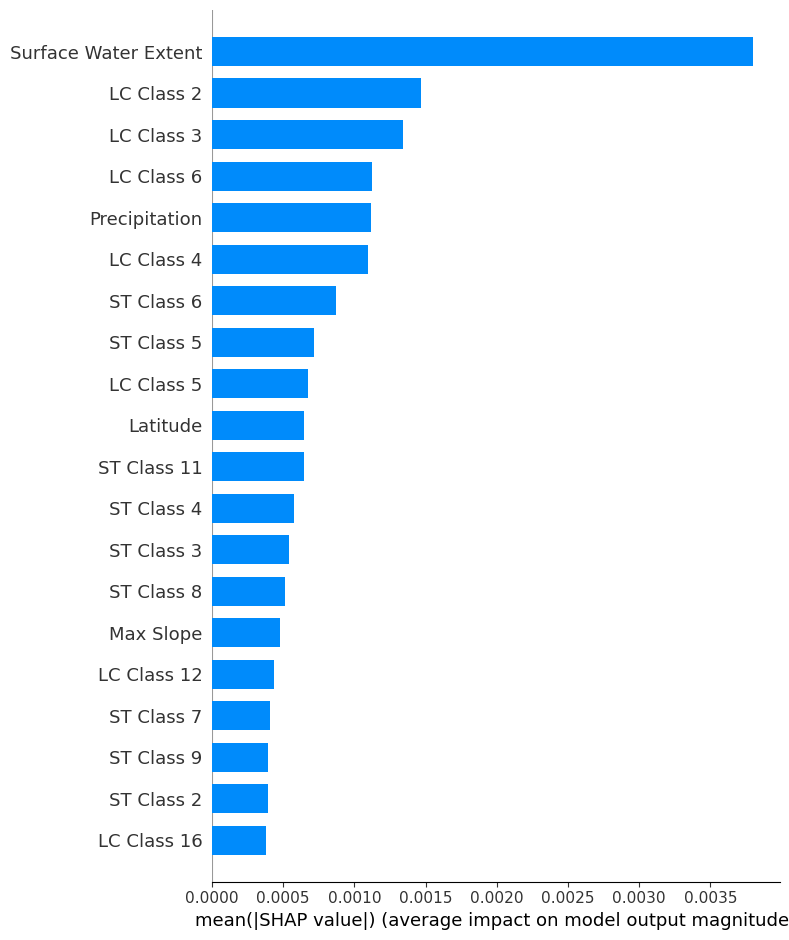

In [18]:
shap.summary_plot(shap_values, X_test, feature_names=shap_features,plot_type="bar")

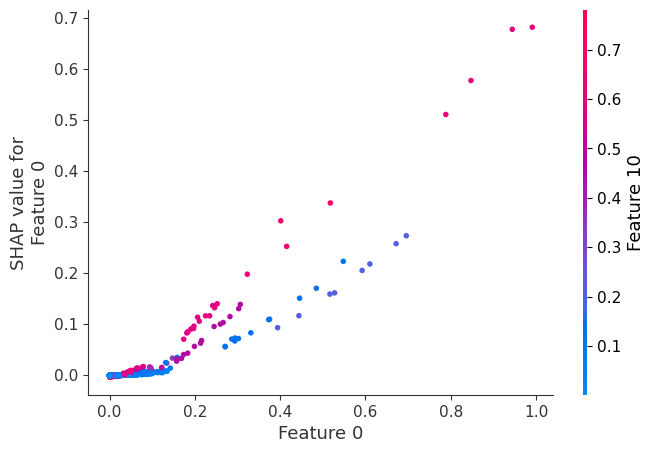

In [21]:
shap.dependence_plot("Feature 0", shap_values, X_test)

In [22]:
shap.waterfall_plot(shap_values,X_test)

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

In [ ]:
# Step 1: Predict values
# y_pred = model.predict(X_test)
# y_pred = np.expm1(y_pred)

# Step 2: Create the scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test*max(y), y_pred*max(y), alpha=0.5, label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 (y=x)', linewidth=2)

# Step 3: Add labels, title, and legend
plt.title("Streamflow Actual vs Predicted Values")
plt.xlabel("Actual Values [m${^3}$/s]")
plt.ylabel("Predicted Values [m${^3}$/s]")
plt.legend()
# plt.xlim(0,25000)
# plt.ylim(0,25000)
plt.grid(alpha=0.5)

# Step 4: Show the plot
plt.show()

In [ ]:
error = 0.25*np.arange(y.min(), y.max(),100)
y_err = np.arange(y.min(), y.max(),100)

# Step 2: Create the scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test*max(y), y_pred*max(y), alpha=0.5, label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 (y=x)', linewidth=2)
plt.fill_between(y_err, y_err-error, y_err+error,alpha=0.2,label='75th percentile')

# Step 3: Add labels, title, and legend
plt.title("Streamflow Actual vs Predicted Values")
plt.xlabel("Actual Values [m${^3}$/s]")
plt.ylabel("Predicted Values [m${^3}$/s]")
plt.legend(loc='upper left')
# plt.xlim(0,25000)
# plt.ylim(0,25000)
plt.grid(alpha=0.5)

# Step 4: Show the plot
plt.show()

In [ ]:
# zoomed in plot
# y_pred = model.predict(X_test)
# # y_pred = np.expm1(y_pred)

# Step 2: Create the scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test*max(y), y_pred*max(y), alpha=0.5, label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 (y=x)', linewidth=2)
plt.fill_between(y_err, y_err-error, y_err+error,alpha=0.2,label='75th percentile')

# Step 3: Add labels, title, and legend
plt.title("Streamflow Actual vs Predicted Values")
plt.xlabel("Actual Values [m${^3}$/s]")
plt.ylabel("Predicted Values [m${^3}$/s]")
plt.legend()
plt.xlim(0,25000)
plt.ylim(0,25000)
plt.grid(alpha=0.5)

# Step 4: Show the plot
plt.show()

In [ ]:
# Create the log-log plot

xlog = np.log(y_test*max(y))
ylog = np.log(y_pred*max(y))

plt.figure(figsize=(5,6))
plt.scatter(xlog, ylog)
# Add labels and title
plt.xlabel('Log of Actual Values')
plt.ylabel('Log of Predicted Values')
plt.title('Streamflow Actual vs Predicted Log-Log Plot')

# Customize gridlines (optional)
plt.grid(True, which="both", ls="-")

# Show the plot
plt.show()

In [ ]:
# Extract loss and validation loss from the training history
test_values = y_test*max(y)
pred_values = y_pred*max(y)

test_values = np.ravel(test_values)
pred_values = np.ravel(pred_values)

# Create a new DataFrame
pred_df = pd.DataFrame({
    'Test Values': test_values,
    'Predicted Values': pred_values
})

file_path =  '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/test_vs_pred_values.csv'

# Export to a CSV file
# pred_df.to_csv(file_path, index=False)

from sklearn.metrics import r2_score

# Assuming test_values and pred_values are 1D arrays or lists
r_squared = r2_score(test_values, pred_values)
print(f"R-squared value: {r_squared}")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Extract loss and validation loss from the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a new DataFrame
loss_df = pd.DataFrame({
    'Epoch': range(1, len(training_loss) + 1),  # Adding epoch numbers
    'Training Loss': training_loss,
    'Validation Loss': validation_loss
})

file_path =  '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/training_validation_losses.csv'

# Export to a CSV file
loss_df.to_csv(file_path, index=False)

# print((max(y_train) - min(y_train))**2)
plt.figure(figsize=(5,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss',color='r',alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Huber Loss [m${^3}$/s]')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title('Loss Over Epochs')
# plt.ylim(0.00001, 0.0002)
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

residuals = y_test - model.predict(X_test)
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [ ]:
# Plot y_test and y_pred as a time series
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test*max(y), label="Actual Values (y_test)", color="blue", alpha=0.7)
plt.plot(np.arange(len(y_pred)), y_pred*max(y), label="Predicted Values (y_pred)", color="red", alpha=0.7)
plt.title("Actual vs Predicted Values of Test Dataset")
plt.xlabel("Test Dataset")
plt.ylabel("Streamflow [m${^3}$/s]")
plt.xlim(0,len(y_test))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot y_test and y_pred as a time series
plt.figure(figsize=(12, 6))
plt.plot((np.arange(len(y_test)))[0:500], (y_test*max(y))[0:500], label="Actual Values (y_test)", color="blue", alpha=0.7)
plt.plot((np.arange(len(y_pred)))[0:500], (y_pred*max(y))[0:500], label="Predicted Values (y_pred)", color="red", alpha=0.7)

# Add titles and labels
plt.title("Actual vs Predicted Values of Test Dataset (element 0 to 500)")
plt.xlabel("Test Dataset")
plt.ylabel("Streamflow [m${^3}$/s]")
# plt.xlim(0,len(y_test))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.scatter(scaled,q)
plt.title('Raw Data - All Basins')
plt.xlabel('Surface Water Extent Area [km${^2}$]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

In [ ]:
plt.scatter(area,q,color='g')
plt.title('Raw Data - All Basins')
plt.xlabel('Total Basin Area [km${^2}$]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

In [ ]:
plt.scatter(lat*np.pi/180,q,color='r')
plt.title('Raw Data - All Basins')
plt.xlabel('Latitude [deg]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

In [ ]:
plt.scatter(avg_slope,q,color='purple')
plt.title('Raw Data - All Basins')
plt.xlabel('Slope [deg]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

In [ ]:
plt.scatter(max_slope,q,color='brown')
plt.title('Raw Data - All Basins')
plt.xlabel('Slope [deg]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

In [ ]:
plt.scatter(precip/1e6,q,color='blue')
plt.title('Raw Data - All Basins')
plt.xlabel('Precip []')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

In [ ]:
lc_class = lc_types.idxmax(axis=1)
plt.scatter(lc_class,q,color='orange')
plt.title('Raw Data - All Basins')
plt.xlabel('Land Cover Type')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

In [ ]:
soil_class = soil_types.idxmax(axis=1)

plt.scatter(soil_class,q,color='darkorange')
plt.title('Raw Data - All Basins')
plt.xlabel('Soil Texture')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

In [ ]:
grouped = total_df.groupby('Area')['Q'].mean()

# Extract unique areas and their corresponding average Q values
area_unique = grouped.index
q_avg = grouped.values

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(area_unique, q_avg, color='g')
plt.xlabel('Total Basin Area')
plt.ylabel('Average Streamflow')
plt.title('Average Streamflow vs Total Basin Area')
plt.grid(True)
plt.show()

In [ ]:
grouped = total_df.groupby('Latitude')['Q'].mean()

# Extract unique areas and their corresponding average Q values
lat_unique = grouped.index
q_avg = grouped.values

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(lat_unique, q_avg,color='red')
plt.xlabel('Latitude')
plt.ylabel('Average Streamflow')e
plt.title('Average Streamflow vs Basin Latitude')
plt.grid(True)
plt.show()

In [ ]:
filename = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rnn_plot.png'
# Ensure the directory exists
os.makedirs(os.path.dirname(filename), exist_ok=True)
from tensorflow.keras.utils import plot_model

# Plot and save the model
plot_model(model,show_dtype=True, show_layer_names=True, show_shapes=True,  to_file=filename)

# # from IPython.display import Image
# # Image(filename)